# PROYECTO: Aprendizaje Automático Relacional sobre Quakers

In [2]:
#IMPORTS:
from matplotlib import pyplot
import pandas
import numpy
import networkx as nx
import graphviz
import networkx.algorithms.community as nx_comm
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn import tree
from sklearn import preprocessing
from sklearn import naive_bayes
from sklearn.model_selection import cross_validate
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

Este proyecto ha sido realizado por Andrés Domínguez Ruiz y Pablo Núñez Moreno (este último alumno **NO** ha participado en ningún momento en el proyecto)

RESUMEN DE CONTENIDO:
- PREPARACIÓN DE LOS DATOS(crear el dataframe y estructurarlo)
- ANÁLISIS DE RESIDUOS DE LOS ATRIBUTOS
- CONSTRUCCIÓN DE LOS MODELOS
- CONCLUSIONES FINALES

# PREPARACIÓN DE LOS DATOS

In [2]:

import networkx.algorithms.community as nx_comm
G2 = nx.read_graphml("quakers-network.graphml")
print(G2)

Graph with 96 nodes and 162 edges


In [3]:
###FUNCIONES PARA FACILITAR EL TRABAJO##########
def añadir_nueva_columna(dataframe,mapa,nombre_columna):
    #Input: dataframe, mapa con clave=id del dataframe y valor=valores de la columna, nombre_columna= nombre de la columna
    #Output: void, pero añade una nueva columna con los valores 
    dataframe[nombre_columna]=pandas.Series([object])#1ºCrear nueva columna vacia(dará error pero no pasa nada)
    for i in range(0,dataframe.shape[0]):
        clave=dataframe.loc[i,'Id']
        if(clave in mapa.keys()):
            dataframe.loc[i,nombre_columna]=mapa[clave]

def obtener_datos_y_normalizar_con_dos_dataframes(dataframe_descodificado,dataframe_sin_descodificar,columna):
    #INPUT: dataframe descodificado, dataframe sin descodificar, columna=String que hace referencia a una etiqueta continua
    #OUTPUT: dataframe descodificado actualizado y devuelve los maximos y minimos del dataframe sin descodificar
    dataframe_descodificado[columna]=dataframe_sin_descodificar[columna]
    maxi=dataframe_descodificado[columna].max()
    mini=dataframe_descodificado[columna].min()
    dataframe_descodificado[columna]=(dataframe_descodificado[columna]-mini)/(maxi-mini)
    return(maxi,mini)

def obtener_datos_y_normalizar(dataframe,columna):
    #INPUT: dataframe ,columna=String que hace referencia a una etiqueta continua
    #OUTPUT: dataframe  actualizado y devuelve los maximos y minimos del dataframe antes de normalizar
    maxi=dataframe[columna].max()
    mini=dataframe[columna].min()
    dataframe[columna]=(dataframe[columna]-mini)/(maxi-mini)
    return(maxi,mini)

def normalizar_columna_y_actualizar(dataframe,columna):
    maxi=dataframe[columna].max()
    mini=dataframe[columna].min()
    dataframe[columna]=(dataframe[columna]-mini)/(maxi-mini)

def normalizar_columna(dataframe,columna,max_c,min_c):
    dataframe[columna]=(dataframe[columna]-min_c)/(max_c-min_c)
    
def normalizar_columna_con_dos_dataframes(dataframe_descodificado,dataframe_codificado,columna,max_c,min_c):
    dataframe_descodificado[columna]=dataframe_codificado[columna]
    dataframe_descodificado[columna]=(dataframe_descodificado[columna]-min_c)/(max_c-min_c)
    
def selector_intervalo_fecha(valor,maxi,mini,mid):
    if(valor<mini): return f'(-inf,{mini})'
    elif(valor>=mini and valor<mid): return f'[{mini},{mid})'
    elif(valor>=mid and valor<maxi): return f'[{mid},{maxi})'
    else: return f'[{maxi},inf)'

def selector_intervalo_clustering(valor):
    if(valor<0): return '(inf,0)'
    elif(valor >= 0 and valor < 0.5): return '[0,0.5)'
    elif(valor>=0.5 and valor<1.): return '[0.5,1)'
    else: return '[1,inf)'

def selector_intervalo_degree(valor,maxi,mini,mid):
    if(valor>=mini and valor<mid): return f'[{mini},{mid})'
    elif(valor>=mid and valor<maxi): return f'[{mid},{maxi})'
    else: return f'[{maxi},inf)'
#Esto tal vez se puede considerar un algoritmo
def codificacion_manual(dataframe,columna):
    #Input: dataframe= Dataframe, columna=String, nombre de la columna que quieres codificar del dataframe
    #Output: void, pero codifica la columna del dataframe
    memoria=[]#1º Creo una lista que servirá de memoria
    for i in range(0,dataframe.shape[0]):#2ºVoy recorriendo todas las filas y voy cogiendo el valor de la columna
        clave=dataframe.loc[i,columna]
        if(clave not in memoria): memoria.append(clave)#3º Si el valor no se encuentra en la memoria, lo añado
        dataframe.loc[i,columna]=memoria.index(clave)#4º Actualizo el valor de la columna con el indice en el que se encuentra el valor en la memoria

def discretizar_valores_normalizados(valor):
    if(valor<0): return '(inf,0)'
    elif(valor >= 0 and valor < 0.5): return '[0,0.5)'
    elif(valor>=0.5 and valor<1.): return '[0.5,1)'
    else: return '[1,inf)'


Lo primero que vamos a hacer es leer el fichero de nodos, y aquí se encontraron dos problemas:
- 1º Durante la lectura del fichero, la cabecera también se leia, pero se entendia como una fila más, haciendo que el parámetro del read_csv header=None no afectase. Y tampoco servía hacer .drop(0), ya que el index de las filas se mantenia  **Solución elegida:** utilizar skiprows=1 y asi saltarnos la primera fila (otra solución habría sido hacer .drop(0) y luego resetear el index)
- 2º El nodo con Identificador=Jane Sowle no tenía ningún valor en el campo historical_significance, generando problemas durante el entrenamiento de los modelos. **Solución elegida:** sustituir su valor por 'Nothing', añadiendo una nueva clase a historical_significance

In [5]:

#Id,Label,historical significance,gender,birthdate,deathdate,other_id
quarters = pandas.read_csv('quaker-nodes.csv', header=None,
                       names=['Id', 'Label', 'historical_significance', 'gender',
                              'birthdate', 'deathdate', 'other_id'],skiprows=1)
print("historical_significance original del nodo 90:",quarters.loc[90,'historical_significance'])
quarters.loc[90,'historical_significance']='Nothing'
print("historical_significance actualizado del nodo 90:",quarters.loc[90,'historical_significance'])
quarters.head(91)

historical_significance original del nodo 90: nan
historical_significance actualizado del nodo 90: Nothing


,Id,Label,historical_significance,gender,birthdate,deathdate,other_id
0,George Keith,George Keith,Quaker schismatic and Church of England clergyman,male,1638,1716,10006784
1,Robert Barclay,Robert Barclay,religious writer and colonial governor,male,1648,1690,10054848
2,Benjamin Furly,Benjamin Furly,merchant and religious writer,male,1636,1714,10004625
3,Anne Conway Viscountess Conway and Killultagh,Anne Conway Viscountess Conway and Killultagh,philosopher,female,1631,1679,10002755
4,Franciscus Mercurius van Helmont,Franciscus Mercurius van Helmont,physician and cabbalist,male,1614,1698,10005781
...,...,...,...,...,...,...,...
86,Thomas Lawson,Thomas Lawson,Quaker minister and botanist,male,1630,1691,10007210
87,John Penington,John Penington,Quaker apologist and controversialist,male,1655,1710,10009526
88,Mary Penington,Mary Penington,Quaker and writer,female,1623,1682,10009527
89,Thomas Story,Thomas Story,Quaker minister and journal writer,male,1670,1742,10011614


Tras la lectura del fichero de los nodos, ahora toca añadir al Dataframe las métricas relacionales: **la comunidad a la que pertenece cada nodo, el grado de centralidad y el grado de agrupamiento (clustering)**

Empecemos con la detección de comunidades. Para realizar esto,opté por utilizar el algoritmo de Lovain que proporciona networkX ya que es la que presenta un mayor grado de modularidad y la que presenta un grado de similaridad parecido al que proporciona el algoritmo de Walktrap(este no lo he utilizado porque networkX sólo proporciona el algoritmo base de detección de comunidades y el algoritmo de Louvain)

In [6]:


comunidades = nx_comm.louvain_communities(
                G          = G2,
                resolution = 1
             )


print(len(comunidades))

8


Esta función de networkX devuelve una lista de conjuntos de los identificadores que utilicen los nodos del grafo, en los que cada conjunto equivale a una comunidad.

Con la lista de comunidades obtenidas, ahora podiamos crear un diccionario teniendo como clave los Id de los nodos y como valor la etiqueta de la comunidad a la que pertenece

In [7]:

map_for_nodes={}
for node in G2.nodes():
    for i in range(len(comunidades)):
        if(node in comunidades[i]):
            map_for_nodes[node]=f'comunidad-{i}'
            break

In [8]:
print(map_for_nodes)
map_for_nodes['Thomas Aldam']

{'George Keith': 'comunidad-2', 'William Bradford': 'comunidad-1', 'George Whitehead': 'comunidad-4', 'George Fox': 'comunidad-0', 'William Penn': 'comunidad-1', 'Franciscus Mercurius van Helmont': 'comunidad-2', 'Anne Conway Viscountess Conway and Killultagh': 'comunidad-2', 'Benjamin Furly': 'comunidad-2', 'Robert Barclay': 'comunidad-2', 'David Barclay of Ury': 'comunidad-2', 'William Caton': 'comunidad-2', 'Alexander Parker': 'comunidad-3', 'Stephen Crisp': 'comunidad-2', 'John Stubbs': 'comunidad-2', 'James Parnel': 'comunidad-2', 'Richard Claridge': 'comunidad-1', 'Margaret Fell': 'comunidad-3', 'David Lloyd': 'comunidad-1', 'Mary Penington': 'comunidad-7', 'Thomas Story': 'comunidad-1', 'James Claypoole': 'comunidad-1', 'Tace Sowle': 'comunidad-1', 'Rebecca Travers': 'comunidad-4', 'John Burnyeat': 'comunidad-1', 'Edward Haistwell': 'comunidad-1', 'James Logan': 'comunidad-1', 'Isaac Norris': 'comunidad-1', 'Isabel Yeamans': 'comunidad-1', 'Leonard Fell': 'comunidad-0', 'John Pe

'comunidad-5'

Para añadir esta asignación de comunidades al Dataframe, se creó la función **"añadir_nueva_columna"**(se encuentra en FUNCIONES PARA FACILITAR EL TRABAJO), el cuál añade la nueva columna a partir del diccionario y el nombre de la columna. El mecanismo de esta función consiste en recorrer todas las filas del dataframe e ir cogiendo su 'Id', y a partir de este 'Id' buscaba su valor en el diccionario. Tras obtener el valor, se le añade a la fila correspondiente el nuevo campo y su valor.

In [9]:
quarters_data=quarters
añadir_nueva_columna(quarters_data,map_for_nodes,'community')
quarters_data

,Id,Label,historical_significance,gender,birthdate,deathdate,other_id,community
0,George Keith,George Keith,Quaker schismatic and Church of England clergyman,male,1638,1716,10006784,comunidad-2
1,Robert Barclay,Robert Barclay,religious writer and colonial governor,male,1648,1690,10054848,comunidad-2
2,Benjamin Furly,Benjamin Furly,merchant and religious writer,male,1636,1714,10004625,comunidad-2
3,Anne Conway Viscountess Conway and Killultagh,Anne Conway Viscountess Conway and Killultagh,philosopher,female,1631,1679,10002755,comunidad-2
4,Franciscus Mercurius van Helmont,Franciscus Mercurius van Helmont,physician and cabbalist,male,1614,1698,10005781,comunidad-2
...,...,...,...,...,...,...,...,...
91,Elizabeth Leavens,Elizabeth Leavens,Quaker missionary,female,1555,1665,10007246,comunidad-3
92,Lewis Morris,Lewis Morris,politician in America,male,1671,1746,10008534,comunidad-3
93,Sir Charles Wager,Sir Charles Wager,naval officer and politician,male,1666,1743,10012403,comunidad-3
94,William Simpson,William Simpson,Quaker preacher,male,1627,1671,10011114,comunidad-7


Tras aplicar la detección de comunidades, podemos seguir con los coeficientes de agrupamiento de los nodos del grafo, y para eso, podemos utilizar la función que ya proporciona NetworkX, la cuál devuelve un diccionario cuyas claves son los Identificadores de los nodos y cuyos valores son el coeficiente de clustering NORMALIZADO.

Una vez aplicamos la función, podemos utilizar una vez más 'añadir_nueva_columna' y añadir el coeficiente de agrupamiento en el Dataframe.

In [10]:
#Con esto, hallamos el coeficiente de clustering de todos los nodos del grafo
#(esto lo he encontrado en la página web de networkX)
clustering_map=nx.clustering(G2,weight=None)
print(clustering_map)
añadir_nueva_columna(quarters_data,clustering_map,'clustering')
quarters_data

{'George Keith': 0.2857142857142857, 'William Bradford': 0.6666666666666666, 'George Whitehead': 0.07692307692307693, 'George Fox': 0.09956709956709957, 'William Penn': 0.06535947712418301, 'Franciscus Mercurius van Helmont': 1.0, 'Anne Conway Viscountess Conway and Killultagh': 0, 'Benjamin Furly': 0.2, 'Robert Barclay': 0.3333333333333333, 'David Barclay of Ury': 0, 'William Caton': 0.2, 'Alexander Parker': 0.06666666666666667, 'Stephen Crisp': 0.6666666666666666, 'John Stubbs': 0.2, 'James Parnel': 1.0, 'Richard Claridge': 0, 'Margaret Fell': 0.10256410256410256, 'David Lloyd': 1.0, 'Mary Penington': 0.16666666666666666, 'Thomas Story': 0, 'James Claypoole': 0, 'Tace Sowle': 0.3333333333333333, 'Rebecca Travers': 0.3333333333333333, 'John Burnyeat': 0, 'Edward Haistwell': 0, 'James Logan': 0.3333333333333333, 'Isaac Norris': 0, 'Isabel Yeamans': 0, 'Leonard Fell': 0, 'John Perrot': 0.3333333333333333, 'William Coddington': 0, 'Thomas Ellwood': 0.17857142857142858, 'John Wilkinson': 

,Id,Label,historical_significance,gender,birthdate,deathdate,other_id,community,clustering
0,George Keith,George Keith,Quaker schismatic and Church of England clergyman,male,1638,1716,10006784,comunidad-2,0.285714
1,Robert Barclay,Robert Barclay,religious writer and colonial governor,male,1648,1690,10054848,comunidad-2,0.333333
2,Benjamin Furly,Benjamin Furly,merchant and religious writer,male,1636,1714,10004625,comunidad-2,0.2
3,Anne Conway Viscountess Conway and Killultagh,Anne Conway Viscountess Conway and Killultagh,philosopher,female,1631,1679,10002755,comunidad-2,0
4,Franciscus Mercurius van Helmont,Franciscus Mercurius van Helmont,physician and cabbalist,male,1614,1698,10005781,comunidad-2,1.0
...,...,...,...,...,...,...,...,...,...
91,Elizabeth Leavens,Elizabeth Leavens,Quaker missionary,female,1555,1665,10007246,comunidad-3,0
92,Lewis Morris,Lewis Morris,politician in America,male,1671,1746,10008534,comunidad-3,0
93,Sir Charles Wager,Sir Charles Wager,naval officer and politician,male,1666,1743,10012403,comunidad-3,0
94,William Simpson,William Simpson,Quaker preacher,male,1627,1671,10011114,comunidad-7,0


In [11]:
quarters_data.head(2)

,Id,Label,historical_significance,gender,birthdate,deathdate,other_id,community,clustering
0,George Keith,George Keith,Quaker schismatic and Church of England clergyman,male,1638,1716,10006784,comunidad-2,0.285714
1,Robert Barclay,Robert Barclay,religious writer and colonial governor,male,1648,1690,10054848,comunidad-2,0.333333


Ahora sólo nos queda añadir el grado de centralidad de cada nodo, el cuál NetworkX tiene una función que te lo calcula, pero devuelve los valores aplicando una normalización que no entendia. **Solución elegida:** Calcular manualmente el grado de centralidad de cada nodo, ya que este grado es igual a la cantidad de aristas que tiene cada nodo
Y para eso, hemos recogido el fichero csv de las aristas de GitHub y hemos ido leyendo de cada nodo del grafo cuantas aristas tiene.

In [12]:

flat = pandas.read_csv('quaker-edges.csv', header=None,
                       names=['Source','Target'])
edges=flat.drop(0)

centralidad_vertices={}
for node in G2.nodes():
    clave=node
    centralidad_vertices[clave]=0
    for i in range(1,edges.shape[0]+1):
        if((clave == edges.loc[i,'Source'])|(clave == edges.loc[i,'Target'])):
            centralidad_vertices[clave]=centralidad_vertices[clave]+1
centralidad_vertices

{'George Keith': 8,
 'William Bradford': 3,
 'George Whitehead': 13,
 'George Fox': 22,
 'William Penn': 18,
 'Franciscus Mercurius van Helmont': 2,
 'Anne Conway Viscountess Conway and Killultagh': 1,
 'Benjamin Furly': 10,
 'Robert Barclay': 3,
 'David Barclay of Ury': 2,
 'William Caton': 5,
 'Alexander Parker': 6,
 'Stephen Crisp': 3,
 'John Stubbs': 5,
 'James Parnel': 2,
 'Richard Claridge': 2,
 'Margaret Fell': 13,
 'David Lloyd': 2,
 'Mary Penington': 4,
 'Thomas Story': 1,
 'James Claypoole': 2,
 'Tace Sowle': 3,
 'Rebecca Travers': 4,
 'John Burnyeat': 4,
 'Edward Haistwell': 1,
 'James Logan': 4,
 'Isaac Norris': 1,
 'Isabel Yeamans': 1,
 'Leonard Fell': 1,
 'John Perrot': 7,
 'William Coddington': 1,
 'Thomas Ellwood': 8,
 'John Wilkinson': 5,
 'Edward Burrough': 9,
 'James Nayler': 16,
 'Thomas Salthouse': 2,
 'John Crook': 4,
 'Elizabeth Hooten': 1,
 'William Mead': 2,
 'Ellis Hookes': 1,
 'Francis Howgill': 7,
 'John Audland': 6,
 'William Dewsbury': 3,
 'William Mucklow

In [13]:
añadir_nueva_columna(quarters_data,centralidad_vertices,'Degree')
quarters_data.head(20)

,Id,Label,historical_significance,gender,birthdate,deathdate,other_id,community,clustering,Degree
0,George Keith,George Keith,Quaker schismatic and Church of England clergyman,male,1638,1716,10006784,comunidad-2,0.285714,8
1,Robert Barclay,Robert Barclay,religious writer and colonial governor,male,1648,1690,10054848,comunidad-2,0.333333,3
2,Benjamin Furly,Benjamin Furly,merchant and religious writer,male,1636,1714,10004625,comunidad-2,0.2,10
3,Anne Conway Viscountess Conway and Killultagh,Anne Conway Viscountess Conway and Killultagh,philosopher,female,1631,1679,10002755,comunidad-2,0,1
4,Franciscus Mercurius van Helmont,Franciscus Mercurius van Helmont,physician and cabbalist,male,1614,1698,10005781,comunidad-2,1.0,2
5,William Penn,William Penn,Quaker leader and founder of Pennsylvania,male,1644,1718,10009531,comunidad-1,0.065359,18
6,George Fox,George Fox,a founder of the Religious Society of Friends ...,male,1624,1691,10004524,comunidad-0,0.099567,22
7,George Whitehead,George Whitehead,Quaker leader and writer,male,1637,1724,10012813,comunidad-4,0.076923,13
8,William Bradford,William Bradford,printer,male,1663,1752,10001445,comunidad-1,0.666667,3
9,James Parnel,James Parnel,Quaker martyr,male,1636,1656,10009347,comunidad-2,1.0,2


In [15]:
#EXPORTACIÓN DEL MODELO A ANALIZAR:
quarters_data.to_csv('analysis_data.csv',columns=quarters_data.columns,index=True)

Ya habiendo obtenido todas las métricas relacionales, ya podemos analizar nuestro Dataframe para más tarde crear modelos ML para el mismo:

# ANÁLISIS DE RESIDUOS:

In [21]:
analysis=pandas.read_csv('analysis_data.csv', header=None,
                       names=['Id', 'Label', 'historical_significance', 'gender',
                              'birthdate', 'deathdate', 'other_id','community','clustering','Degree'],skiprows=1)

#https://www.cienciadedatos.net/documentos/pystats05-correlacion-lineal-python.html(correlación)

Para cada análisis sobre los atributos de nuestro dataframe actual, realizaremos las siguientes operaciones:
- Estudiar la correlación que hay entre cada uno de los atributos
- Estudiar la frecuencia de cada valor del atributo
- Estudiar la probabilidad
- Observar que valor es el más probable y menos probable
- Conclusión del atributo

# **1º-Análisis sobre Id**:

**Correlación:** Voy a utilizar el coeficiente de Spearman porque el de Pearson sólo funciona con atributos cuantitativos continuos y da error si aparecen discretos, y al probar el coeficiente de Kendall daba un resultado similar.

C:\Users\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


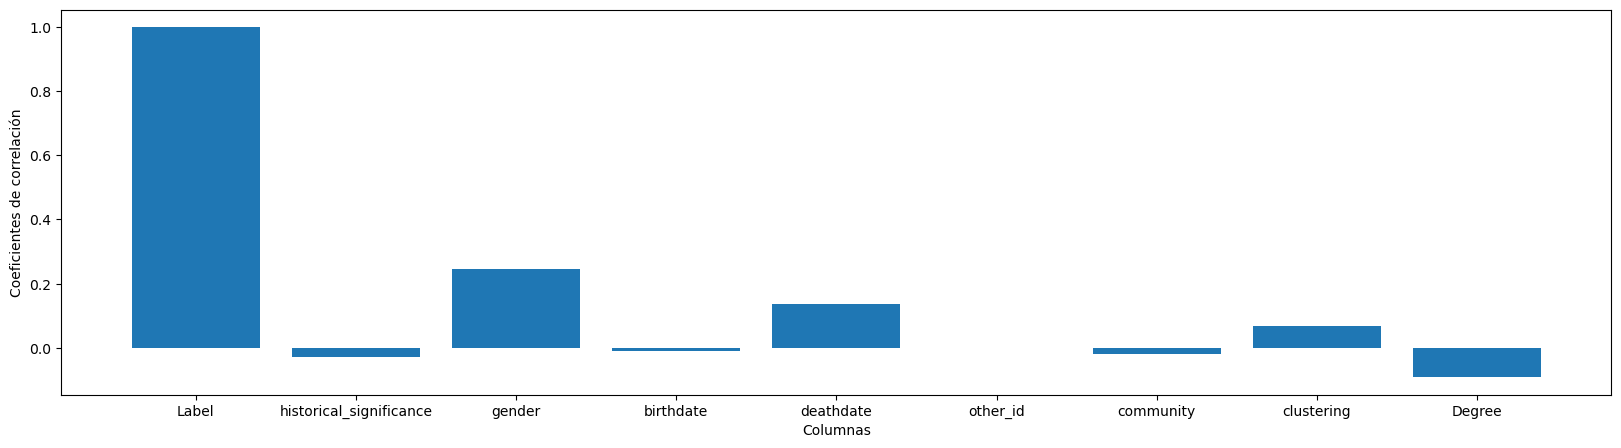

In [90]:
#Correlación: Como hay 3 tipos de coeficientes de correlación, voy a utilizar la Spearman porque la pearson sólo funciona con
# variables cuantitativas continuas
#y obtener la media, y eso es lo que interpretaremos
columnas=['Label', 'historical_significance', 'gender',
                              'birthdate', 'deathdate', 'other_id','community','clustering','Degree']
valores=[]
#Spearman, Pearson, kendall
for columna in columnas:
    corrSpe=analysis['Id'].corr(analysis[columna],method='spearman')
    valores.append(corrSpe)

pyplot.figure(figsize=(20,5))
pyplot.bar(x=columnas,height=valores,label=['Columnas','Coeficiente de correlación'])
pyplot.xlabel('Columnas')
pyplot.ylabel('Coeficientes de correlación')
pyplot.show()


Podemos observar que other_id no presenta ningún valor(ya que su correlación es nula), y esto se debe a que other_id no varía en ningún momento respecto a Id, lo que implicaría que si utilizamos esta columna durante la predecir Id no obtendríamos un modelo óptimo, obtendríamos seguramente un modelo sobreajustado. Pero por otro lado, podemos observar que Label presenta un coeficiente positivo=1.0, implicando que tanto Id como Label pueden ser iguales, aunque la correlación entre los demás atributos es muy baja o negativa ya que se encuentran entre -1 y 0.3 haciendo i que Id no sea muy predecible respecto al resto de atributos.

**Análisis sobre Id y Label:** Como parecen que son identicos ambos valores, vamos a primero comprobarlo antes de seguir:

In [17]:
print("¿Los campos Id y Label contienen la misma información?:")
lista_de_filas_no_iguales=[]
for i in range(0,analysis.shape[0]):
    if(analysis.loc[i,'Id']!=analysis.loc[i,'Label']):
        lista_de_filas_no_iguales.append(i)

if(len(lista_de_filas_no_iguales)>0): print("No, las filas ",lista_de_filas_no_iguales," no son iguales")
else: print("Si, estas dos columnas son identicas")


¿Los campos Id y Label contienen la misma información?:
Si, estas dos columnas son identicas


Como hemos visto, las dos columnas son identicas, por lo que ambas devolveran los mismos resultados durante el análisis. Ahora comprobemos cuantos valores hay:

**- Frecuencia:**

Tenemos un total de 96 clases posibles


<AxesSubplot:title={'center':'Frecuencia de valores distintos de Id'}, ylabel='Ids'>

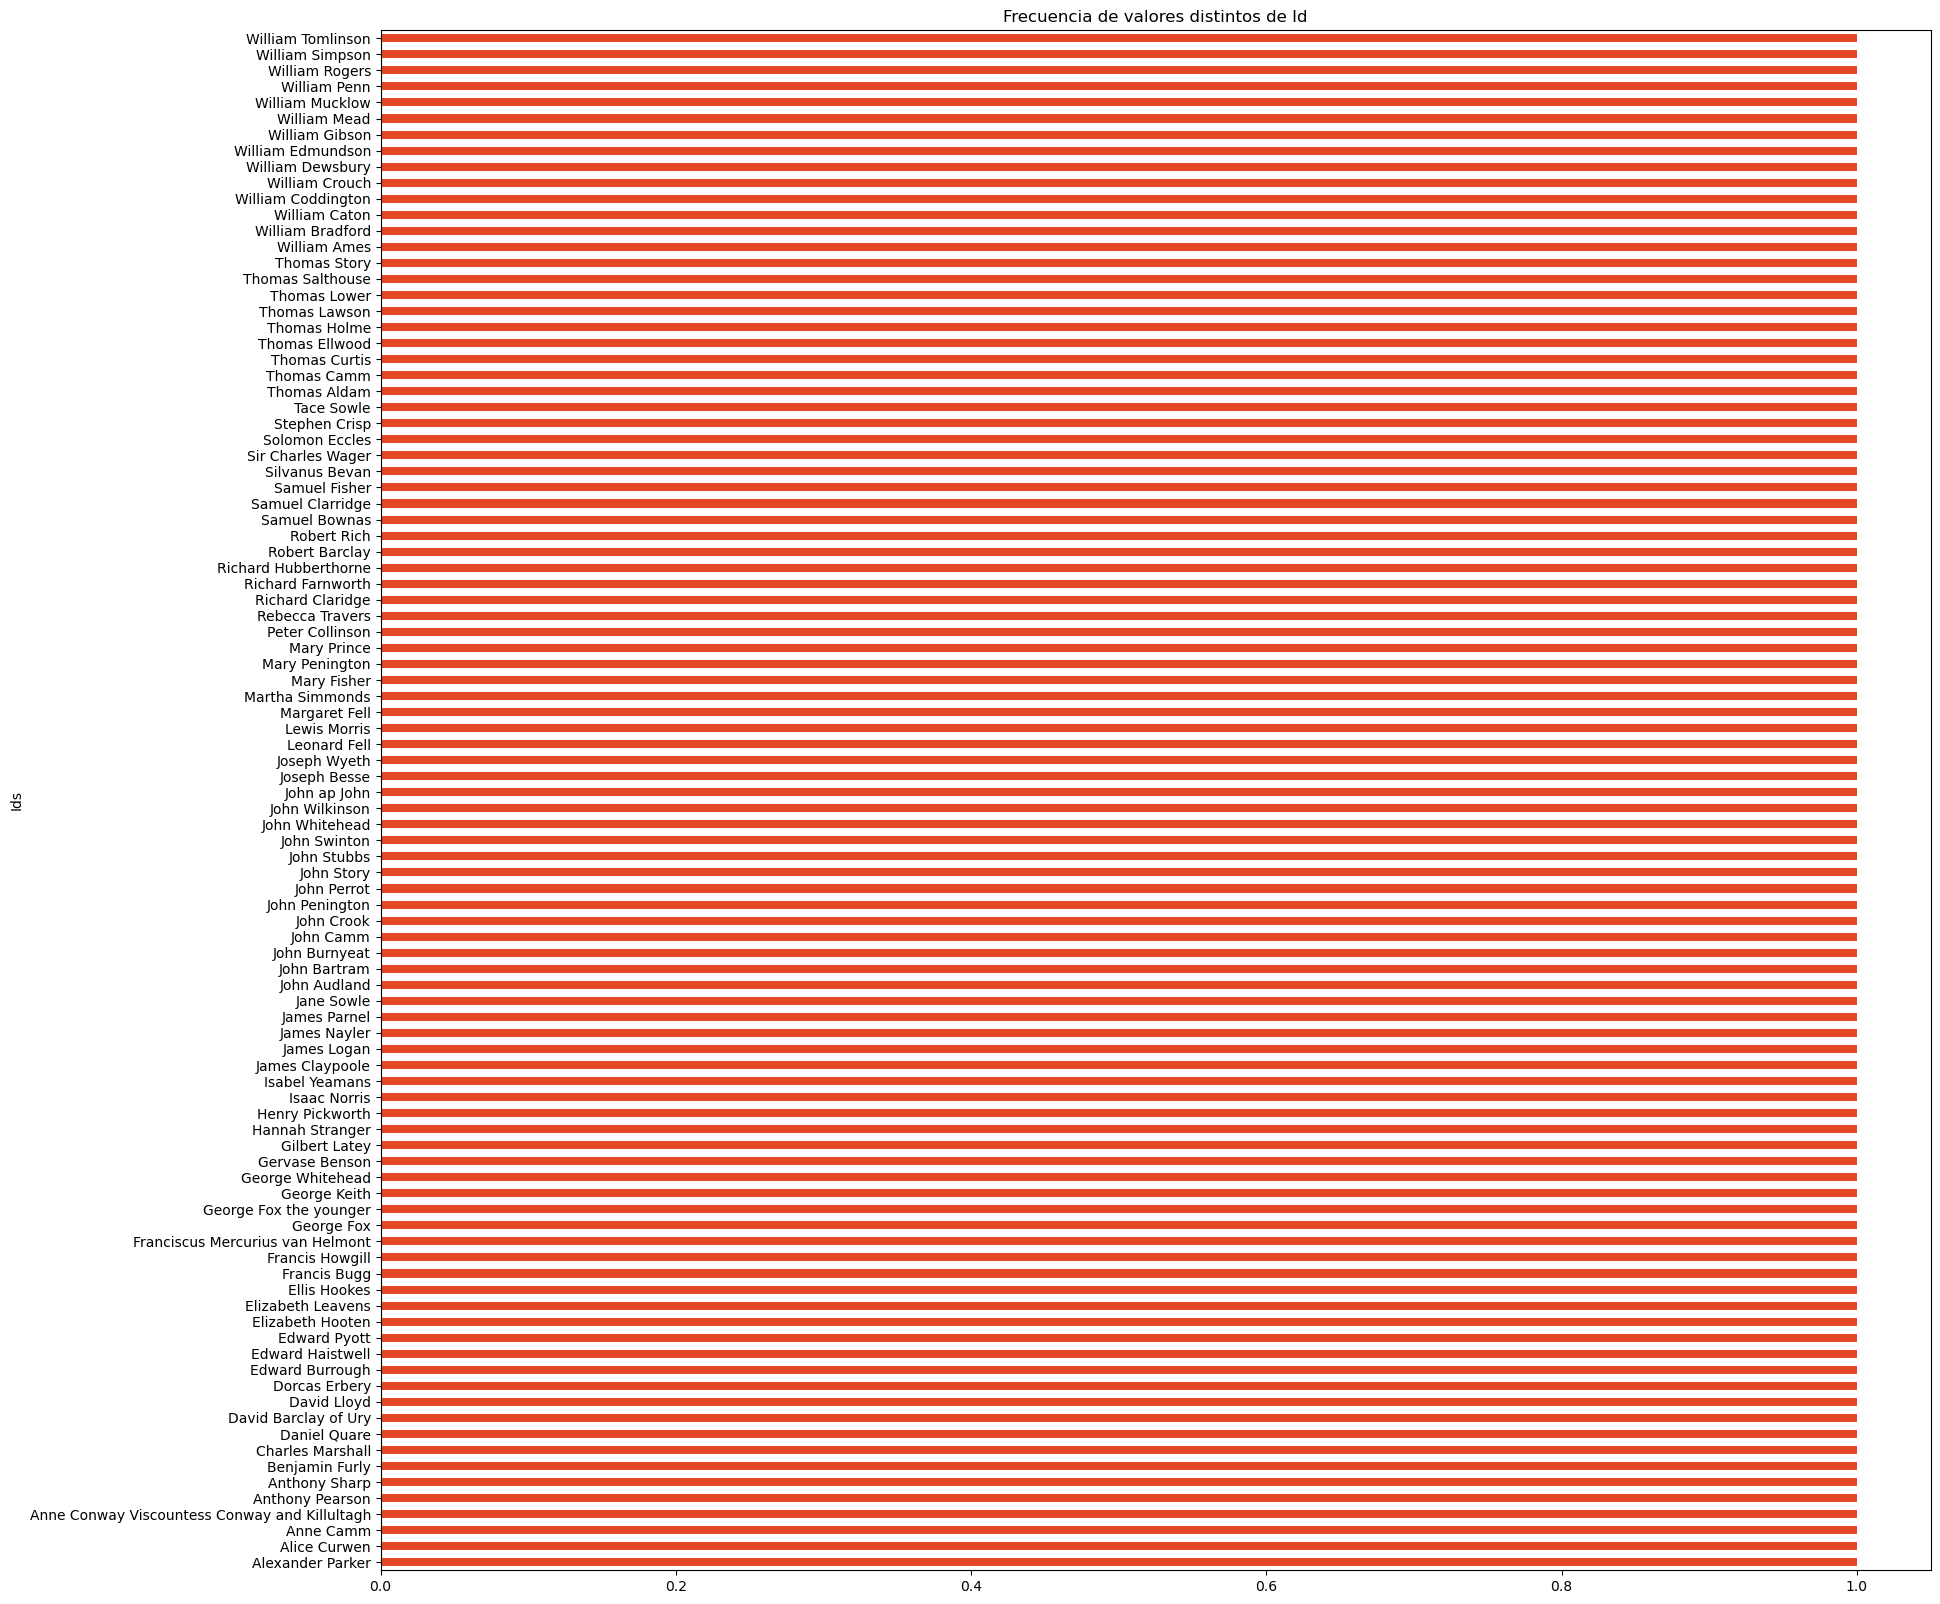

In [66]:
map_for_names={}
for i in range(0,analysis.shape[0]):
    clave=analysis.loc[i,'Id']
    if(clave in map_for_names.keys()):
        map_for_names[clave]+=1
    else:
        map_for_names[clave]=1
print(f"Tenemos un total de {len(map_for_names.keys())} clases posibles")
analysis.groupby(['Id'])['Id'].count().plot(kind='barh',color='#E34726',title='Frecuencia de valores distintos de Id',xlabel="Ids",ylabel="Frecuencia",figsize=(20,20))

**-Probabilidad:**

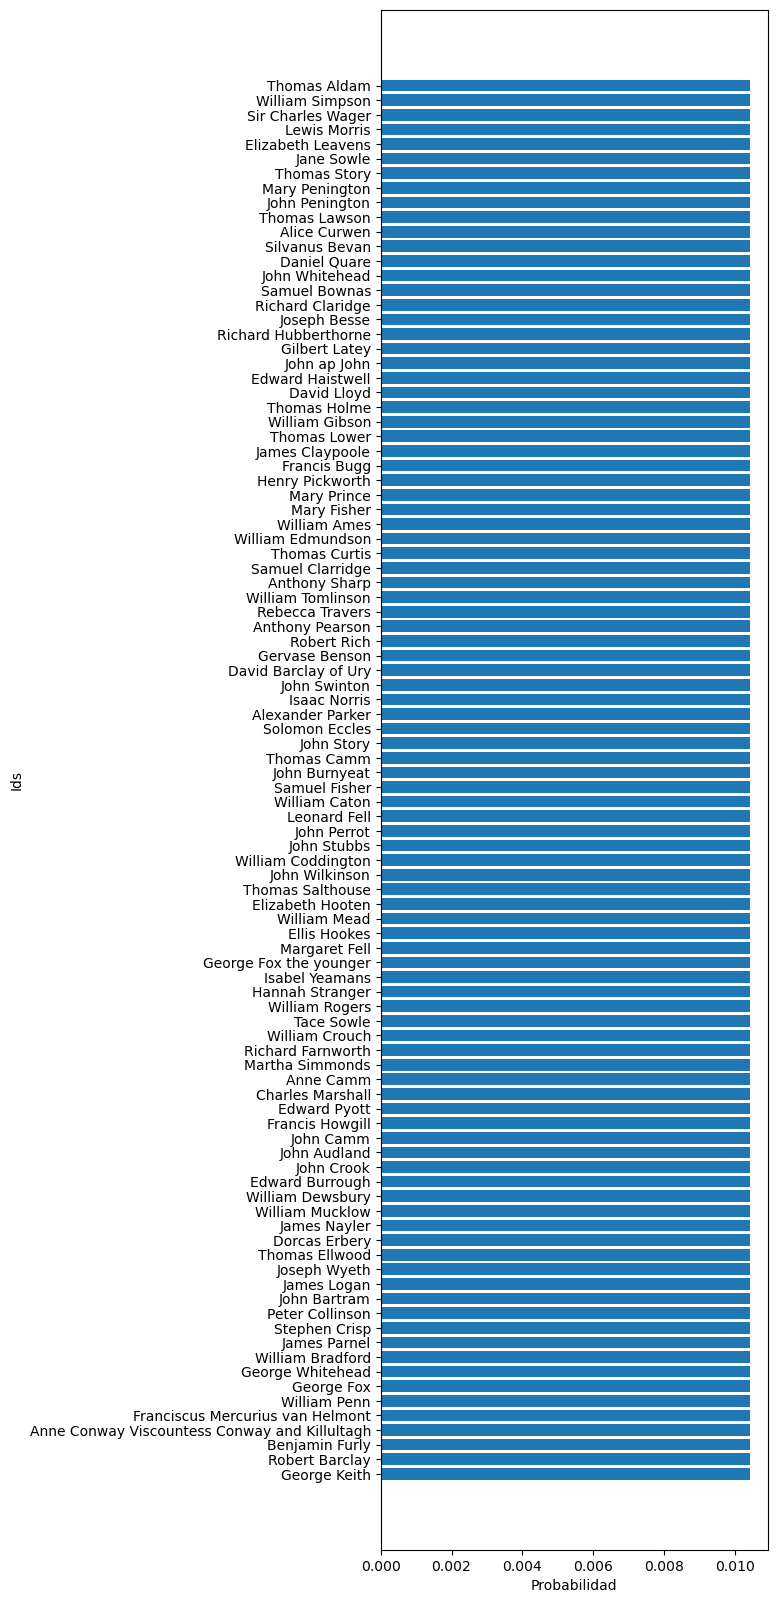

In [67]:
values=[x/96 for x in map_for_names.values()]
pyplot.figure(figsize=(5,20))
pyplot.barh(y=list(map_for_names.keys()),width=values)
pyplot.xlabel('Probabilidad')
pyplot.ylabel('Ids')
pyplot.show()

**Como todas las clases posibles sólo aparecen una vez en todo el dataframe, todos tienen tanto la misma frecuencia como la misma probabilidad, por lo que no se puede determinar aquella clase que más aparece y aquella clase que menos aparece**

**Conclusión de Id(y de Label):**
- Como no presenta mucha correlación con el resto de atributos y la frecuencia y probabilidad del mismo son mínimas, tanto Id como Label nos complicará la costrucción de modelos ML. Y como Label es idéntico a Id, las conclusiones que obtengamos serían las mismas , por lo que no sería necesario su análisis

# 2º-**Análisis sobre historical_significance:** 

**Correlación:**

C:\Users\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


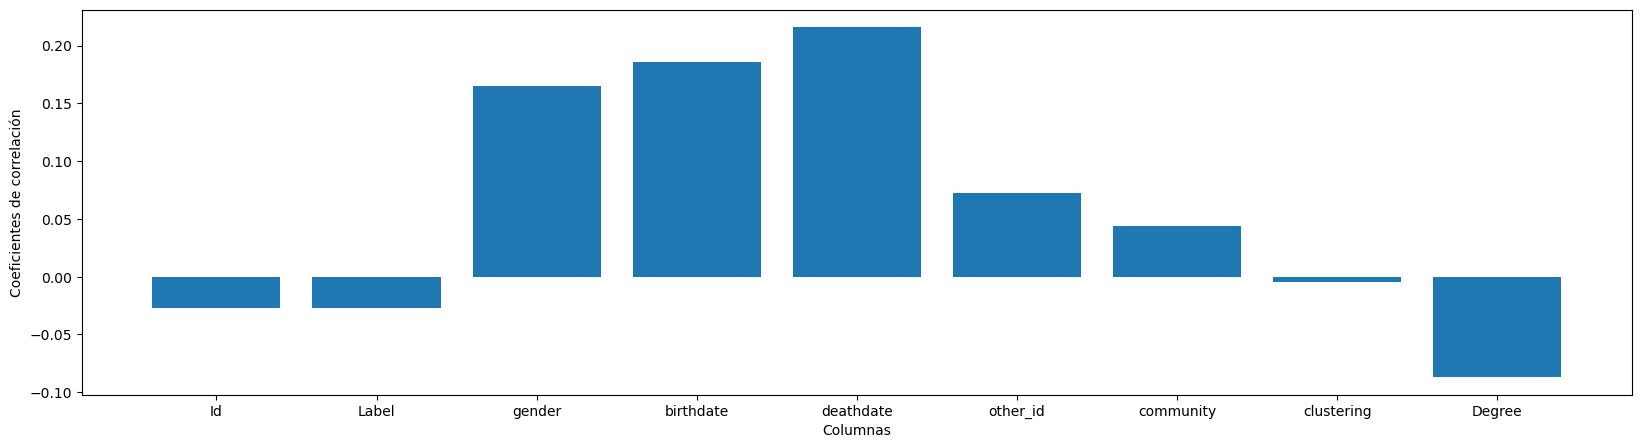

In [62]:
columnas=['Id','Label', 'gender',
                              'birthdate', 'deathdate', 'other_id','community','clustering','Degree']
valores=[]
#Spearman, Pearson, kendall
for columna in columnas:
    corrSpe=analysis['historical_significance'].corr(analysis[columna],method='spearman')
    valores.append(corrSpe)

pyplot.figure(figsize=(20,5))
pyplot.bar(x=columnas,height=valores,label=['Columnas','Coeficiente de correlación'])
pyplot.xlabel('Columnas')
pyplot.ylabel('Coeficientes de correlación')
pyplot.show()

Analizando la correlación que se observa, podemos decir que tanto Id,Label y Degree no estan muy correlacionados  con historical_significance, y aunque el resto de atributos presenten una correlación positiva, es demasiado baja para tenerla encuenta (se encuentra entre una asociación pequeña y media el atributo que más esta correlacionado).

**Frecuencia:**

Tenemos un total de  55  clases distintas, y con la siguiente frecuencia
Historical_significance más frecuente: Quaker preacher , con una frecuencia de  10


<AxesSubplot:title={'center':'Frecuencia de valores distintos de historical_significance'}, ylabel='historical_significance'>

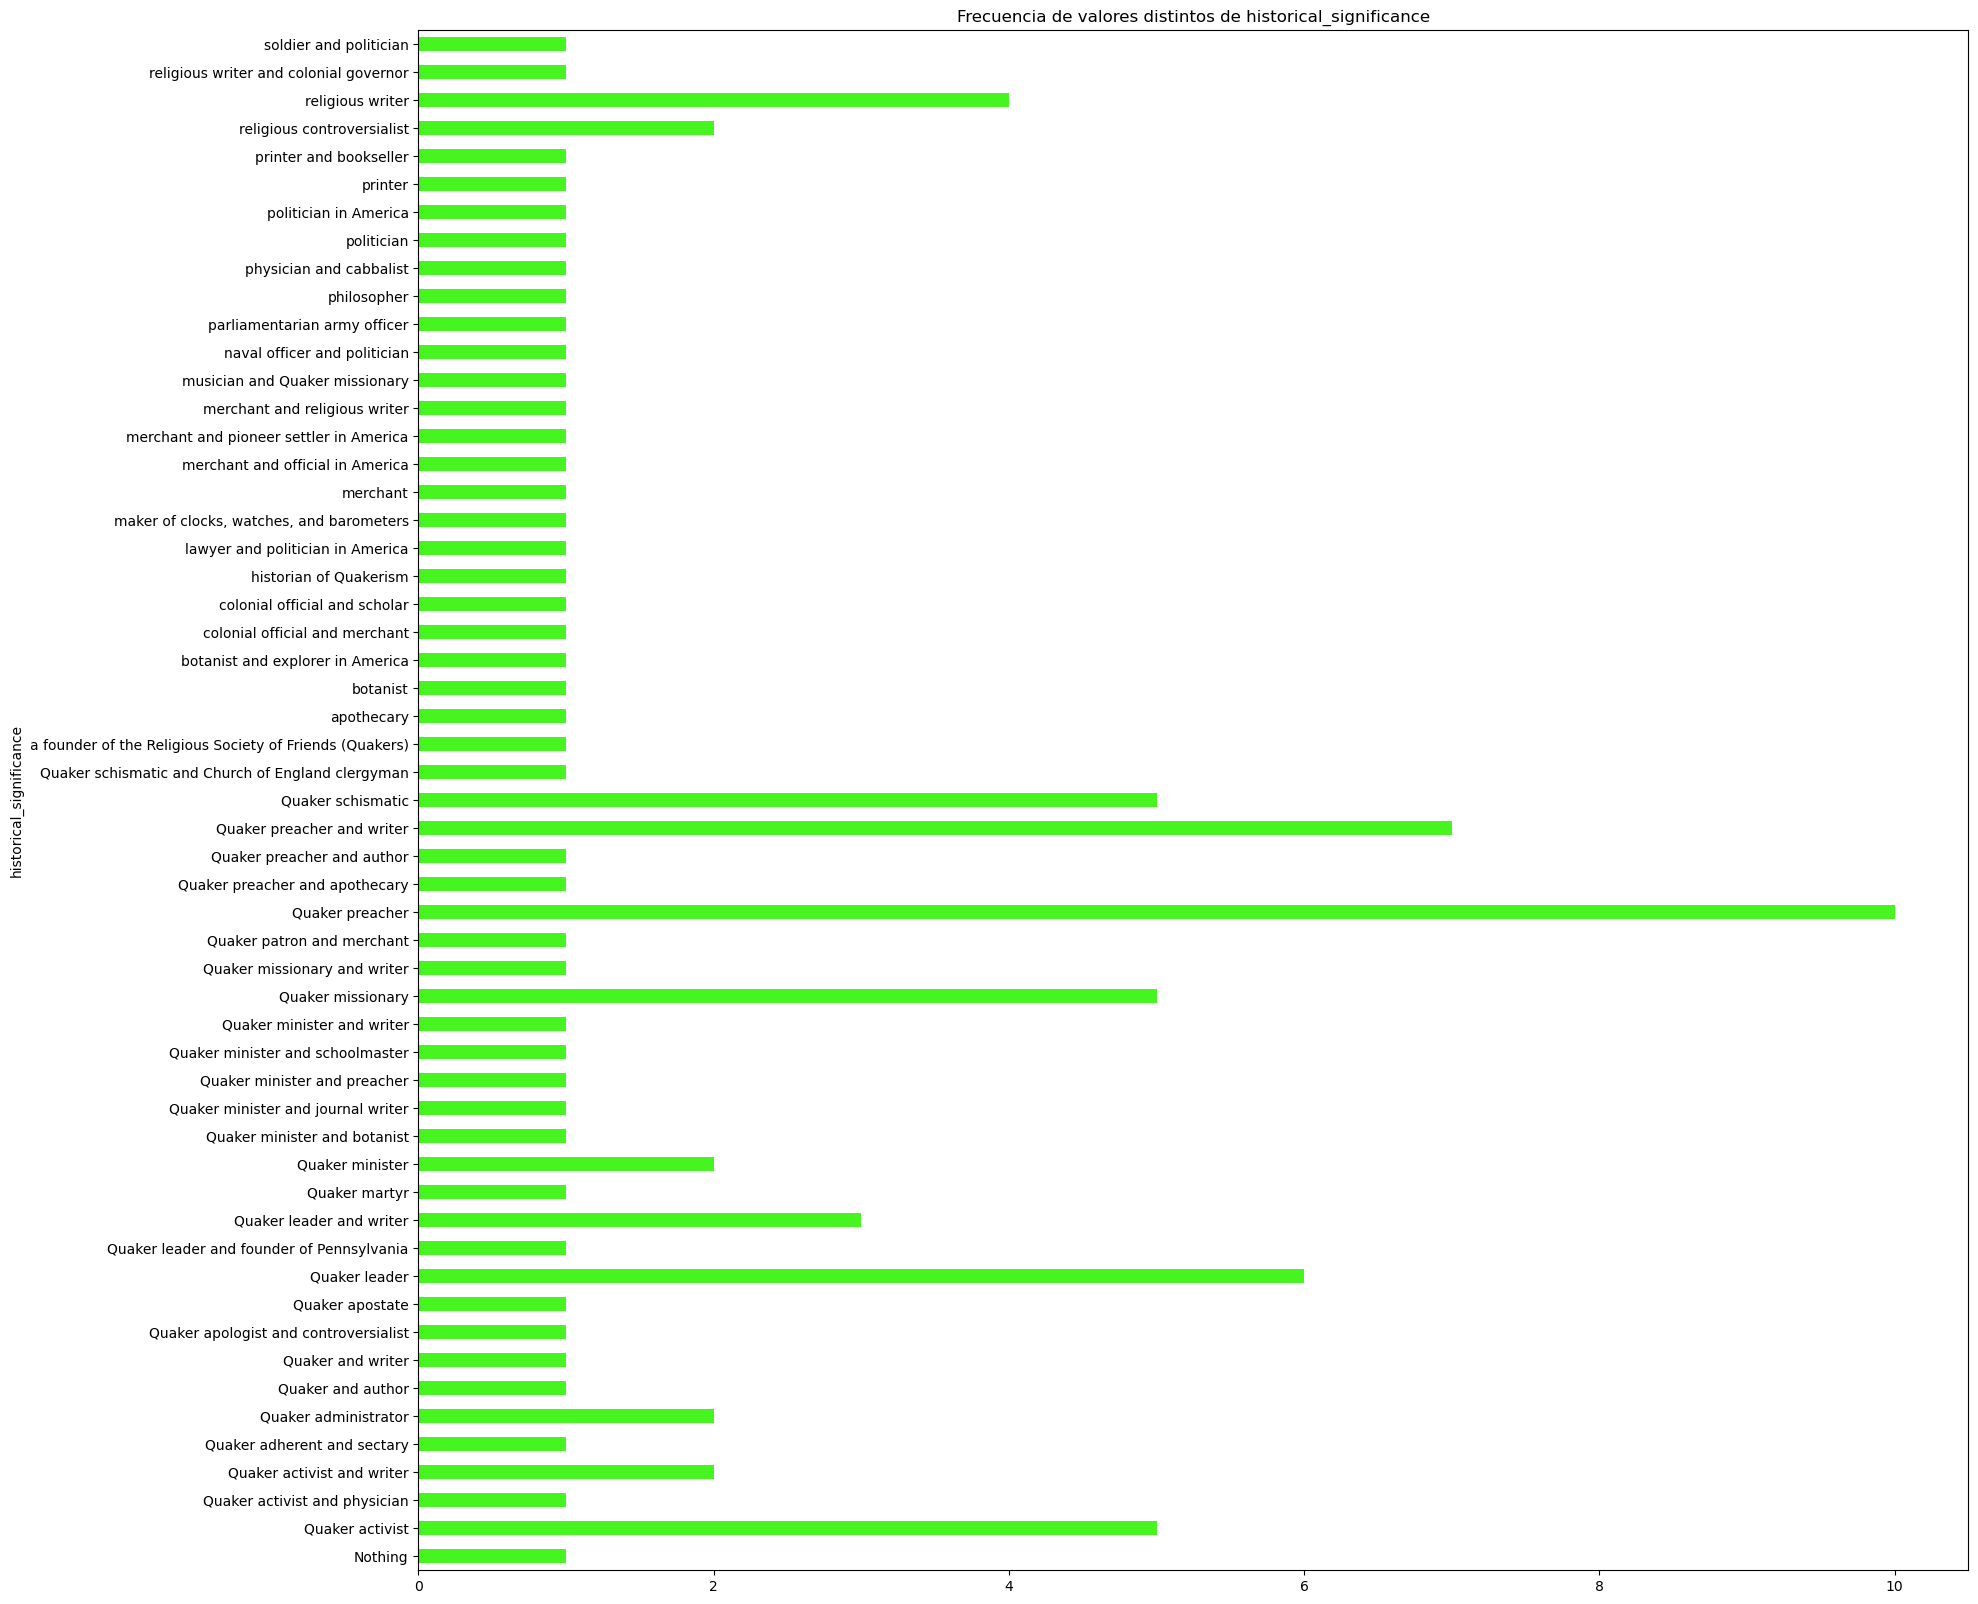

In [87]:
map_for_names={}
for i in range(0,analysis.shape[0]):
    clave=analysis.loc[i,'historical_significance']
    if(clave in map_for_names.keys()):
        map_for_names[clave]+=1
    else:
        map_for_names[clave]=1
print("Tenemos un total de ",len(map_for_names.keys())," clases distintas, y con la siguiente frecuencia")
print("Historical_significance más frecuente:",max(map_for_names,key=map_for_names.get),", con una frecuencia de ",max(map_for_names.values()))
analysis.groupby(['historical_significance'])['historical_significance'].count().plot(kind='barh',color='#46F41F',title='Frecuencia de valores distintos de historical_significance',xlabel="historical_significance",ylabel="Frecuencia",figsize=(20,20))

Vemos que tenemos muchas clases diferentes con una gran diferencia de frecuencias, por lo que este atributo puede complicar la construcción de los modelos ML. Veamos su probabilidad:

**-Probabilidad:**

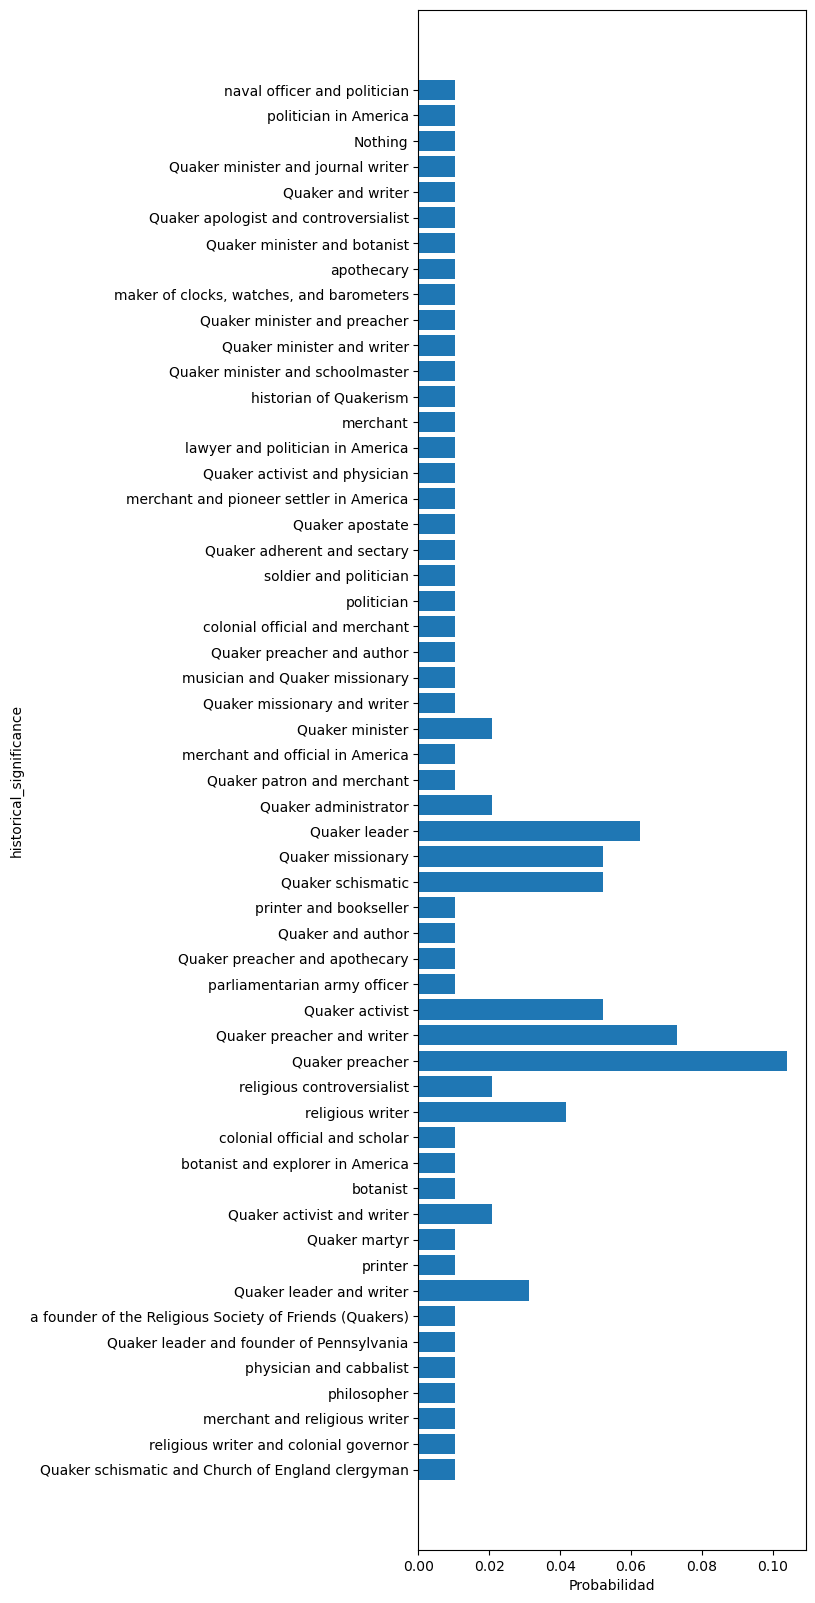

In [88]:
values=[x/96 for x in map_for_names.values()]
pyplot.figure(figsize=(5,20))
pyplot.barh(y=list(map_for_names.keys()),width=values)
pyplot.xlabel('Probabilidad')
pyplot.ylabel('historical_significance')
pyplot.show()

**Máxima frecuencia y mínima frecuencia:**
- La máxima frecuencia se da en la clase 'Quakers preachers', lo que implica que la gran mayoria de Quakers eran predicadores.
- La mínima frecuencia se da en muchas clases, lo que dificulta la estimación de la clase con menos frecuencia

Analizando la frecuencia y probabilidad, podemos decir de que Quakers estaba constituido por varios predicadores y por gente que se dedicaba a algo que el resto no.

**Conclusión:**
- Tras haber tan poca correlación con el resto de atributos y tener tan pocos ejemplos con tantas clases diferentes, si intentamos construir un modelo ML que prediga historical_significance, obtendremos un rendimiento muy malo, por lo que no deberíamos utilizar este atributo. Como este atributo es uno de los solicitados por los profesores, no lo vamos a quitar para estudiar otros modelos sobre otros atributos, pero deberíamos.

# 3º Análisis sobre gender:

**Correlación:**

C:\Users\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


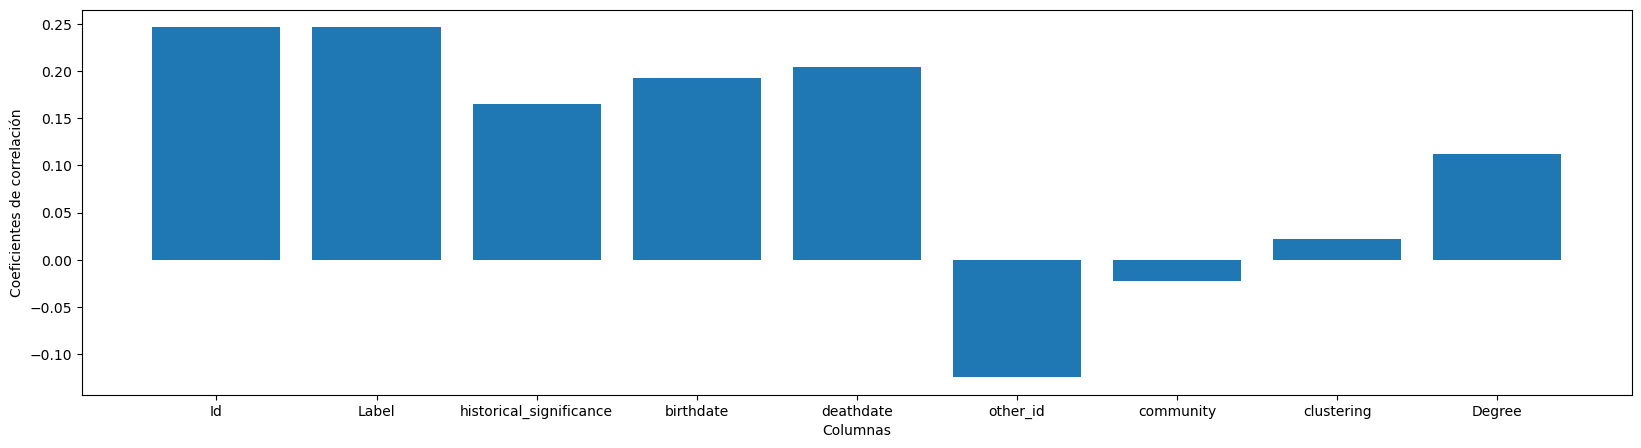

In [77]:
columnas=['Id','Label','historical_significance',
                              'birthdate', 'deathdate', 'other_id','community','clustering','Degree']
valores=[]
#Spearman, Pearson, kendall
for columna in columnas:
    corrSpe=analysis['gender'].corr(analysis[columna],method='spearman')
    valores.append(corrSpe)

pyplot.figure(figsize=(20,5))
pyplot.bar(x=columnas,height=valores,label=['Columnas','Coeficiente de correlación'])
pyplot.xlabel('Columnas')
pyplot.ylabel('Coeficientes de correlación')
pyplot.show()

A partir de esta tabla, podemos determinar que other_id y community estan muy correlacionados negativamente con gender, por lo que estos atributos nos darían problemas a la hora de hacer modelos ML que intenten predecir gender. Luego tenemos que el resto de atributos estan correlacionados positivamente con gender, sobretodo Id y Label. Esto último implica que el nombre completo de la persona esta ligeramente relacionado con el género, pero como tenemos tantos nombres distintos(Ids) como miembros de Quakers, tampoco podemos utilizarlo de forma eficiente a la hora de crear modelos ML , ya que es muy probable que obtuvieramos modelos sobreajustados.

**Frecuencia:**

Tenemos un total de  2  clases distintas, y con la siguiente frecuencia
Gender más frecuente: male , con una frecuencia de  81
Gender menos frecuente: female , con una frecuencia de  15


<AxesSubplot:title={'center':'Frecuencia de valores distintos de gender'}, ylabel='gender'>

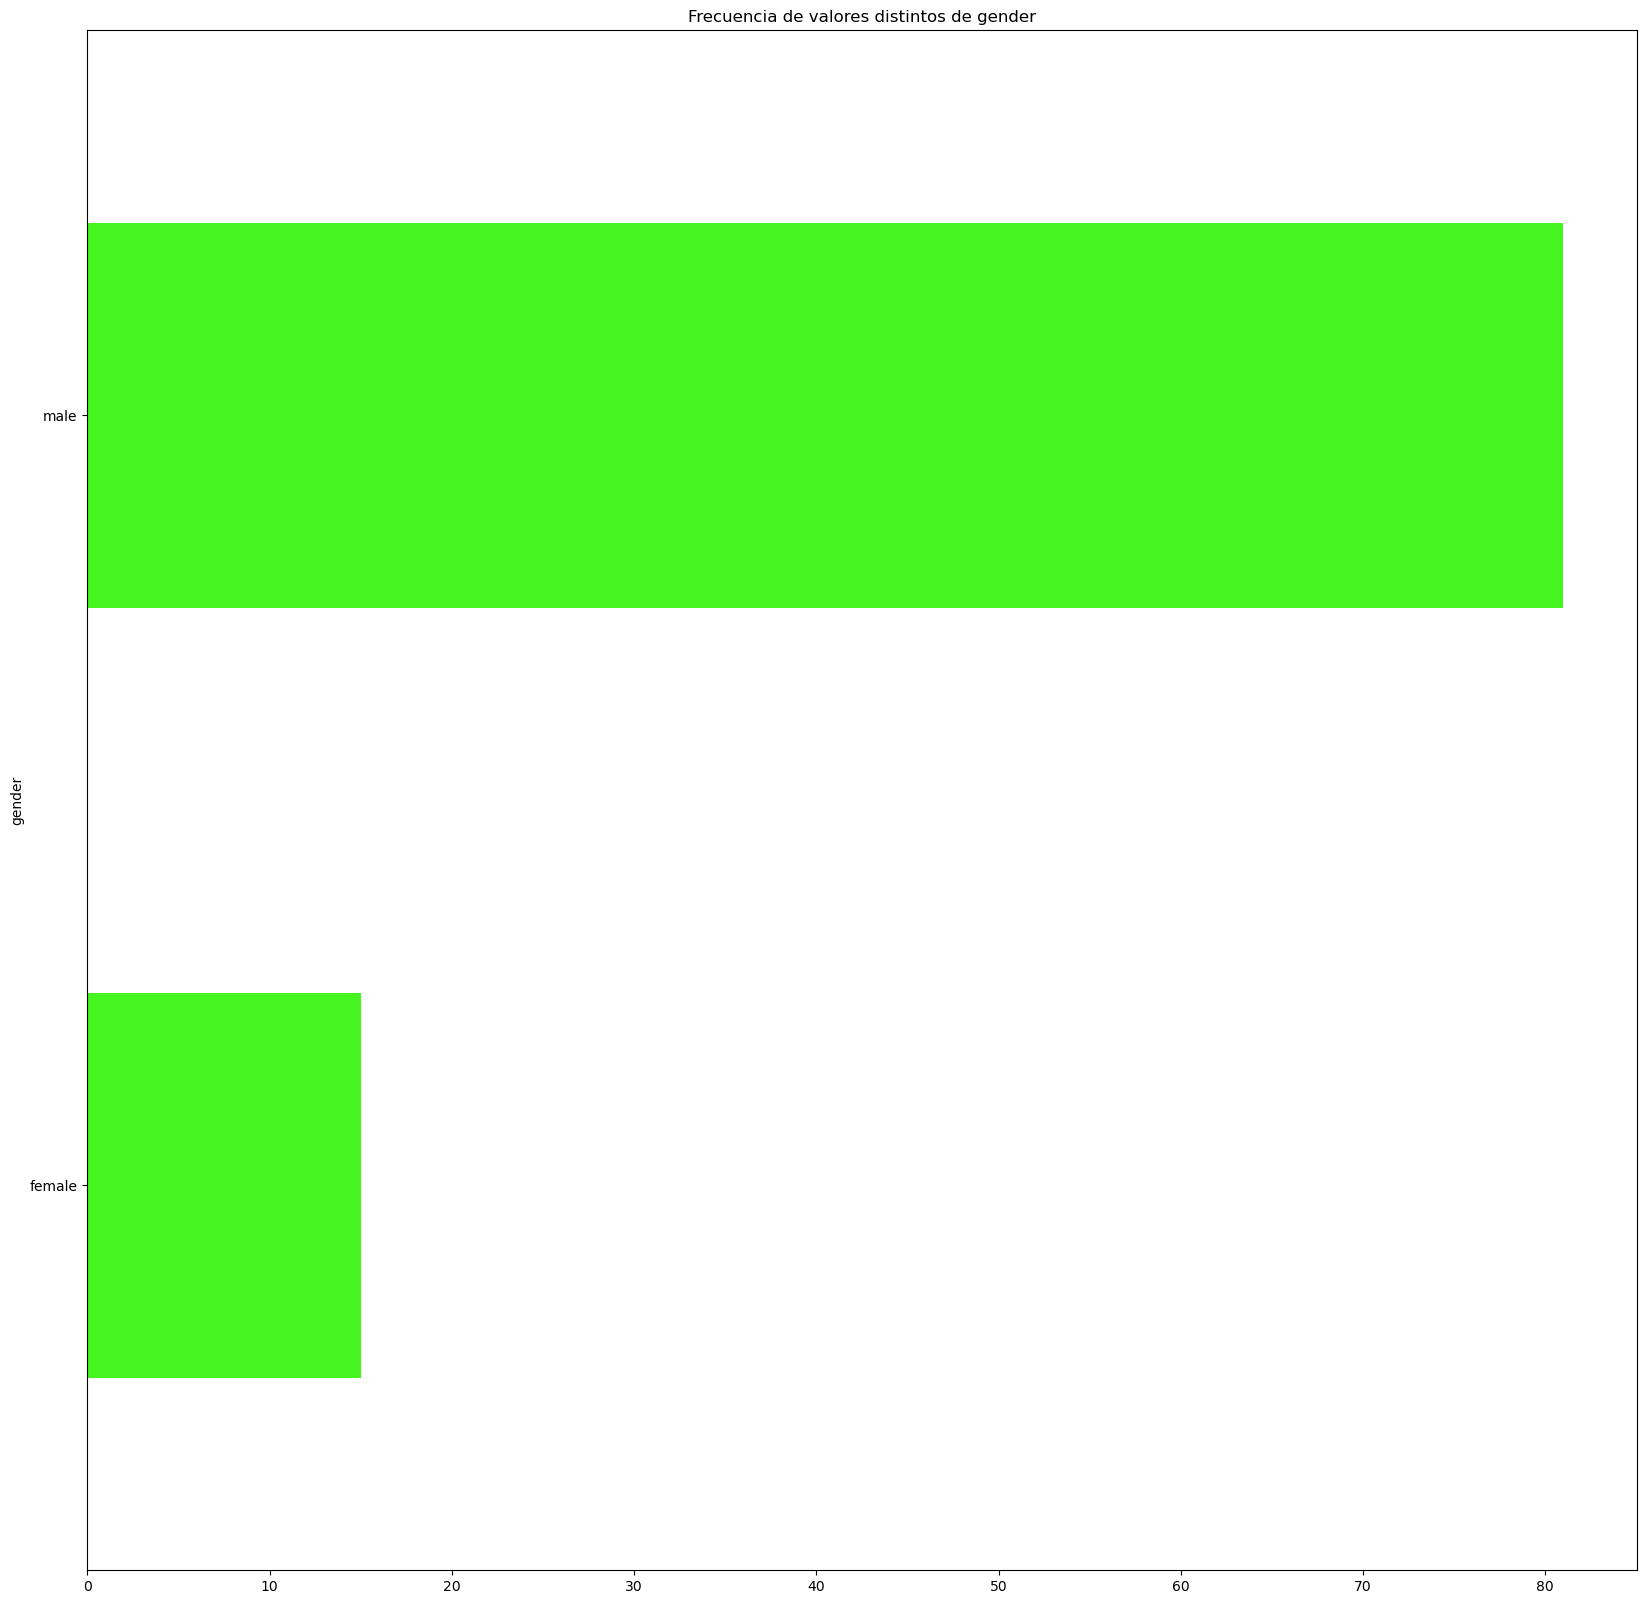

In [80]:
map_for_names={}
for i in range(0,analysis.shape[0]):
    clave=analysis.loc[i,'gender']
    if(clave in map_for_names.keys()):
        map_for_names[clave]+=1
    else:
        map_for_names[clave]=1
print("Tenemos un total de ",len(map_for_names.keys())," clases distintas, y con la siguiente frecuencia")
print("Gender más frecuente:",max(map_for_names,key=map_for_names.get),", con una frecuencia de ",max(map_for_names.values()))
print("Gender menos frecuente:",min(map_for_names,key=map_for_names.get),", con una frecuencia de ",min(map_for_names.values()))
analysis.groupby(['gender'])['gender'].count().plot(kind='barh',color='#46F41F',title='Frecuencia de valores distintos de gender',xlabel="gender",ylabel="Frecuencia",figsize=(20,20))

Tras analizar lo obtenido, resulta que el género más común en los datos es 'male'. Esto implica que la gran mayoria de miembros de Quakers eran hombres, y sólo unas pocas eran mujeres.

**Probabilidad:**

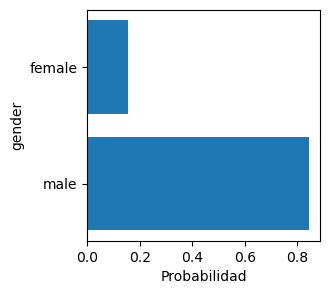

In [85]:
values=[x/96 for x in map_for_names.values()]
pyplot.figure(figsize=(3,3))
pyplot.barh(y=list(map_for_names.keys()),width=values)
pyplot.xlabel('Probabilidad')
pyplot.ylabel('gender')
pyplot.show()

**Máxima frecuencia y mínima frecuencia:**
Como se ha comentado antes, hay más hombres que mujeres en Quakers, siendo 81 y 15 la cantidad de hombres y mujeres respectivamente. Implicando junto a la probabilidad calculada que es más probable que un miembro sea hombre que mujer.

**Conclusión:**
   - Al tratarse de un atributo categórico binario y al estar correlacionado positia y ligeramente con la gran mayoria de atributos, es un atributo el cuál podemos intentar predecir en alguno de nuestros modelos.

# 4º Análisis sobre birthdate:

**Correlación:**

C:\Users\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


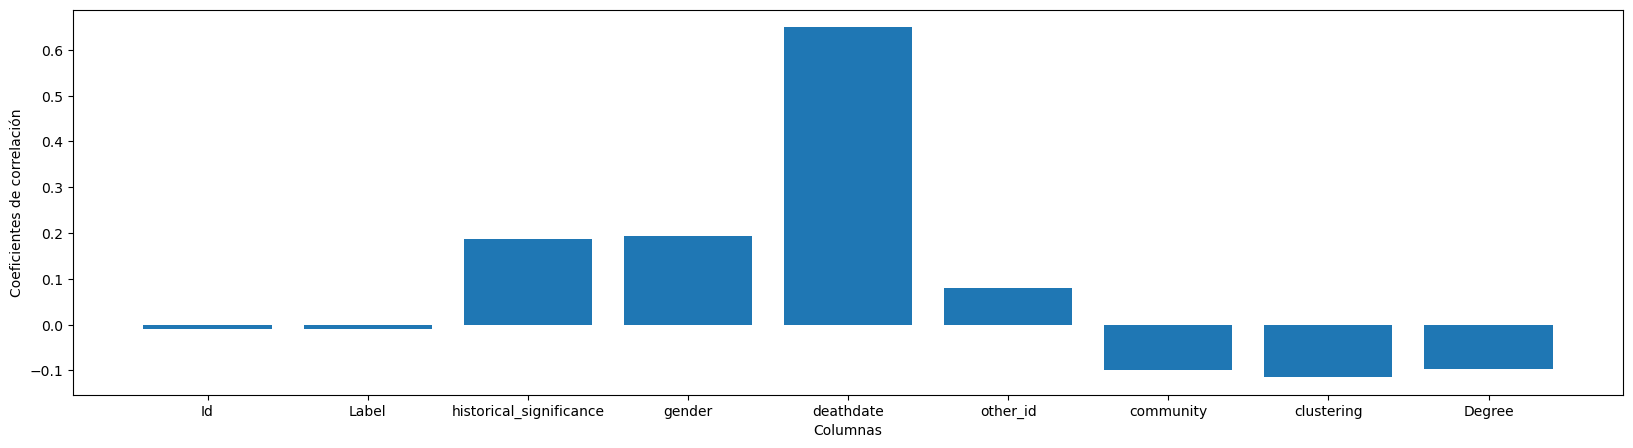

In [91]:
columnas=['Id','Label','historical_significance',
                              'gender', 'deathdate', 'other_id','community','clustering','Degree']
valores=[]
#Spearman, Pearson, kendall
for columna in columnas:
    corrSpe=analysis['birthdate'].corr(analysis[columna],method='spearman')
    valores.append(corrSpe)

pyplot.figure(figsize=(20,5))
pyplot.bar(x=columnas,height=valores,label=['Columnas','Coeficiente de correlación'])
pyplot.xlabel('Columnas')
pyplot.ylabel('Coeficientes de correlación')
pyplot.show()

Por lo que podemos observar, birthdate esta fuertemente correlacionada con deathdate, implicando que las personas que nacieron en un año determinado puede que murieran en el mismo año o similar. Con gender, historical_significance y other_id mantiene una correlación positiva pero baja, mientras que con el resto de atributos es una correlación negativa.

**Frecuencia:**

Tenemos un total de  57  valores distintos, y con la siguiente frecuencia
Birthdate más frecuente: 1630 , con una frecuencia de  6
Birthdate menos frecuente: 1638 , con una frecuencia de  1


<AxesSubplot:title={'center':'Frecuencia de valores distintos de birthdate'}, ylabel='birthdate'>

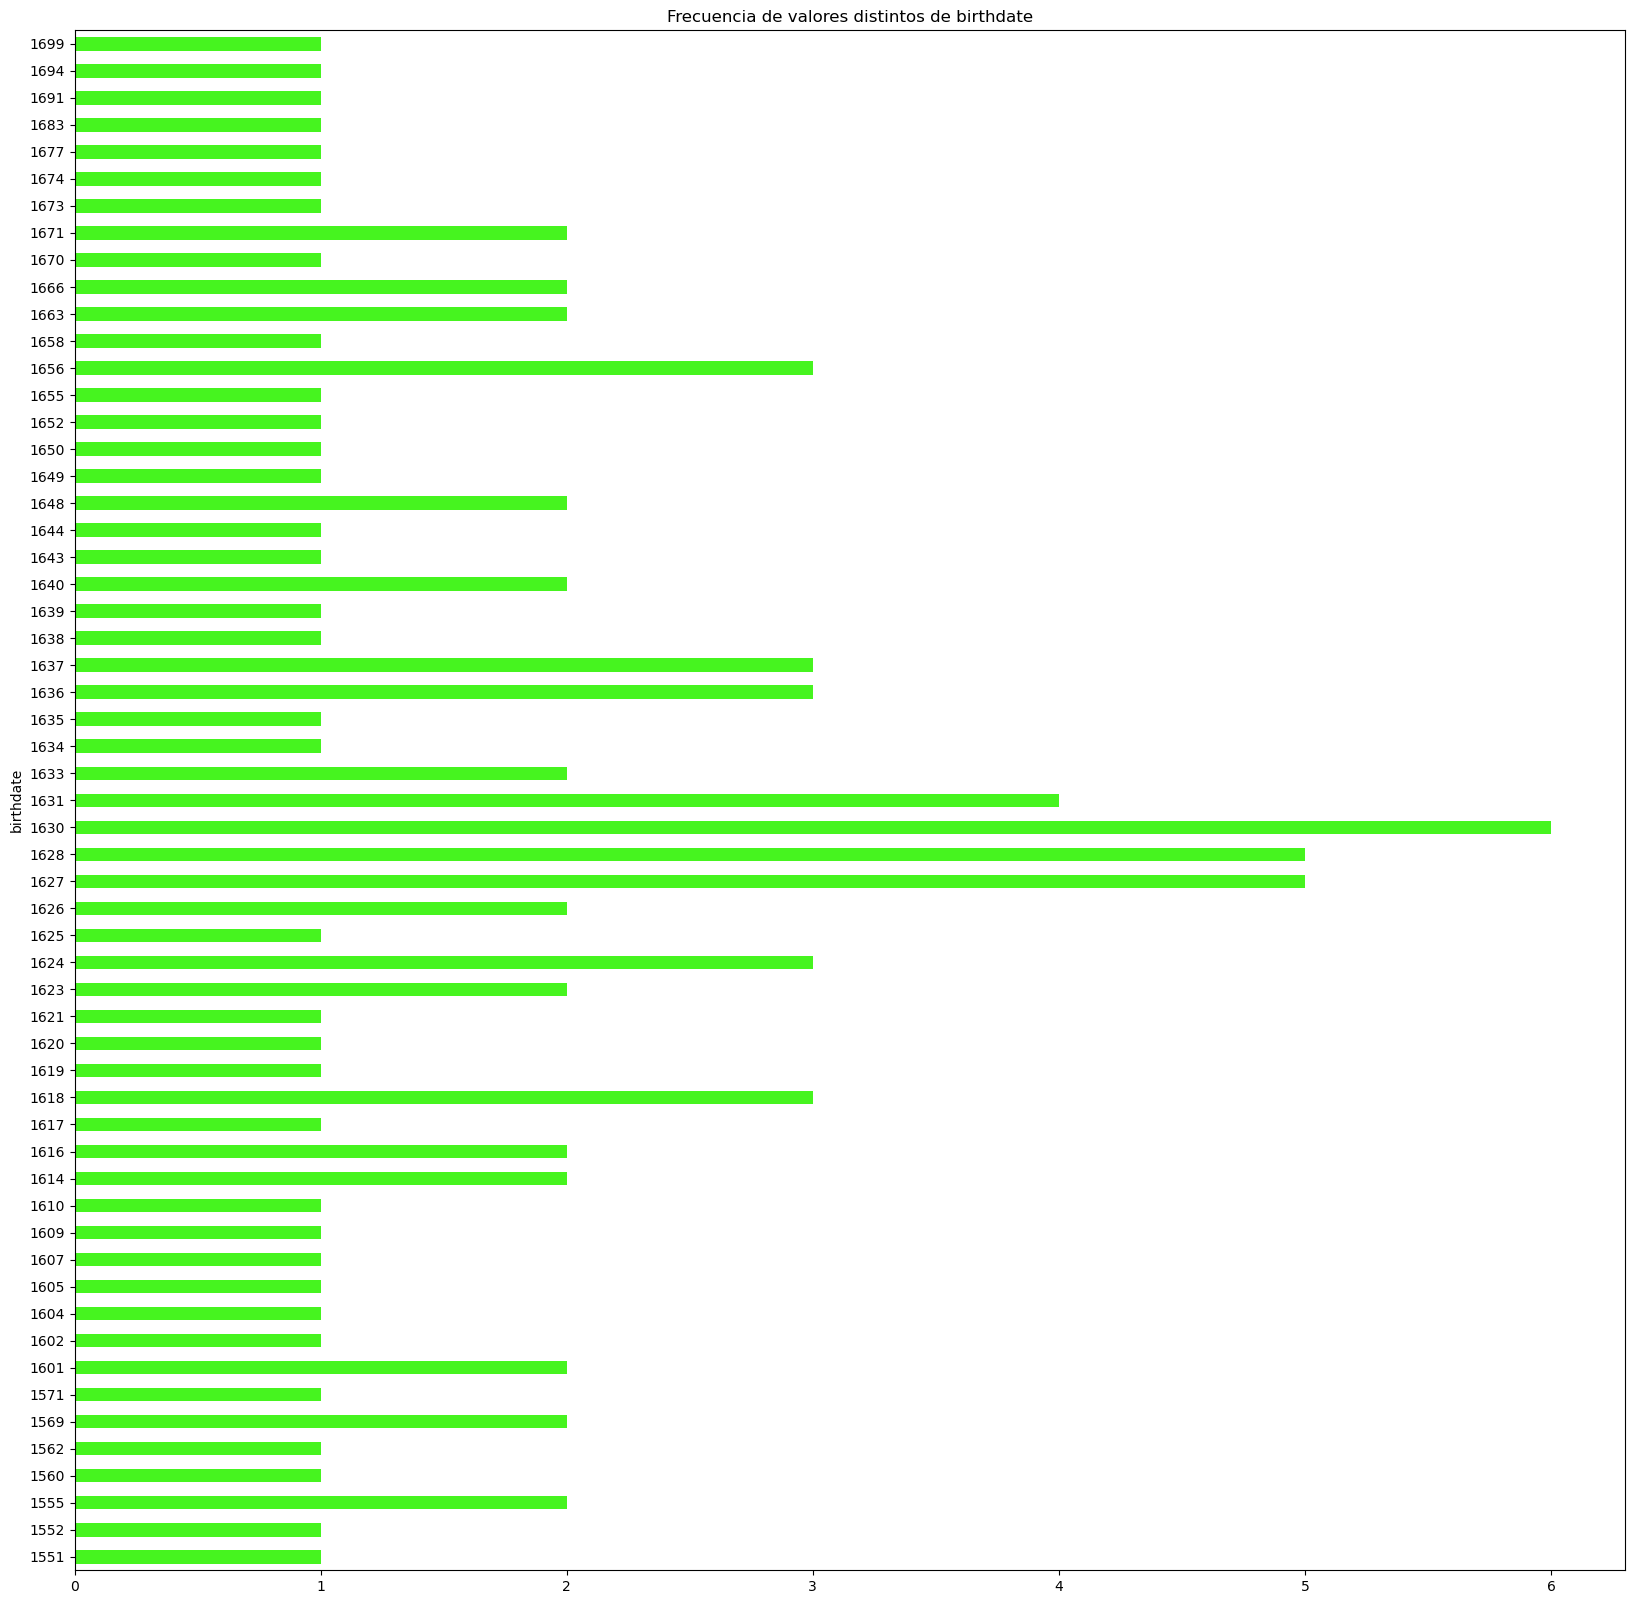

In [96]:
map_for_names={}
for i in range(0,analysis.shape[0]):
    clave=analysis.loc[i,'birthdate']
    if(clave in map_for_names.keys()):
        map_for_names[clave]+=1
    else:
        map_for_names[clave]=1
print("Tenemos un total de ",len(map_for_names.keys())," valores distintos, y con la siguiente frecuencia")
print("Birthdate más frecuente:",max(map_for_names,key=map_for_names.get),", con una frecuencia de ",max(map_for_names.values()))
print("Birthdate menos frecuente:",min(map_for_names,key=map_for_names.get),", con una frecuencia de ",min(map_for_names.values()))
analysis.groupby(['birthdate'])['birthdate'].count().plot(kind='barh',color='#46F41F',title='Frecuencia de valores distintos de birthdate',xlabel="birthdate",ylabel="Frecuencia",figsize=(20,20))

Tras este estudio, podemos decir que al tratarse birthdate de un atributo continuo y de tener un conjunto de datos pequeño, tenemos como resultado una gran cantidad de valores y una pequeña frecuencia de cada uno. Esto implica que casi todos los miembros de Quakers nacieron en años diferentes, y al estar altamente correlacionado con deathdate, esto implicaría que murieron los miembros en momentos similares.

**Probabilidad:**

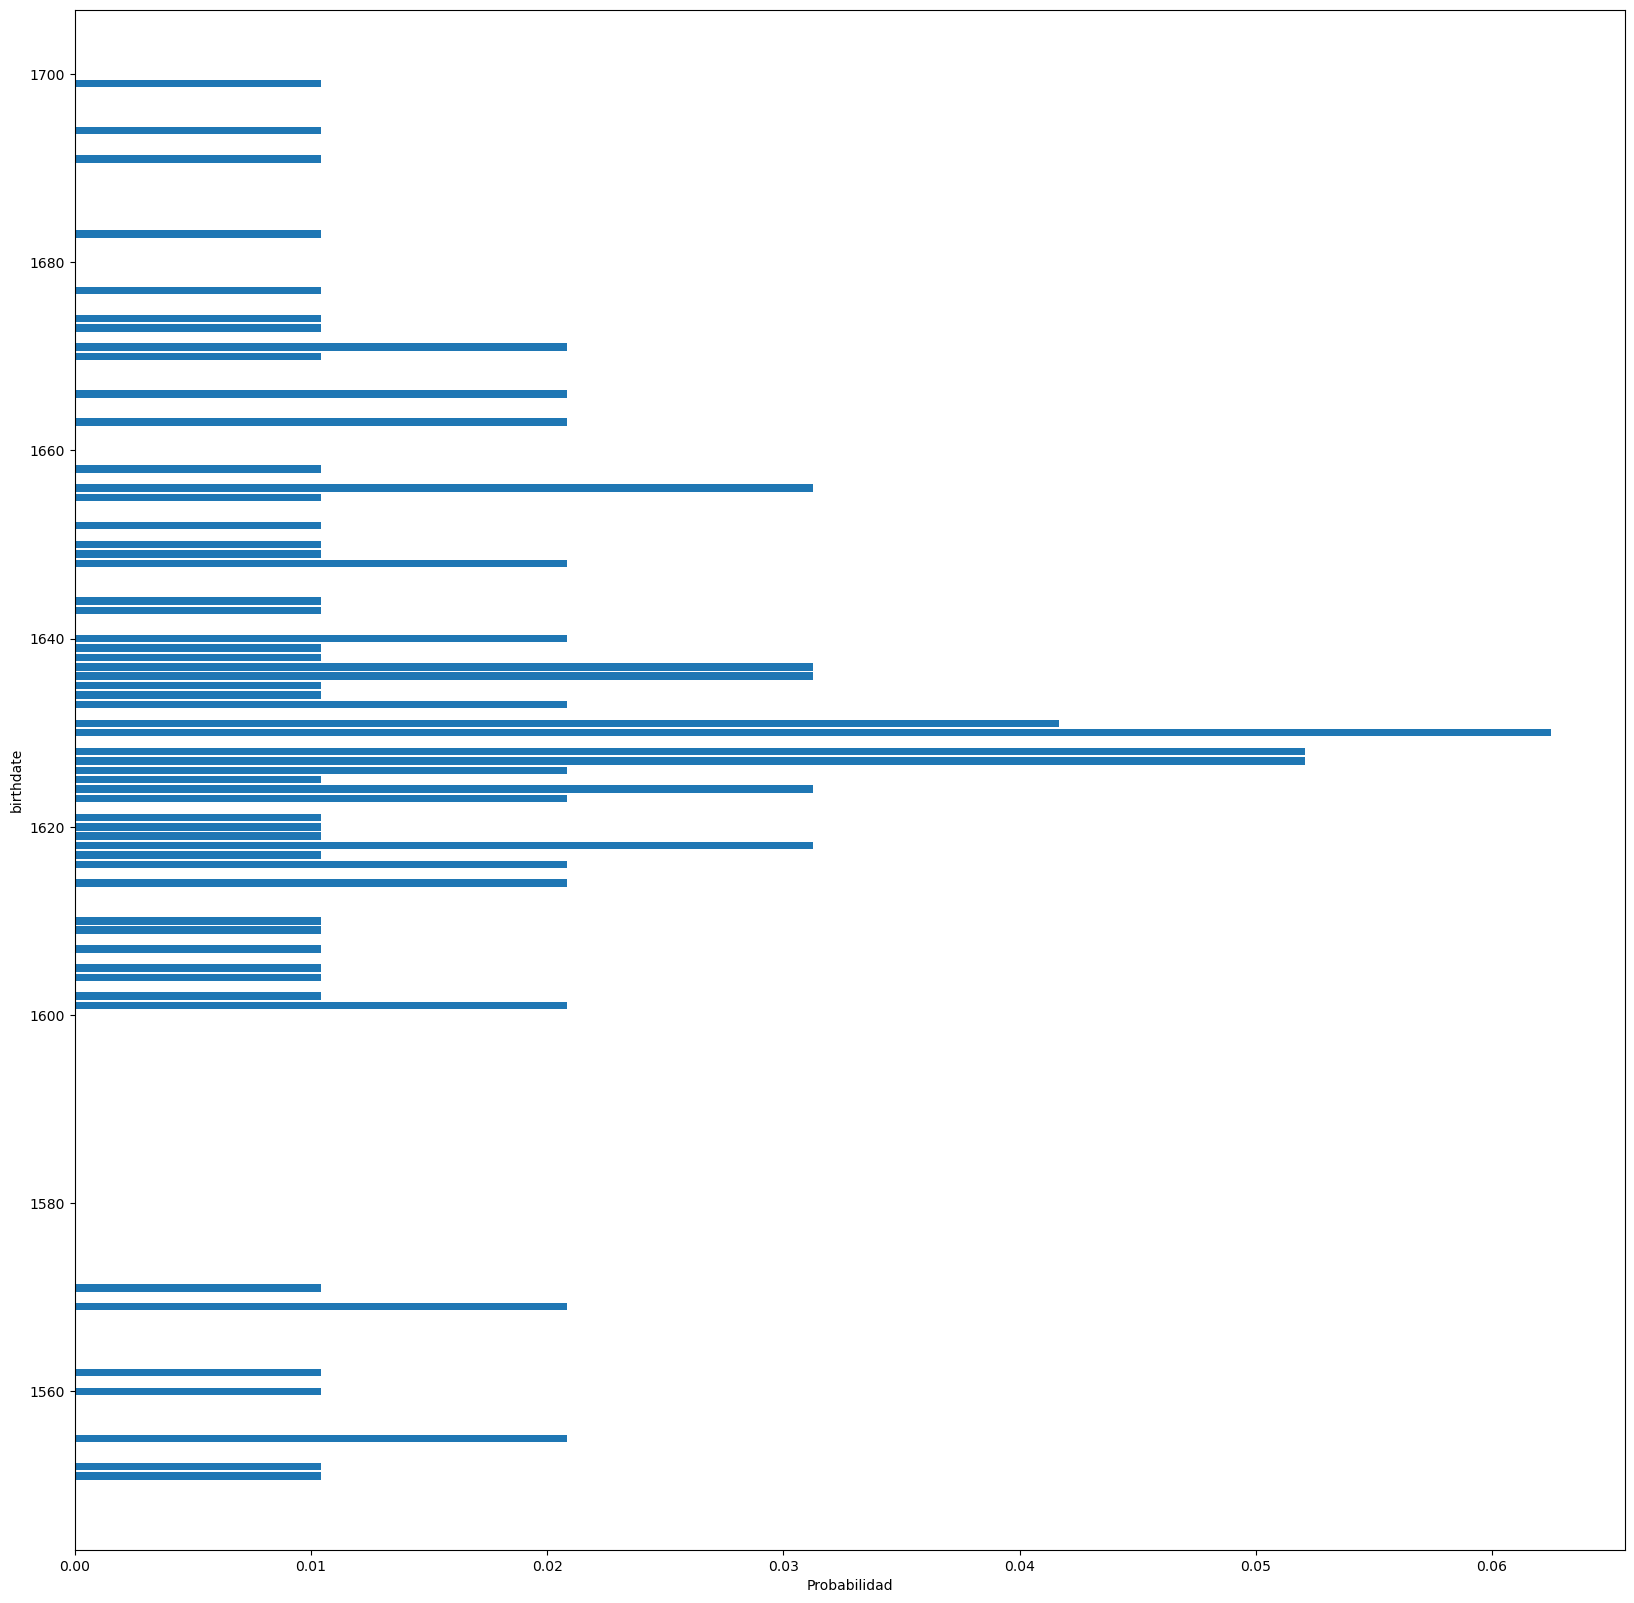

In [97]:
values=[x/96 for x in map_for_names.values()]
pyplot.figure(figsize=(20,20))
pyplot.barh(y=list(map_for_names.keys()),width=values)
pyplot.xlabel('Probabilidad')
pyplot.ylabel('birthdate')
pyplot.show()

A partir de estas probabilidades (y gracias a la distribución de las columnas), podemos determinar que la gran mayoria de miembros de Quakers nacieron a partir del año 1600, pero hubo miembros de Quakers que nacieron entorno al año 1550.

**Máxima frecuencia y mínima frecuencia:** El año 1630 es el año en donde más miembros de Quakers nacieron, y como el resto de miembro nacieron en años distintos, casi todos los años sólo aparecen una vez, por lo que no se puede estimar el año con menos miembros, pero si podemos decir que casi todos los miembros nacieron en años diferentes, lo que dificultaría la estimación de birthdate sobre modelos ML de regresión.

**Conclusión:**
- Como birthdate esta altamente correlacionado con deathdate, esto significa que si queremos hacer modelos de regresión sobre este atributo , el atributo principal que ayudará a la estimación será deathdate.
- Casi todos los miembros nacieron en años diferentes y durante intervalos de tiempo diferente (algunos sobre 1550, la gran mayoria sobre 1600 y otros muchos sobre 1650)

# 5º Análisis sobre deathdate:

**Correlación:**

C:\Users\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


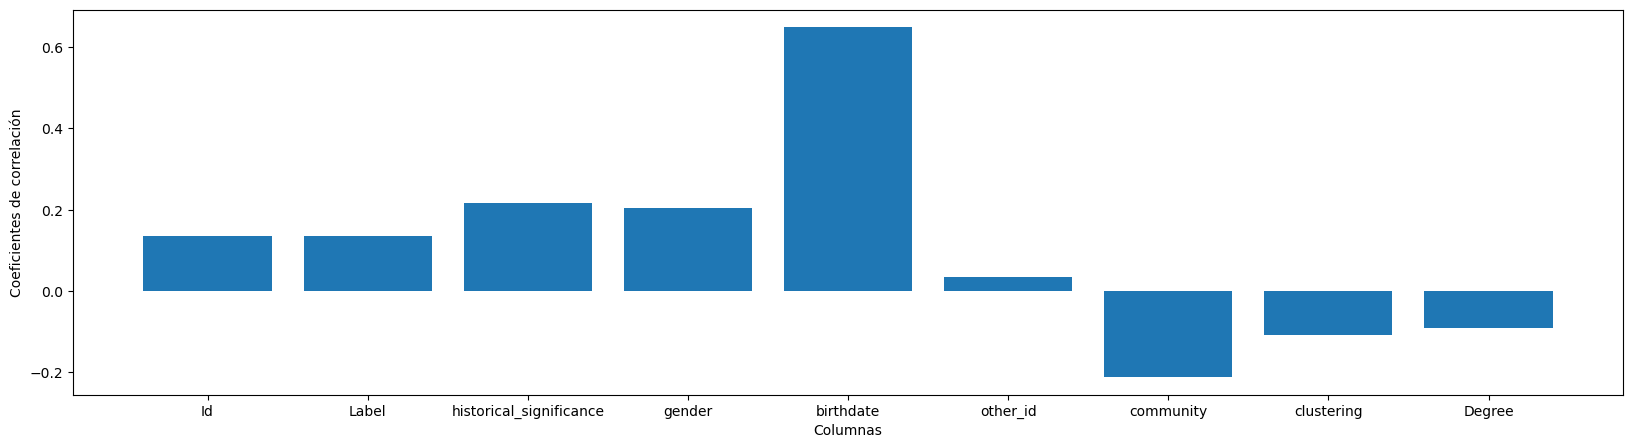

In [98]:
columnas=['Id','Label','historical_significance',
                              'gender', 'birthdate', 'other_id','community','clustering','Degree']
valores=[]
#Spearman, Pearson, kendall
for columna in columnas:
    corrSpe=analysis['deathdate'].corr(analysis[columna],method='spearman')
    valores.append(corrSpe)

pyplot.figure(figsize=(20,5))
pyplot.bar(x=columnas,height=valores,label=['Columnas','Coeficiente de correlación'])
pyplot.xlabel('Columnas')
pyplot.ylabel('Coeficientes de correlación')
pyplot.show()

Al analisar las columnas, podemos decir que deathdate también esta fuertemente correlacionado positivamente con birthdate, implicando que puede ser que los miembros que murieron en años similares nacieran en años similares también. Respecto al resto de atributos, con gender, historical_significance y other_id mantiene una correlación positiva pero baja, mientras que con el resto de atributos es una correlación negativa.

**Frecuencia:**

Tenemos un total de  64  valores distintos, y con la siguiente frecuencia
Deathdate más frecuente: 1679 , con una frecuencia de  6
Deathdate menos frecuente: 1716 , con una frecuencia de  1


<AxesSubplot:title={'center':'Frecuencia de valores distintos de deathdate'}, ylabel='deathdate'>

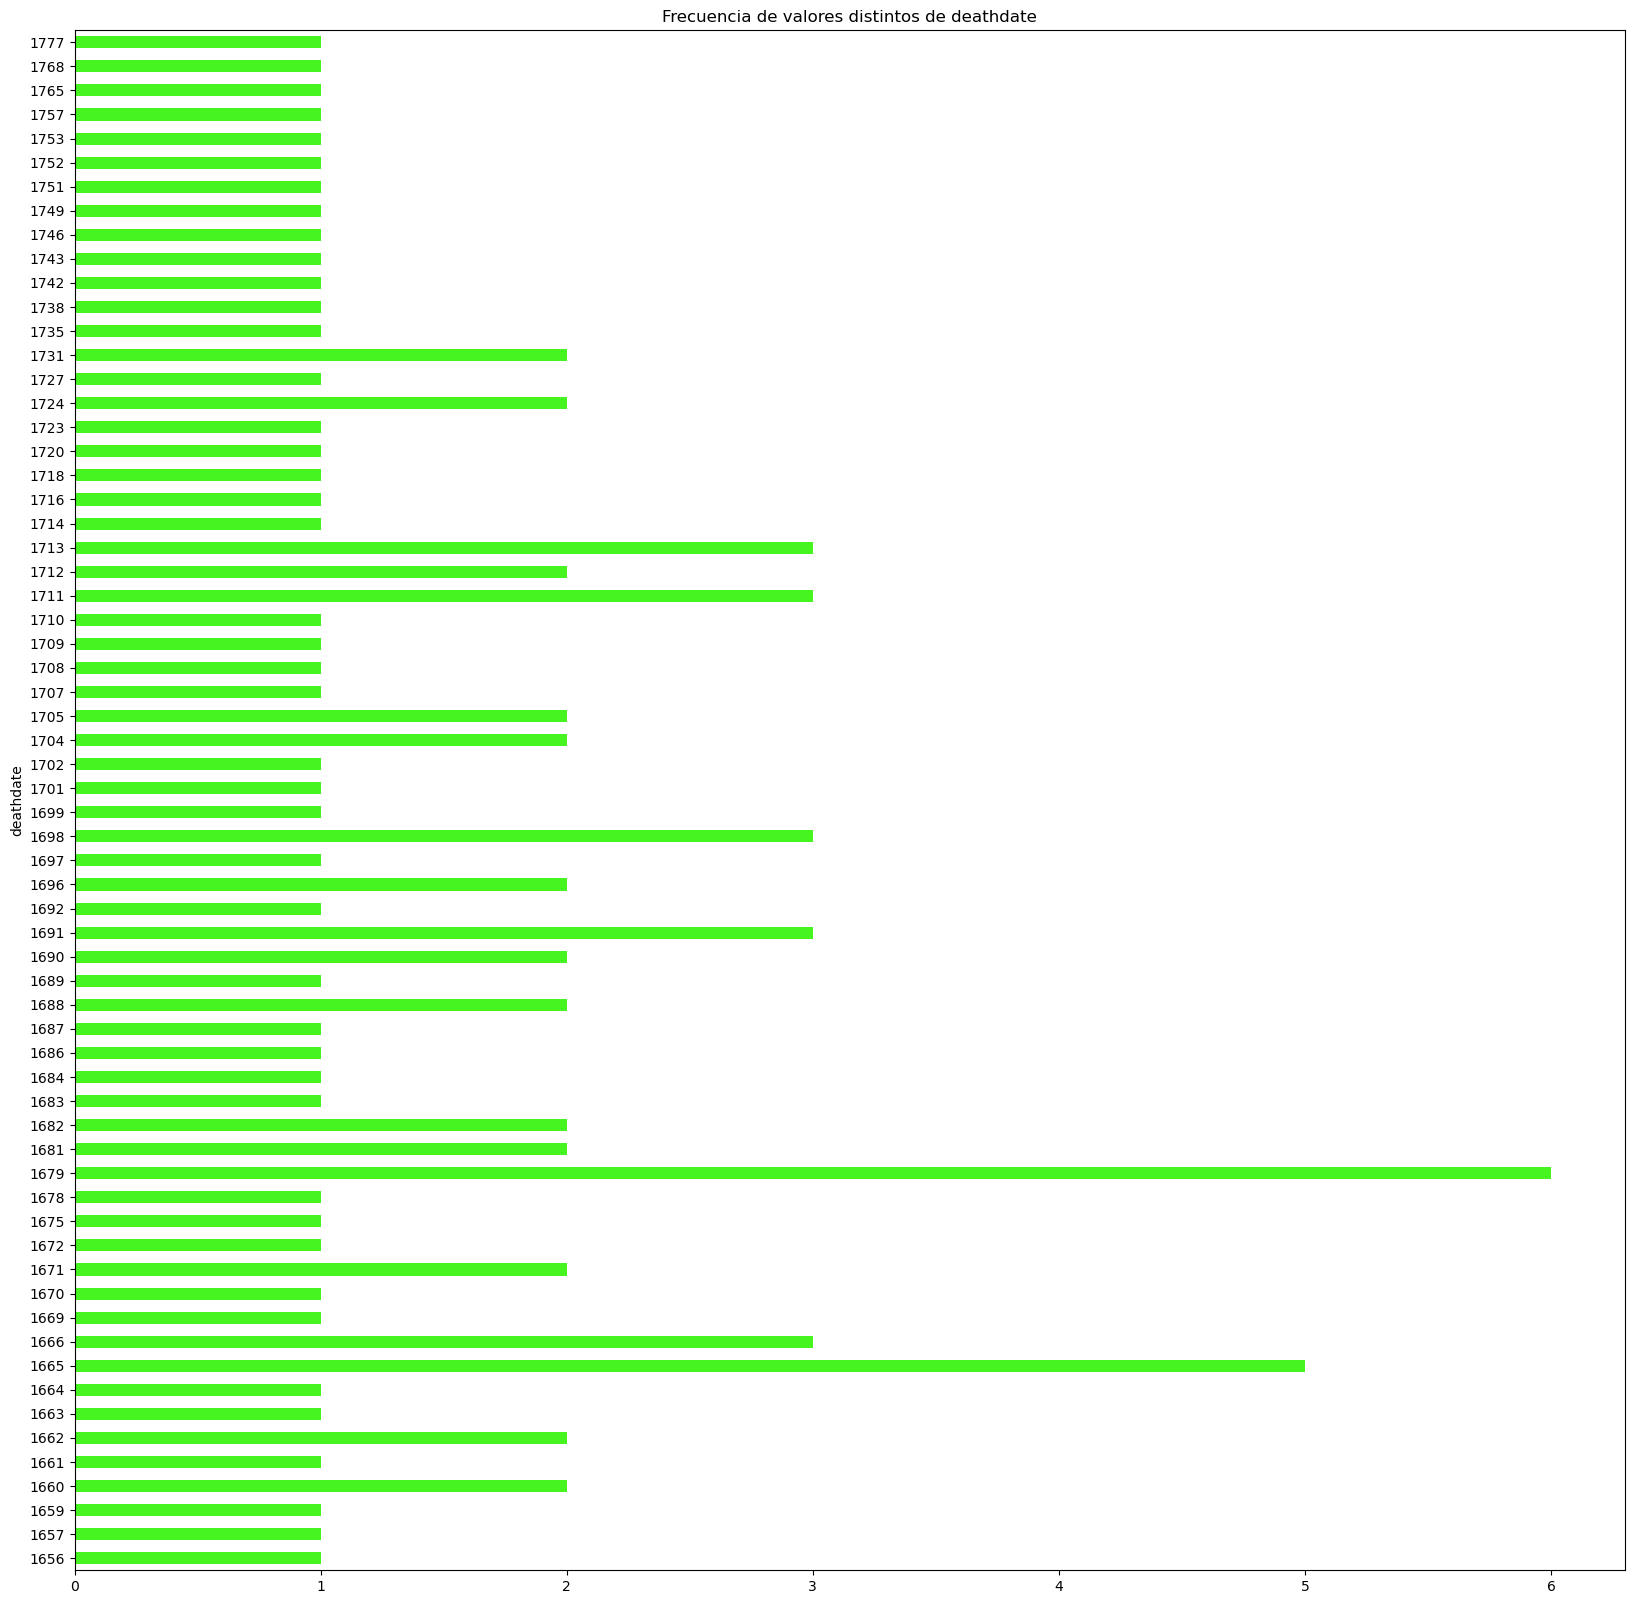

In [99]:
map_for_names={}
for i in range(0,analysis.shape[0]):
    clave=analysis.loc[i,'deathdate']
    if(clave in map_for_names.keys()):
        map_for_names[clave]+=1
    else:
        map_for_names[clave]=1
print("Tenemos un total de ",len(map_for_names.keys())," valores distintos, y con la siguiente frecuencia")
print("Deathdate más frecuente:",max(map_for_names,key=map_for_names.get),", con una frecuencia de ",max(map_for_names.values()))
print("Deathdate menos frecuente:",min(map_for_names,key=map_for_names.get),", con una frecuencia de ",min(map_for_names.values()))
analysis.groupby(['deathdate'])['deathdate'].count().plot(kind='barh',color='#46F41F',title='Frecuencia de valores distintos de deathdate',xlabel="deathdate",ylabel="Frecuencia",figsize=(20,20))

A partir del estudio de la frecuencia, podemos decir que casi todos los miembros murieron en años diferentes ya que hay muy poca frecuencia pero muchos años distintos.

**Probabilidad:**

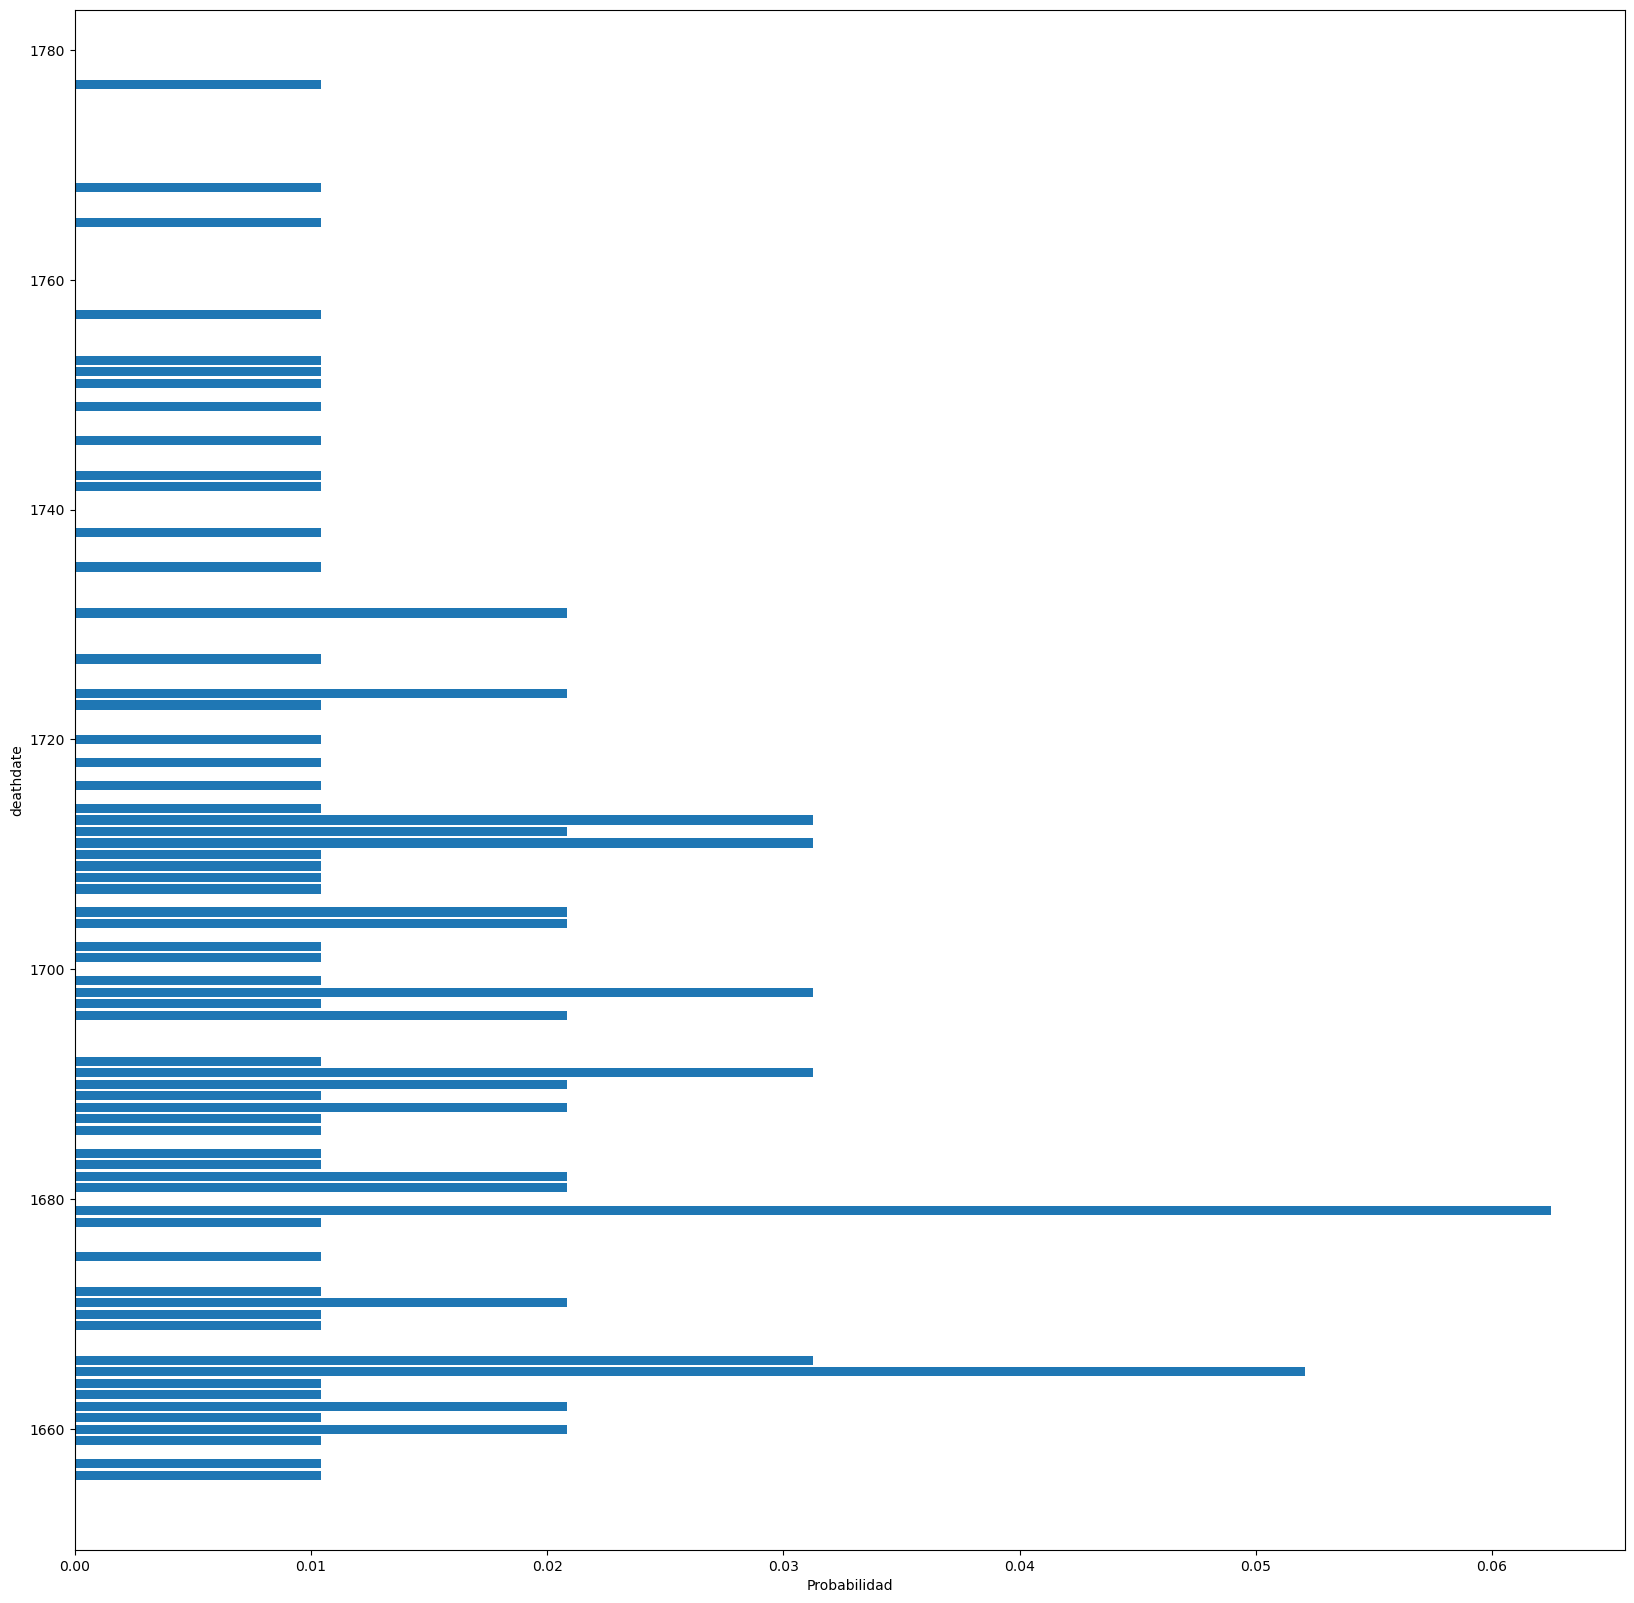

In [100]:
values=[x/96 for x in map_for_names.values()]
pyplot.figure(figsize=(20,20))
pyplot.barh(y=list(map_for_names.keys()),width=values)
pyplot.xlabel('Probabilidad')
pyplot.ylabel('deathdate')
pyplot.show()

Como hay tantos valores distintos de deathdate, las probabilidades son muy pequeñas, pero podemos decir que la gran mayoria de miembros de Quakers murieron entre los años 1730 y 1660

**Máxima frecuencia y mínima frecuencia:** Tras estudiar las frecuencias y probabilidades, podemos determinar que el año en el que murieron más personas fue 1679, en la que murieron 6 personas. Y no podemos determinar el año con frecuencia mínima porque hay muchos años con frecuencia 1, pero si podemos determinar una cosa,a partir del 1710 los miembros restantes de Quakers murieron en años con una gran diferencia entre ellos (las columnas no están tan pegadas)

**Conclusiones:**
- Al estar fuertemente correlacionados positivamente deathdate y birthdate, esto implica que ambos atributos son necesarios para estimarse mutuamente y que los miembros de Quakers murieron con años similares.
- Al tener muchos valores distintos y con tan poca frecuencia, realizar un modelo ML de regresión sobre este atributo daría resultado a un modelo con mal rendimiento

# 6º Análisis sobre other_id:

**Correlación:**

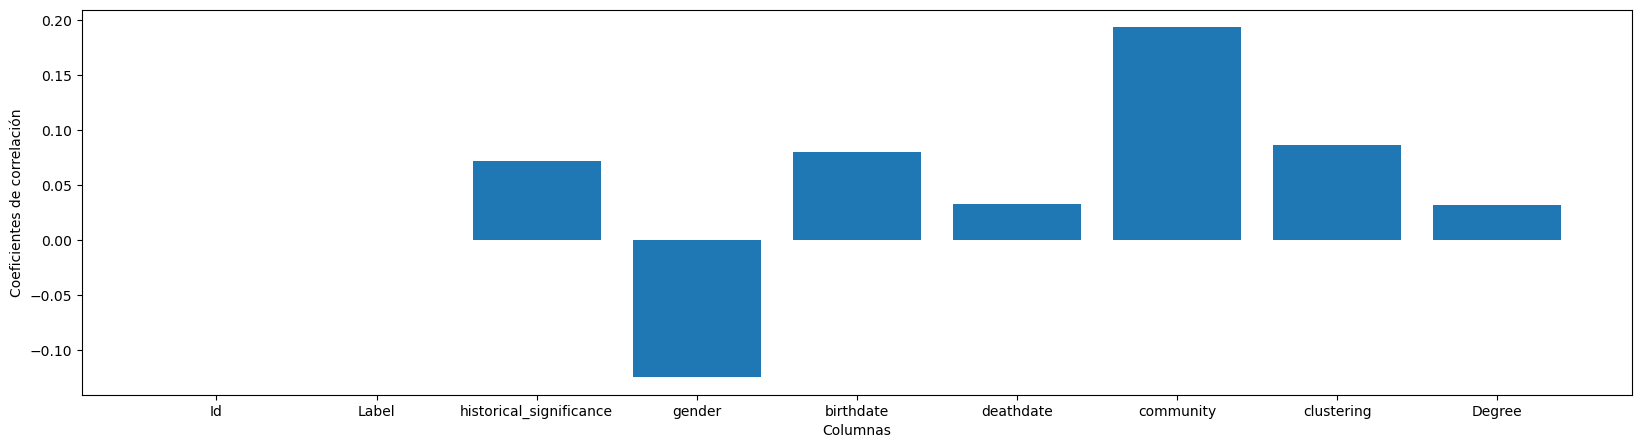

In [102]:
columnas=['Id','Label','historical_significance',
                              'gender','birthdate', 'deathdate','community','clustering','Degree']
valores=[]
#Spearman, Pearson, kendall
for columna in columnas:
    corrSpe=analysis['other_id'].corr(analysis[columna],method='spearman')
    valores.append(corrSpe)

pyplot.figure(figsize=(20,5))
pyplot.bar(x=columnas,height=valores,label=['Columnas','Coeficiente de correlación'])
pyplot.xlabel('Columnas')
pyplot.ylabel('Coeficientes de correlación')
pyplot.show()

Al analizar esto, podemos decir que other_id no esta apenas asociado a ningún atributo, ya que con Id y Label la asociación es nula, con gender es negativa (implicando que other_id no se puede utilizar para predecir gender) y con el resto es muy débil la asociación (entre 0 y 0.2). Como este atributo no es obligatorio, si nos sigue dando problemas lo quitaremos

**Frecuencia:**

Tenemos un total de  96  valores distintos, y con la siguiente frecuencia
other_id más frecuente: 10006784 , con una frecuencia de  1
other_id menos frecuente: 10006784 , con una frecuencia de  1


<AxesSubplot:title={'center':'Frecuencia de valores distintos de other_id'}, ylabel='other_id'>

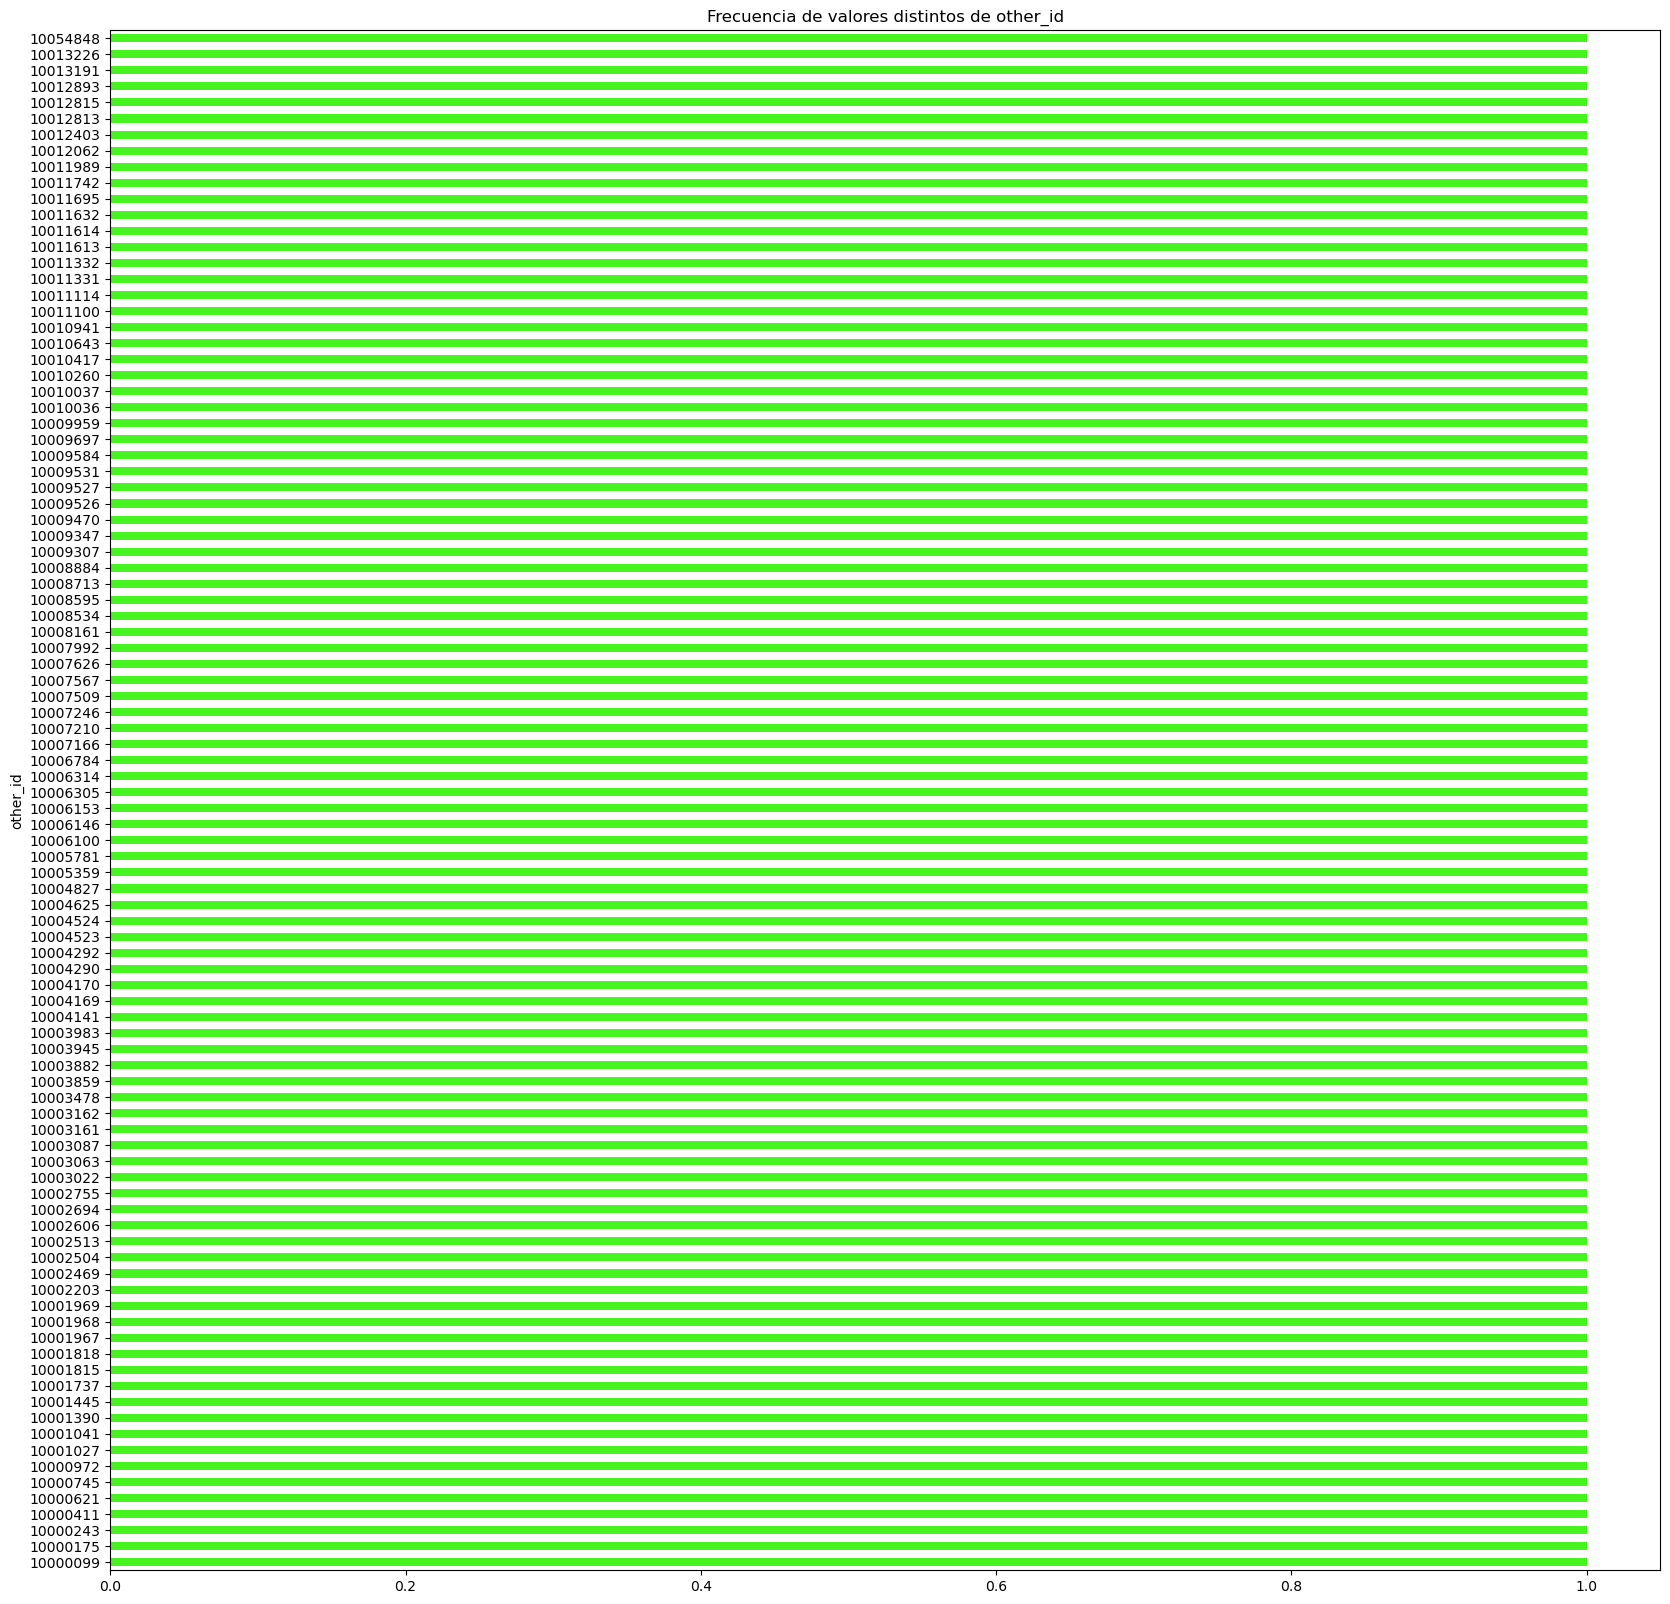

In [103]:
map_for_names={}
for i in range(0,analysis.shape[0]):
    clave=analysis.loc[i,'other_id']
    if(clave in map_for_names.keys()):
        map_for_names[clave]+=1
    else:
        map_for_names[clave]=1
print("Tenemos un total de ",len(map_for_names.keys())," valores distintos, y con la siguiente frecuencia")
print("other_id más frecuente:",max(map_for_names,key=map_for_names.get),", con una frecuencia de ",max(map_for_names.values()))
print("other_id menos frecuente:",min(map_for_names,key=map_for_names.get),", con una frecuencia de ",min(map_for_names.values()))
analysis.groupby(['other_id'])['other_id'].count().plot(kind='barh',color='#46F41F',title='Frecuencia de valores distintos de other_id',xlabel="other_id",ylabel="Frecuencia",figsize=(20,20))

Tenemos un total de 96 valores distintos, teniendo para cada valor sólo 1 aparición. Esto implica que la probabilidad de este atributo va a ser la mínima posible, por lo que no va a ser necesario mostrar la estimación de las probabilidades, y como todos los valores sólo aparecen una vez, no es posible estimar el valor con máxima frecuencia o con mínima frecuencia.

**Conclusión:**
- Este atributo al estar poco correlacionado con el resto de atributos no nos sirve ni para modelos ML que estimen otros atributos ni para modelos ML que estimen other_id. Y como no es uno de los atributos que ha mencionado el profesor, podemos eliminarlo
- Como tenemos tantos valores distintos, no podemos obtener información

# 7º Análisis sobre community:

**Correlación:**

C:\Users\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


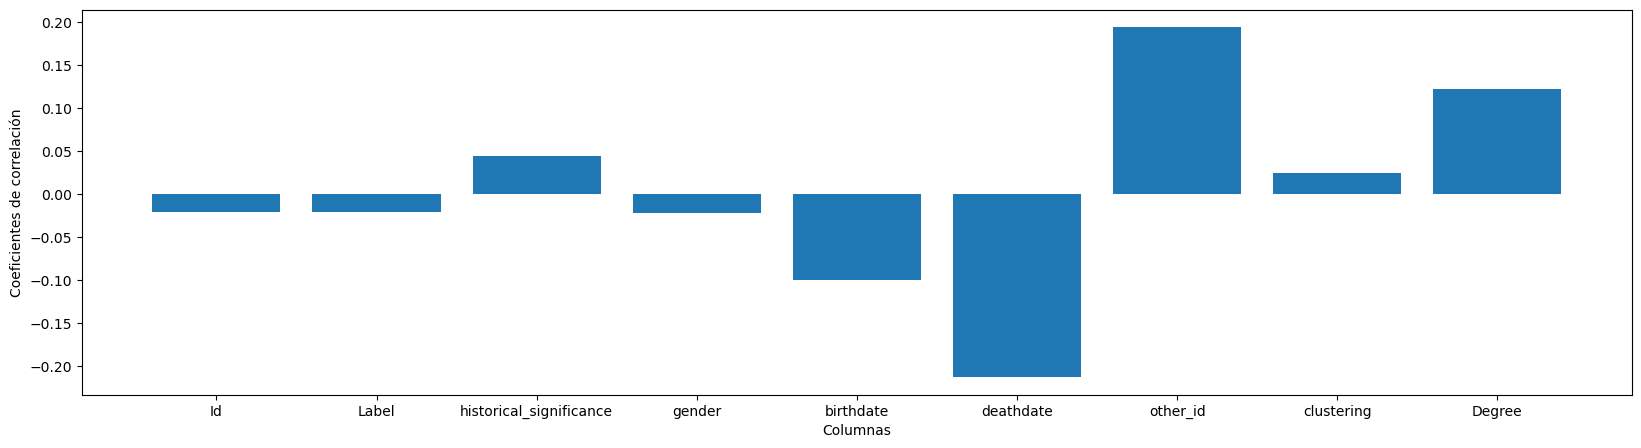

In [104]:
columnas=['Id','Label','historical_significance',
                              'gender', 'birthdate','deathdate', 'other_id','clustering','Degree']
valores=[]
#Spearman, Pearson, kendall
for columna in columnas:
    corrSpe=analysis['community'].corr(analysis[columna],method='spearman')
    valores.append(corrSpe)

pyplot.figure(figsize=(20,5))
pyplot.bar(x=columnas,height=valores,label=['Columnas','Coeficiente de correlación'])
pyplot.xlabel('Columnas')
pyplot.ylabel('Coeficientes de correlación')
pyplot.show()

Podemos decir que la métrica de las comunidades presenta asociaciones negativas con Id, Label, gender, birthdate y deathdate, y asociaciones positivas pero pequeñas con other_id, clustering y Degree. Esto implica que este atributo es malo para predecir el resto de atributos y viceversa

**Frecuencia:**

Tenemos un total de  8  valores distintos, y con la siguiente frecuencia
community más frecuente: comunidad-1 , con una frecuencia de  21
community menos frecuente: comunidad-7 , con una frecuencia de  7


<AxesSubplot:title={'center':'Frecuencia de valores distintos de community'}, ylabel='community'>

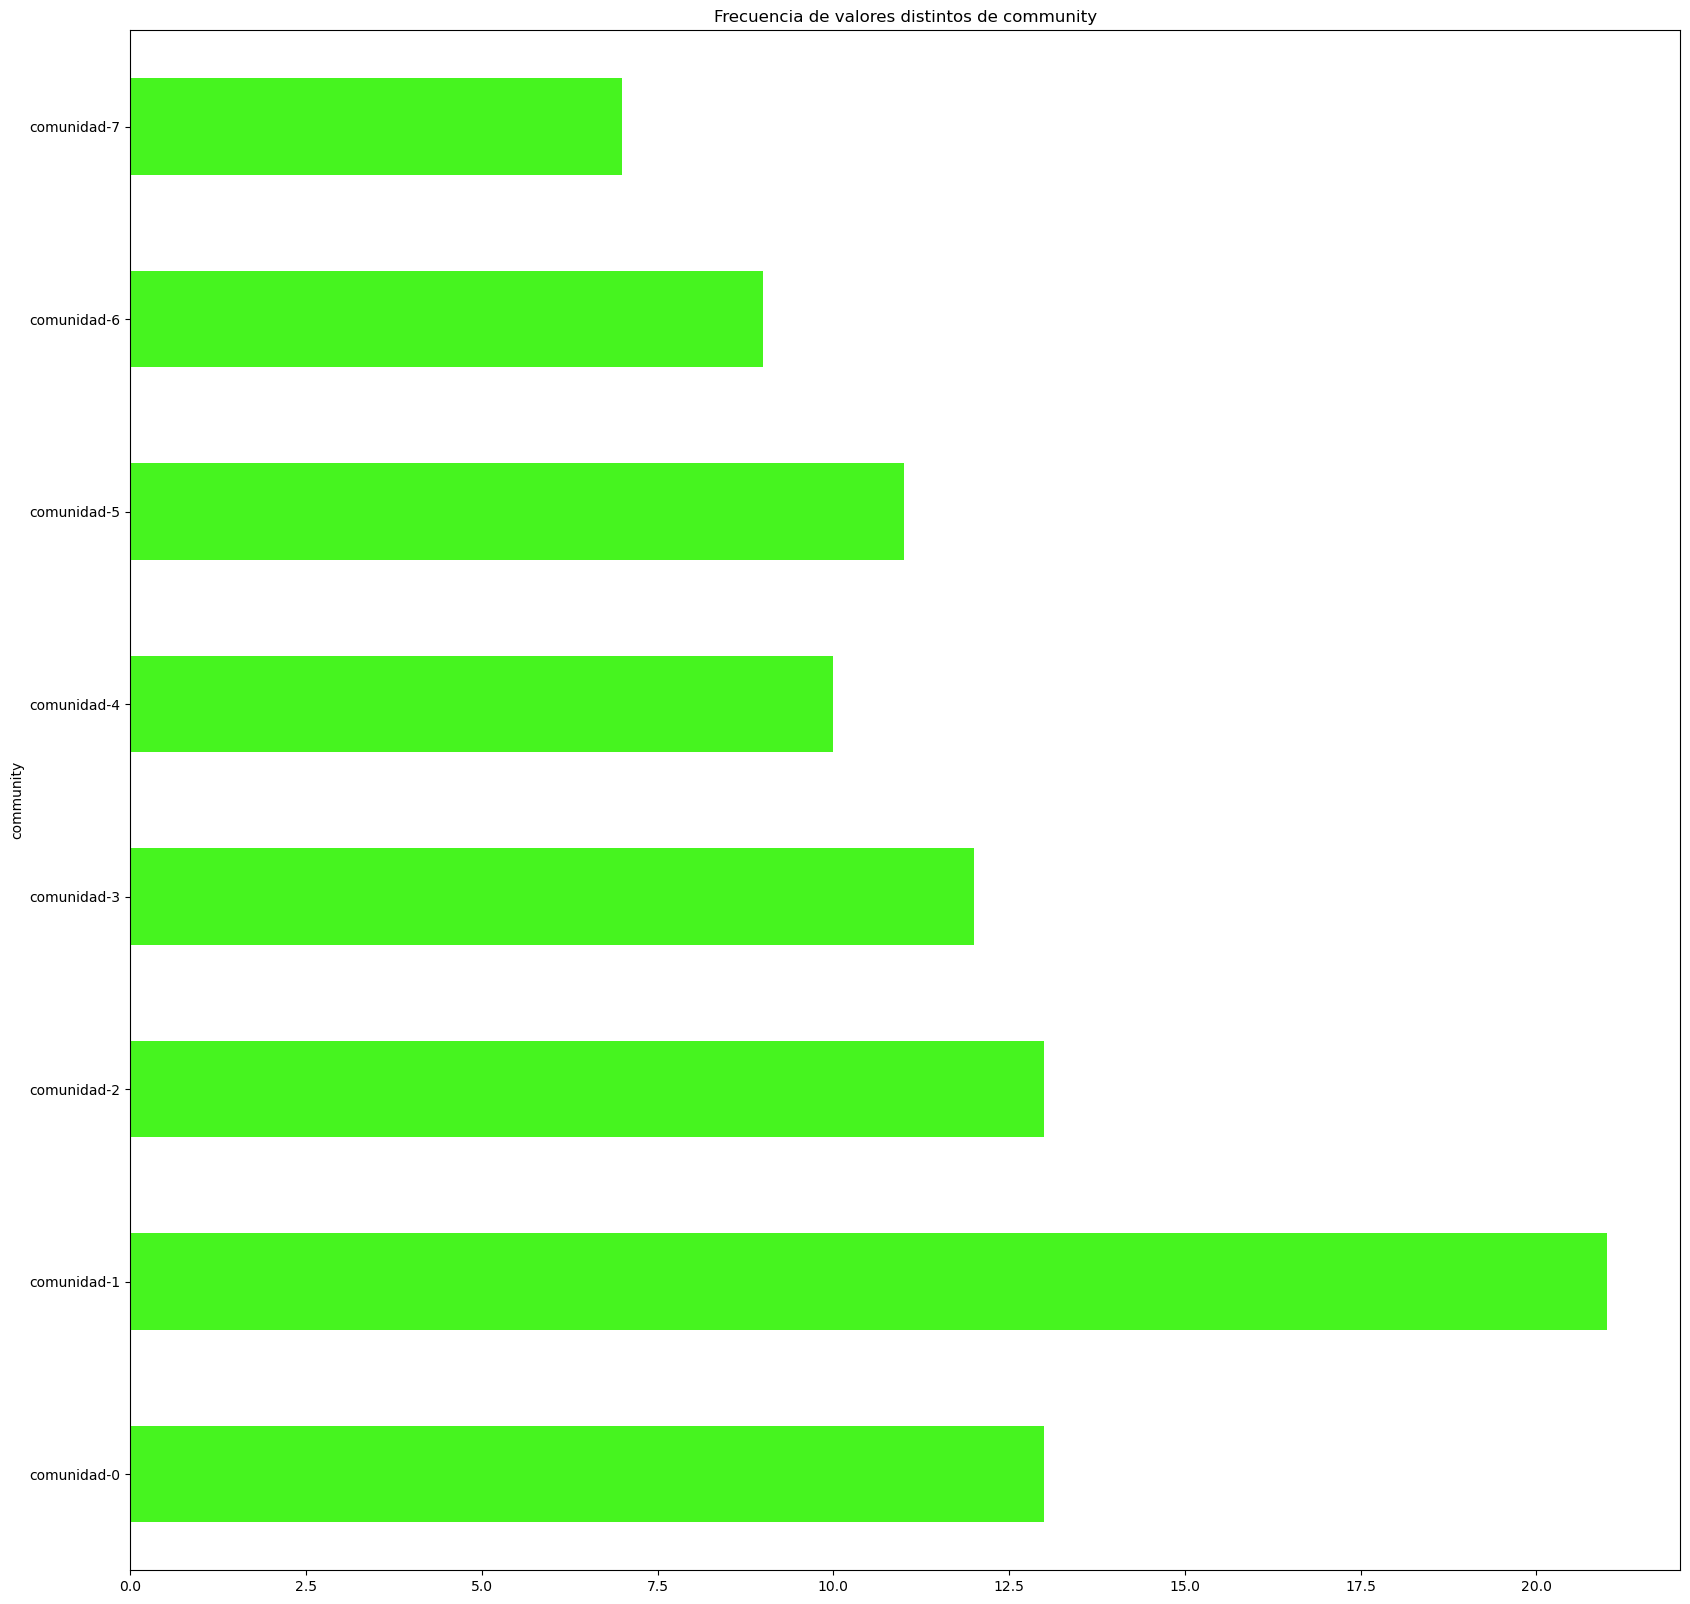

In [105]:
map_for_names={}
for i in range(0,analysis.shape[0]):
    clave=analysis.loc[i,'community']
    if(clave in map_for_names.keys()):
        map_for_names[clave]+=1
    else:
        map_for_names[clave]=1
print("Tenemos un total de ",len(map_for_names.keys())," valores distintos, y con la siguiente frecuencia")
print("community más frecuente:",max(map_for_names,key=map_for_names.get),", con una frecuencia de ",max(map_for_names.values()))
print("community menos frecuente:",min(map_for_names,key=map_for_names.get),", con una frecuencia de ",min(map_for_names.values()))
analysis.groupby(['community'])['community'].count().plot(kind='barh',color='#46F41F',title='Frecuencia de valores distintos de community',xlabel="community",ylabel="Frecuencia",figsize=(20,20))

Como hay pocos ejemplos pero pocas comunidades, la frecuencia que aparece son muy distintas entre si, pudiendo notar frecuencias máximas y mínimas.

**Probabilidad:**

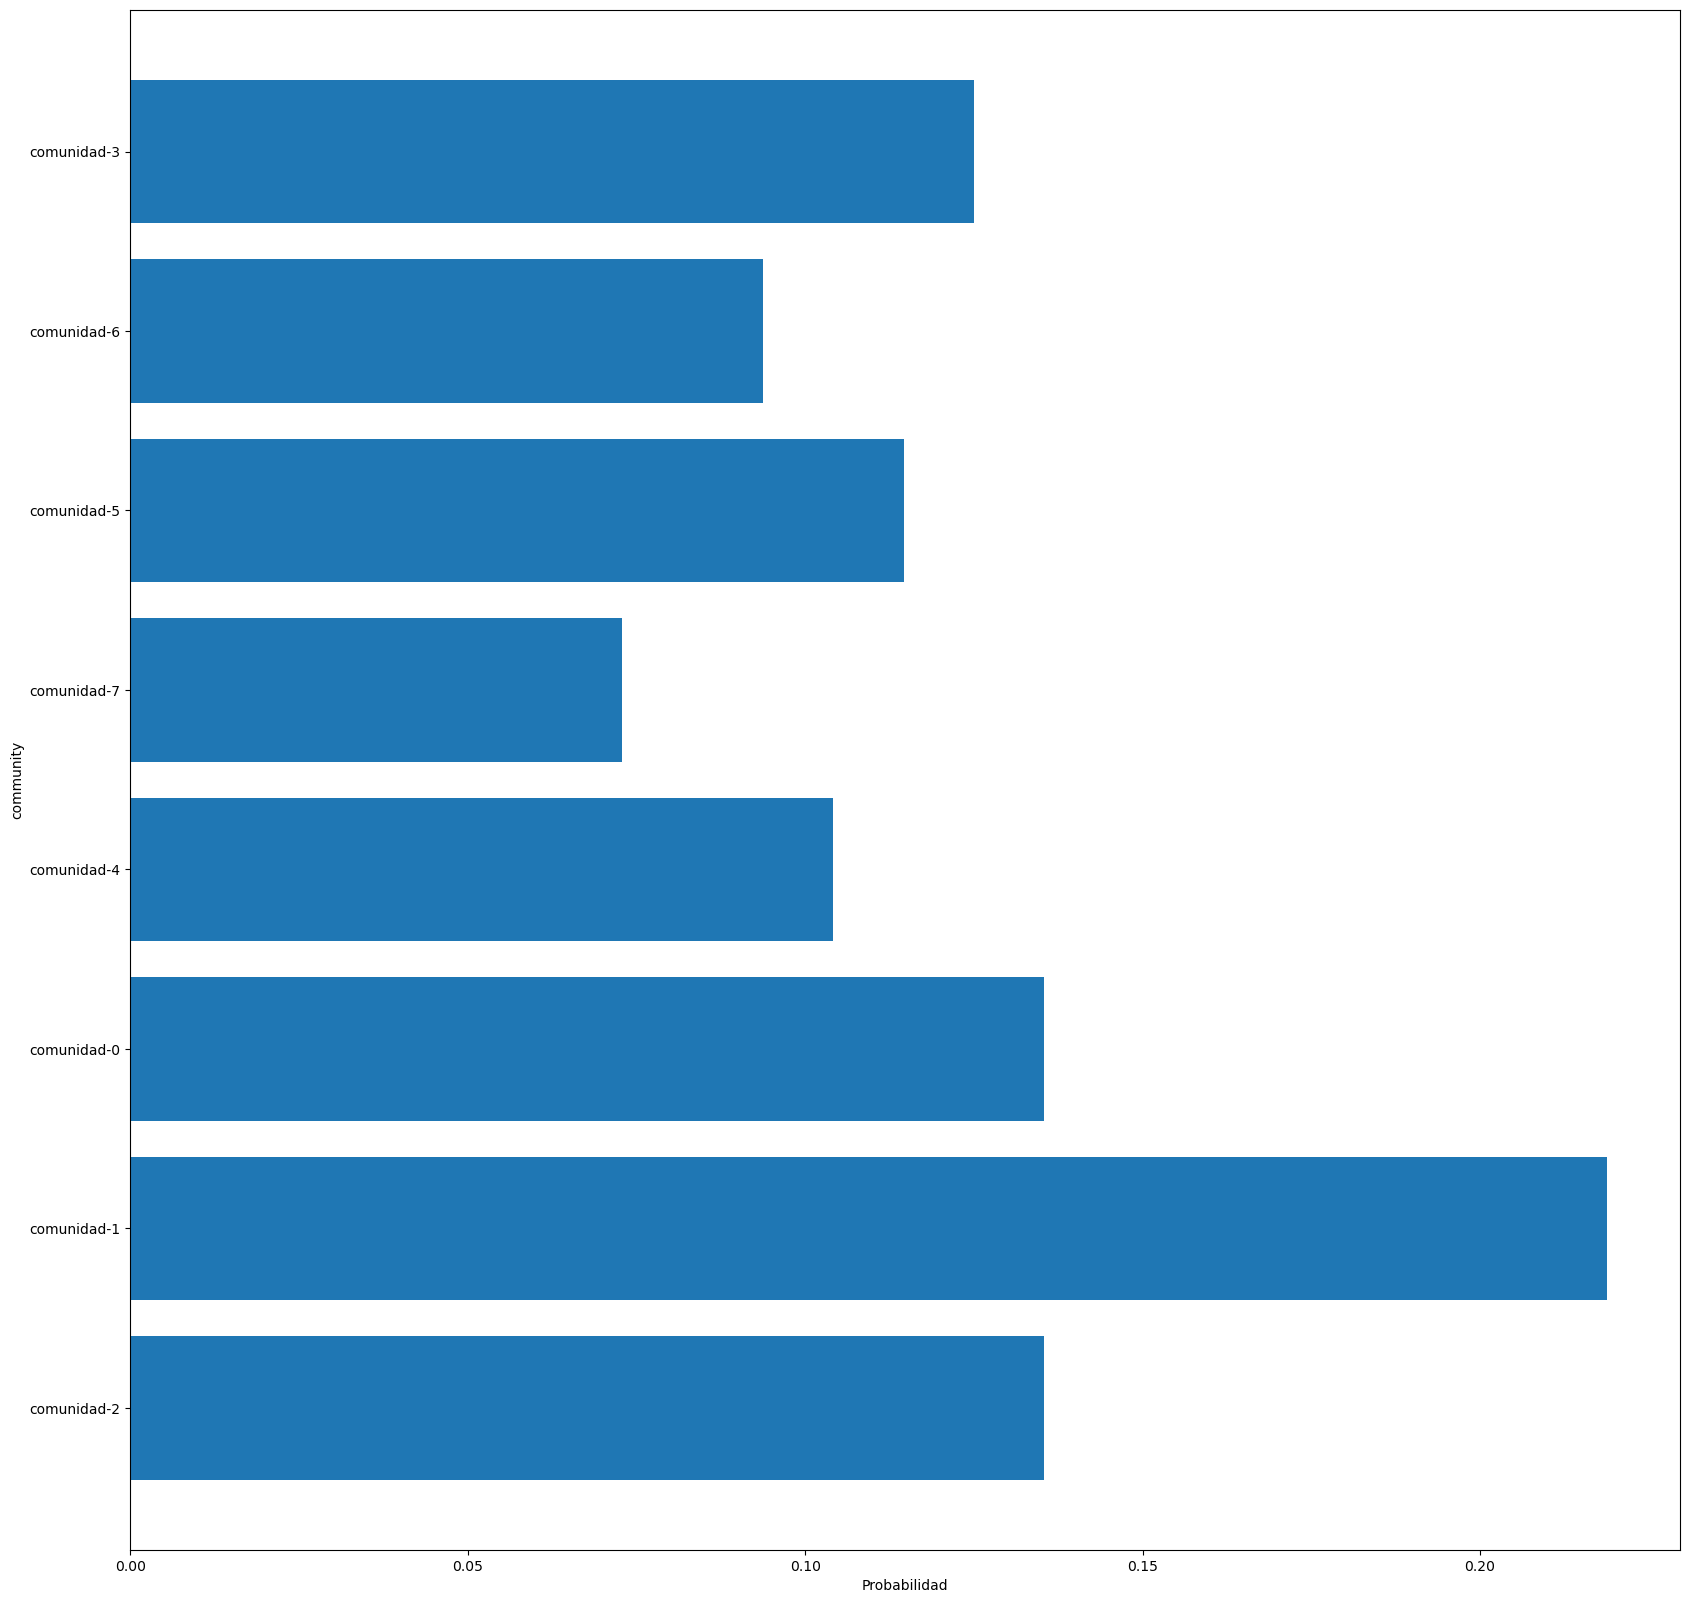

In [106]:
values=[x/96 for x in map_for_names.values()]
pyplot.figure(figsize=(20,20))
pyplot.barh(y=list(map_for_names.keys()),width=values)
pyplot.xlabel('Probabilidad')
pyplot.ylabel('community')
pyplot.show()

A partir de la probabilidad estimamos que al tratarse de pocas comunidades y pocos ejemplos, las probabilidades son buenas.

**Máxima frecuencia y mínima frecuencia:**
La comunidad más frecuente es la comunidad 1, y la comunidad menos frecuente es la comunidad 7

**Conclusión:**
- La métrica de detección de comunidades no es útil para estos datos, ya que no esta muy asociado al resto de atributos
- Al tener pocos datos y pocas comunidades, la frecuencia y probabilidad están bien repartidas y hay variedad, pero al no estar bien asociado con los demás atributos, podemos llegar a la conclusión de que no es una métrica que deberíamos utilizar para la creación de modelos ML.

Como es una métrica solicitada por el proyecto, no la vamos a quitar, pero deberíamos utilizar otra más útil.

# 8º Análisis sobre clustering(grado de agrupamiento):

**Correlación:**

C:\Users\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


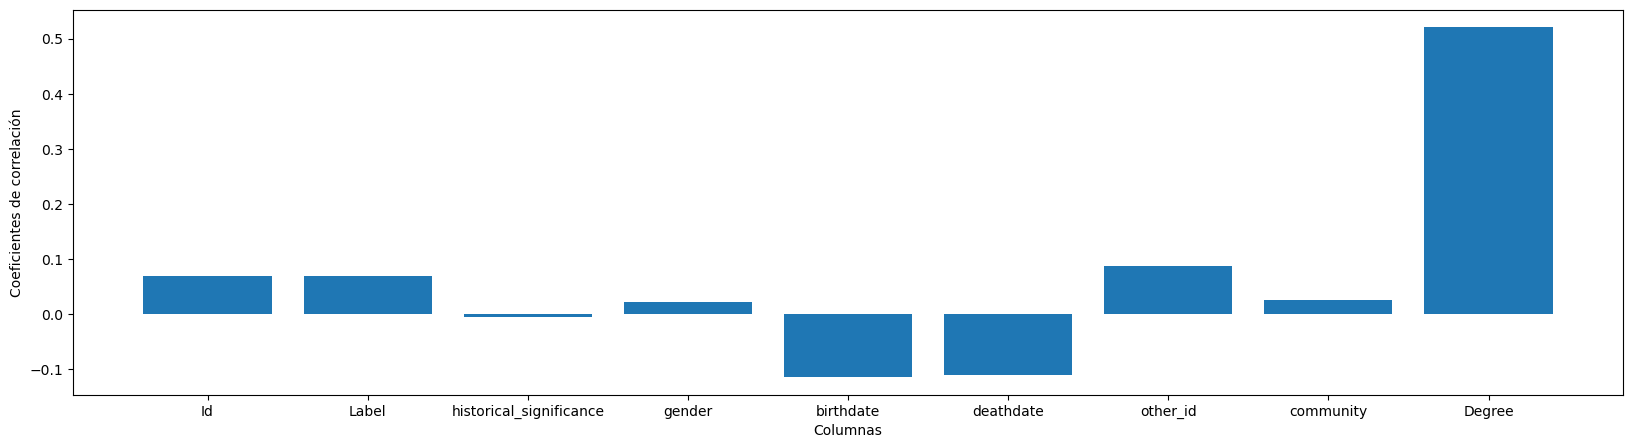

In [107]:
columnas=['Id','Label','historical_significance',
                              'gender', 'birthdate','deathdate', 'other_id','community','Degree']
valores=[]
#Spearman, Pearson, kendall
for columna in columnas:
    corrSpe=analysis['clustering'].corr(analysis[columna],method='spearman')
    valores.append(corrSpe)

pyplot.figure(figsize=(20,5))
pyplot.bar(x=columnas,height=valores,label=['Columnas','Coeficiente de correlación'])
pyplot.xlabel('Columnas')
pyplot.ylabel('Coeficientes de correlación')
pyplot.show()

Podemos observar que el clustering presenta una asociación positiva media con Degree, implicando que algunos grados de clustering tendrán Degrees similares y viceversa. También presenta asociaciones positivas con other_id, community, Label, Id, historical_significance y gender, pero son débiles, y con el resto de atributos presenta asociación negativa.

**Frecuencia:**

Tenemos un total de  18  valores distintos, y con la siguiente frecuencia
clustering más frecuente: 0.0 , con una frecuencia de  47
clustering menos frecuente: 0.2857142857142857 , con una frecuencia de  1


<AxesSubplot:title={'center':'Frecuencia de valores distintos de clustering'}, ylabel='clustering'>

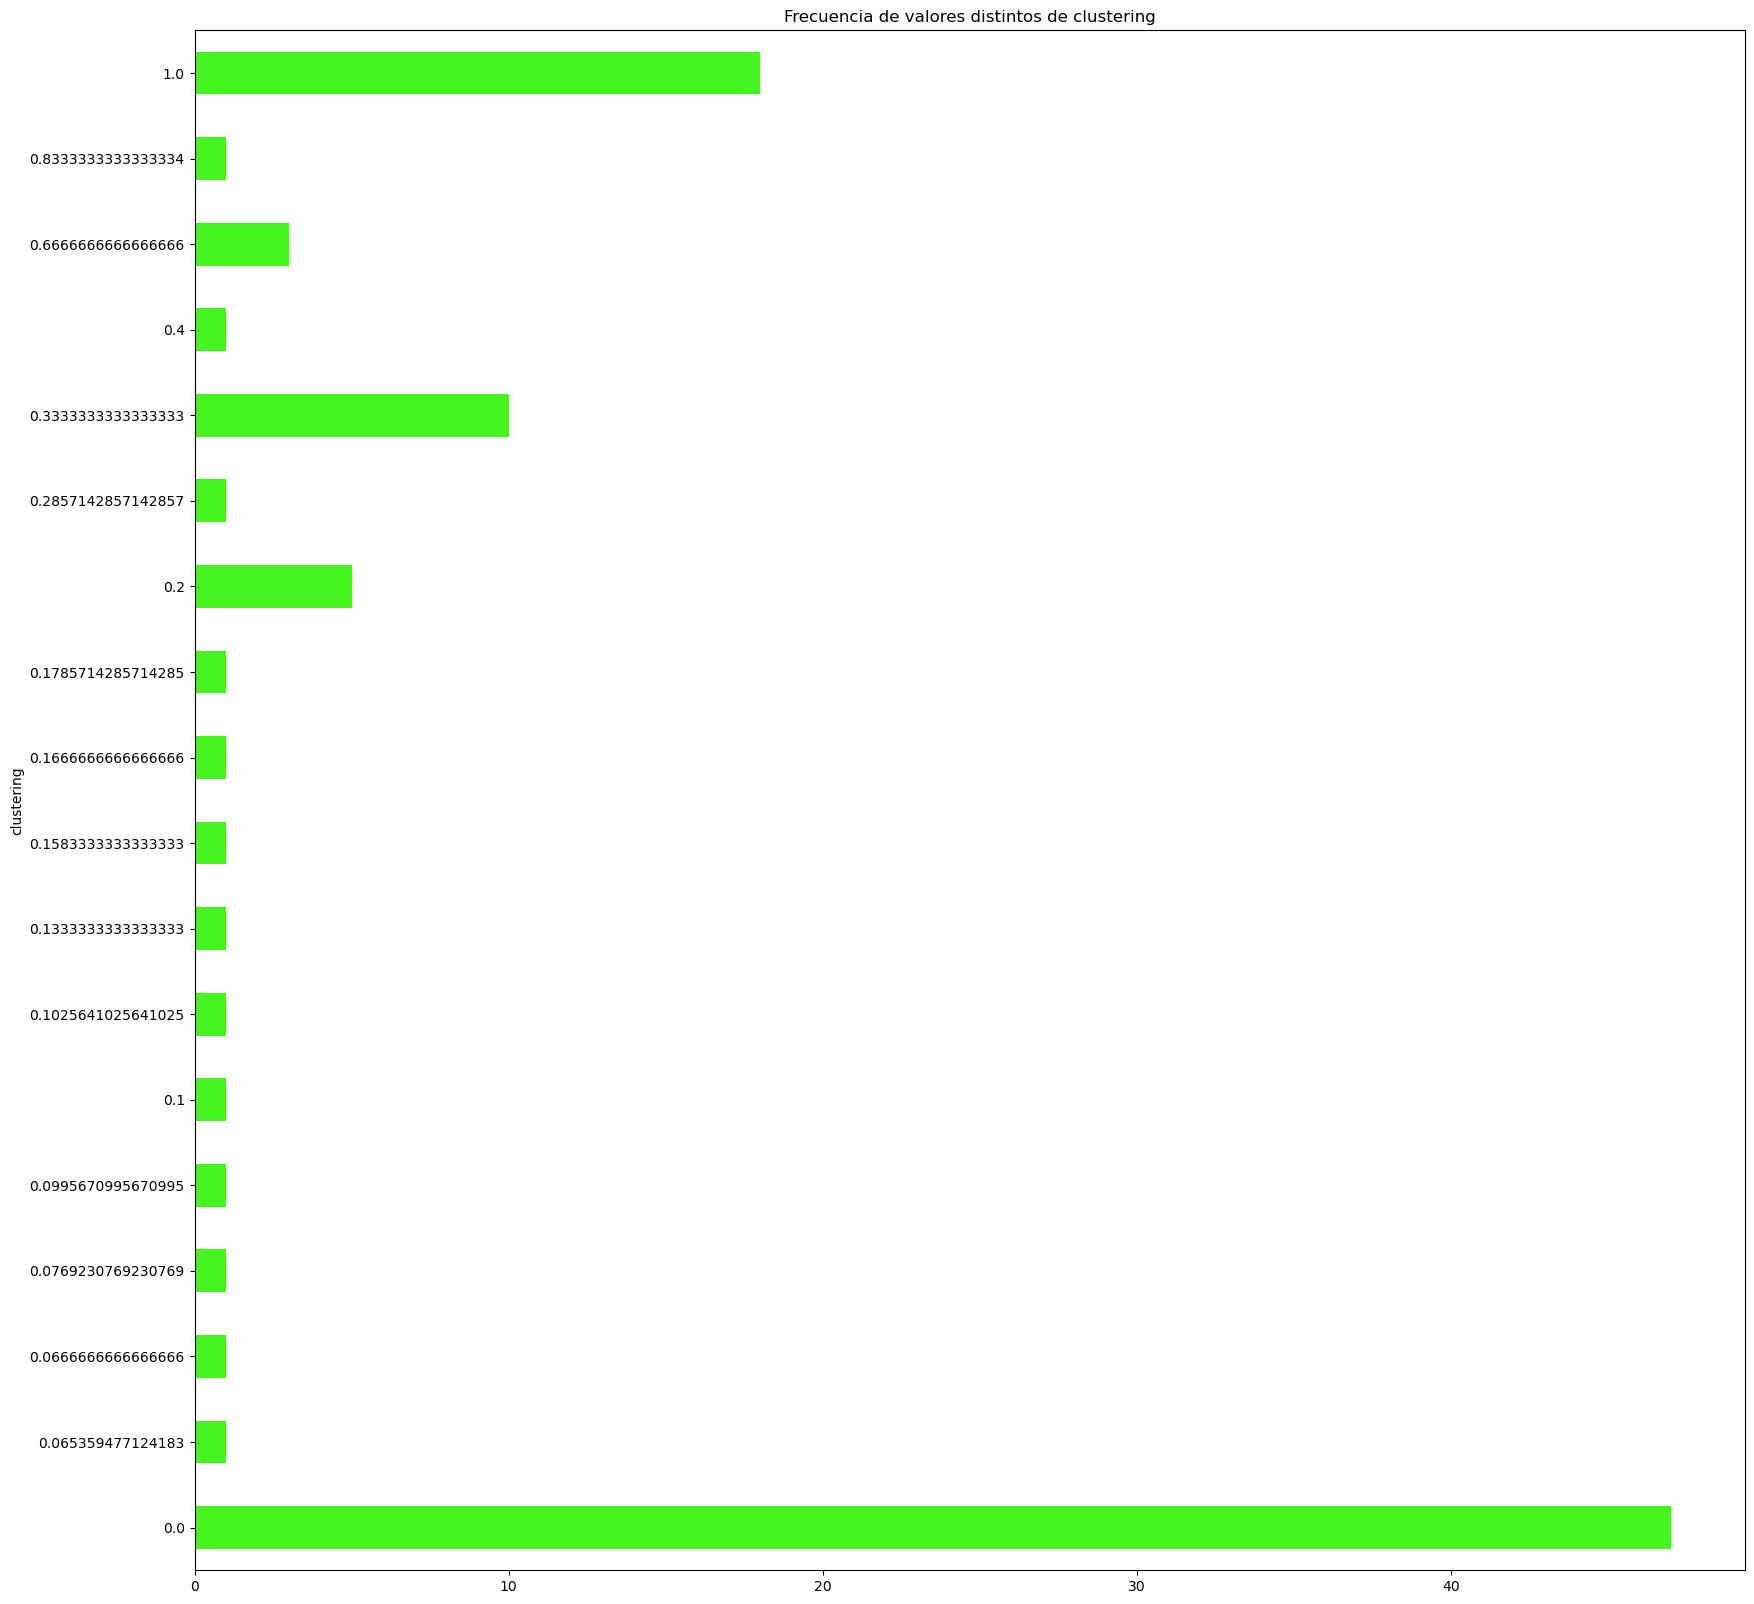

In [108]:
map_for_names={}
for i in range(0,analysis.shape[0]):
    clave=analysis.loc[i,'clustering']
    if(clave in map_for_names.keys()):
        map_for_names[clave]+=1
    else:
        map_for_names[clave]=1
print("Tenemos un total de ",len(map_for_names.keys())," valores distintos, y con la siguiente frecuencia")
print("clustering más frecuente:",max(map_for_names,key=map_for_names.get),", con una frecuencia de ",max(map_for_names.values()))
print("clustering menos frecuente:",min(map_for_names,key=map_for_names.get),", con una frecuencia de ",min(map_for_names.values()))
analysis.groupby(['clustering'])['clustering'].count().plot(kind='barh',color='#46F41F',title='Frecuencia de valores distintos de clustering',xlabel="clustering",ylabel="Frecuencia",figsize=(20,20))

Tras analizar esto, podemos llegar a la conclusión de que la gran mayoria de nodos del grafo estan mínimamente agrupados con sus vecinos, y al observar las demás frecuencias, podemos determinar que todo el grafo esta poco agrupado

**Probabilidad:**

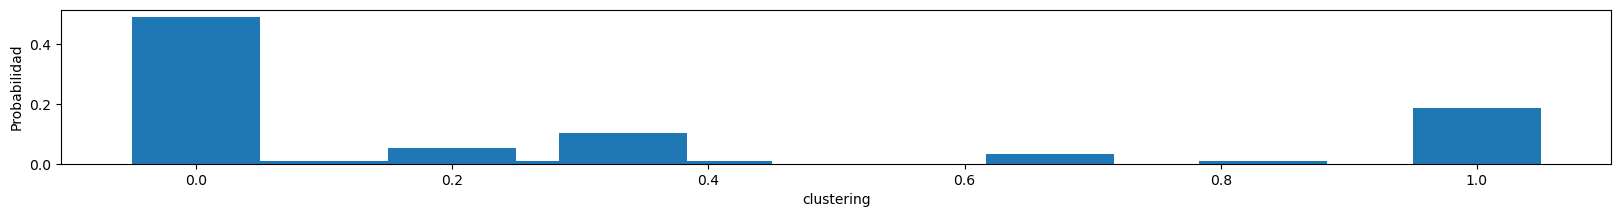

In [118]:
values=[x/96 for x in map_for_names.values()]
pyplot.figure(figsize=(20,2))
pyplot.bar(x=list(map_for_names.keys()),height=values,width=0.1)
pyplot.ylabel('Probabilidad')
pyplot.xlabel('clustering')
pyplot.show()

Estudiando las probabilidades llegamos a la misma conclusión, de que la gran mayoria de nodos presentan la mínima agrupación posible.

**Máxima frecuencia y mínima frecuencia:** La máxima frecuencia es 47, y aparece en el clustering=0., y como hay varios coeficientes de clustering con la frecuencia mínima no es posible determinar cúal es el clustering menos frecuente.

**Conclusión:**
- Al estar relacionado el coeficiente de clustering con los vecinos de cada nodo del grafo, eso explica porque Degree y clustering están correlacionados, implicando que el coeficiente de clustering es necesario para estimar valores de Degree en modelos ML y viceversa
- No sirve de mucho esta métrica sobre los atributos no relacionales que tenemos, ya que la correlación de estas o es negativa o es positiva pero débil. Por lo que no es una buena métrica para modelos ML que estimen estos atributos, pero añade complejidad al modelo


# 9º Análisis sobre Degree:

**Correlación:**

C:\Users\andre\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


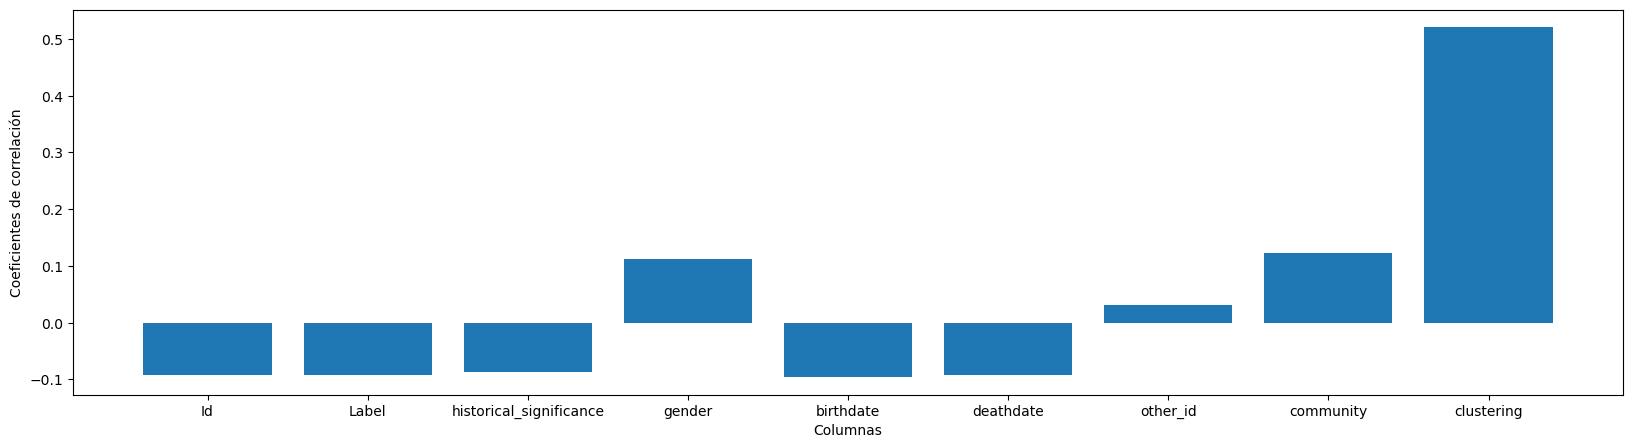

In [119]:
columnas=['Id','Label','historical_significance',
                              'gender', 'birthdate','deathdate', 'other_id','community','clustering']
valores=[]
#Spearman, Pearson, kendall
for columna in columnas:
    corrSpe=analysis['Degree'].corr(analysis[columna],method='spearman')
    valores.append(corrSpe)

pyplot.figure(figsize=(20,5))
pyplot.bar(x=columnas,height=valores,label=['Columnas','Coeficiente de correlación'])
pyplot.xlabel('Columnas')
pyplot.ylabel('Coeficientes de correlación')
pyplot.show()

Como se puede apreciar, Degree presenta una asociación moderada con clustering, corraborando el análisis sobre clustering. Pero con respecto al resto de atributos, sólo presenta una asociación positiva con gender, other_id y community, con el resto de atributos presenta una asociación negativa, implicando que Degree dificultará la creación de modelos ML sobre estos atributos.

**Frecuencia:**

Tenemos un total de  14  valores distintos, y con la siguiente frecuencia
Degree más frecuente: 2 , con una frecuencia de  32
Degree menos frecuente: 10 , con una frecuencia de  1


<AxesSubplot:title={'center':'Frecuencia de valores distintos de Degree'}, ylabel='Degree'>

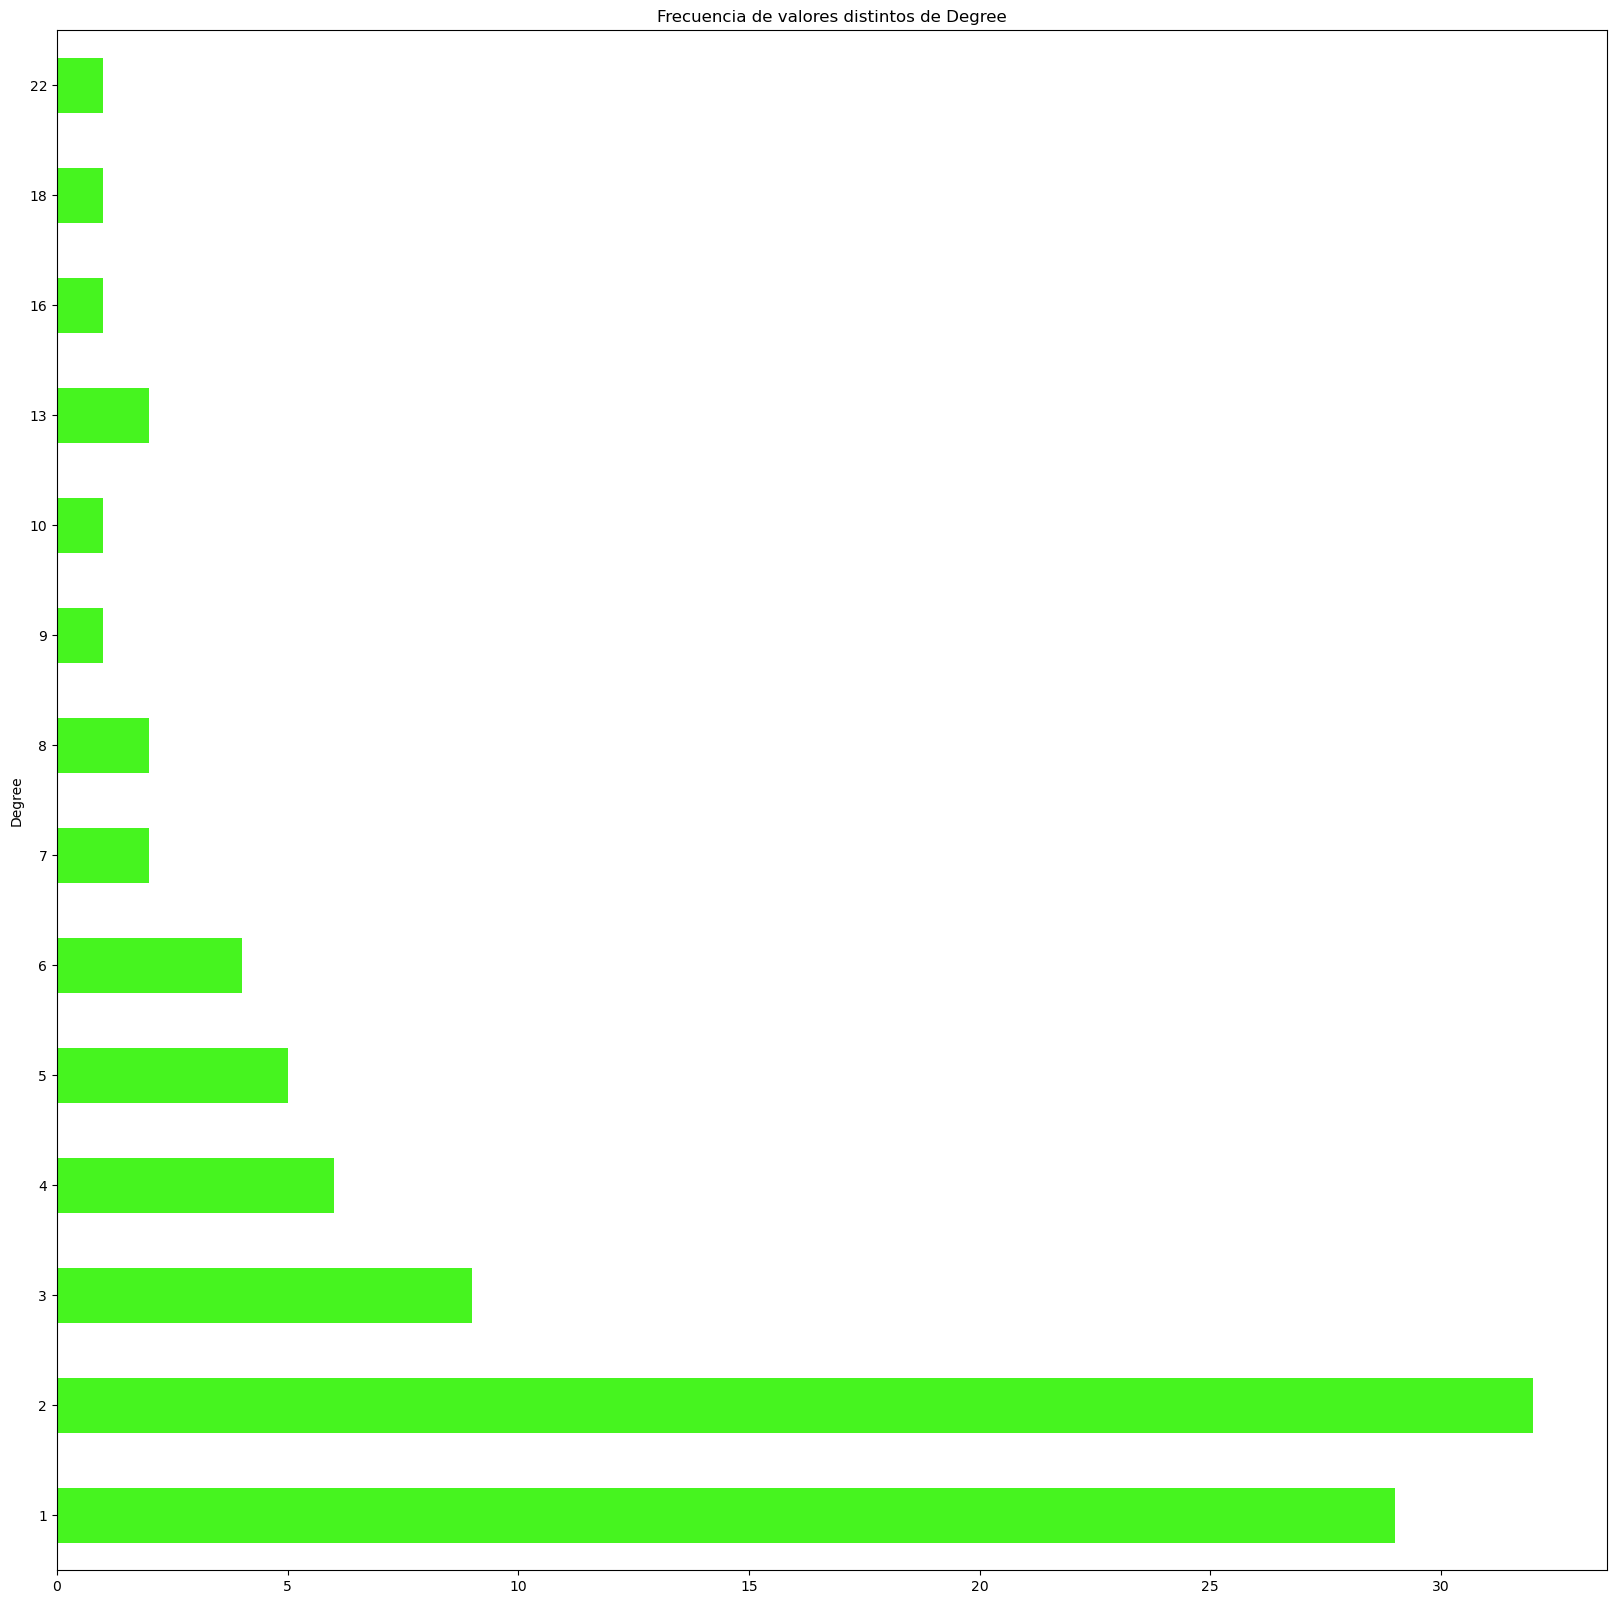

In [120]:
map_for_names={}
for i in range(0,analysis.shape[0]):
    clave=analysis.loc[i,'Degree']
    if(clave in map_for_names.keys()):
        map_for_names[clave]+=1
    else:
        map_for_names[clave]=1
print("Tenemos un total de ",len(map_for_names.keys())," valores distintos, y con la siguiente frecuencia")
print("Degree más frecuente:",max(map_for_names,key=map_for_names.get),", con una frecuencia de ",max(map_for_names.values()))
print("Degree menos frecuente:",min(map_for_names,key=map_for_names.get),", con una frecuencia de ",min(map_for_names.values()))
analysis.groupby(['Degree'])['Degree'].count().plot(kind='barh',color='#46F41F',title='Frecuencia de valores distintos de Degree',xlabel="Degree",ylabel="Frecuencia",figsize=(20,20))

Podemos observar que la gran mayoria de nodos presentan entre 3 y 1 arista, explicando el porque la gran mayoria de nodos presentaban un coeficiente de clustering de 0.

**Probabilidad:**

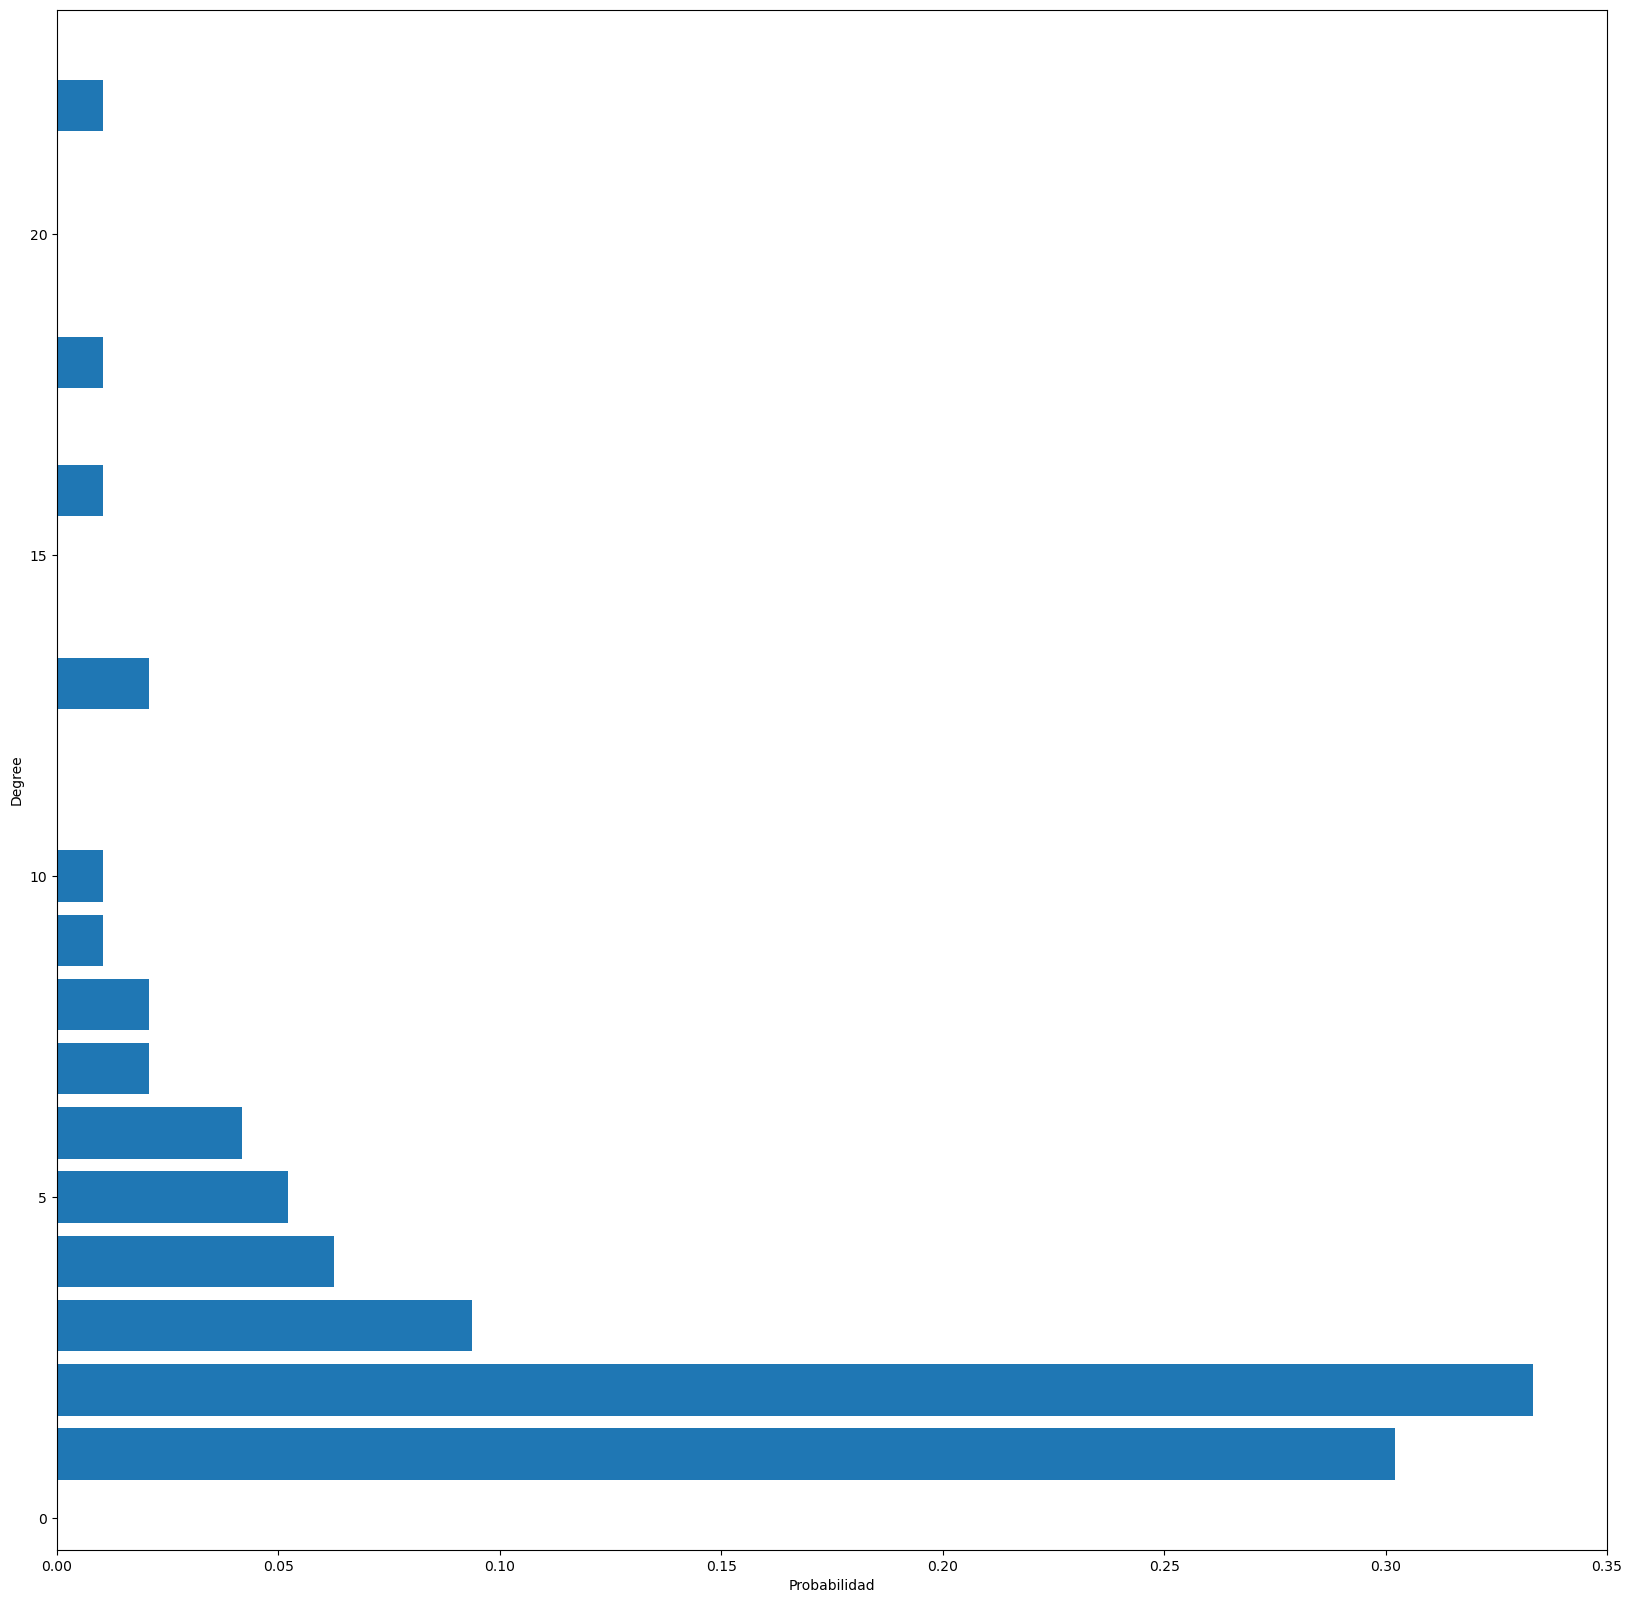

In [121]:
values=[x/96 for x in map_for_names.values()]
pyplot.figure(figsize=(20,20))
pyplot.barh(y=list(map_for_names.keys()),width=values)
pyplot.xlabel('Probabilidad')
pyplot.ylabel('Degree')
pyplot.show()

Con la probabilidad podemos enteder que es más probable que un nodo tenga 2 aristas.

**Máxima frecuencia y mínima frecuencia:** A partir del estudio de la frecuencia y de la probabilidad, sabemos que el grado de centralidad más frecuente es 2, pero al haber varias frecuencias mínimas (que la frecuencia mínima es 1), no es posible determinar el grado de centralidad más pequeño

**Conclusión:**
- No es una métrica adecuada para predecir la gran mayoria de atributos de los datos, ya que sólo presenta una asociación positiva destacable con los atributos 'gender' y 'clustering'.
- Al tener pocos valores vistos y pocos ejemplos, las frecuencias y probabilidades que se observan son variadas.

# CONCLUSIÓN DEL ANÁLISIS RESIDUAL:

Las conclusiones que hemos obtenido son las siguientes:
- Las métricas relacionales van a añadir complejidad a los modelos ML que construyamos, ya que estan poco correlacionados con los atributos propios de cada nodo, pero presentan frecuencias y probabilidades variadas.
- Id, Label y other_id al presentar valores distintos con la misma frecuencia van a añadir demasiada complejidad a los modelos, por lo que vamos a omitirlos para hacer más sencilla la construcción de los modelos ML que hagamos.
- historical_significance es un atributo que esta asociado positivamente con la gran mayoria de atributos, pero las frecuencias y probabilidades de esta no son muy variadas, por lo que añadirá complejidad a los modelos pero no tanto como otros atributos.
- Con gender ocurre lo mismo que con historical_significance, pero al tratarse de un atributo binario tenemos sólo 2 clases posibles, facilitando la estimación de la misma en los modelos ML
- Con birthdate y deathdate supimos que la gran mayoria de personas que murieron en un año o en un año similar nacieron en un año en común o en uno aproximado, implicando que muchos de los miembros de Quakers tenían edades similares.
- other_id es un atributo relacional

In [71]:
#EXPORTACIÓN DEL DATAFRAME A UTILIZAR
q1=analysis.drop(['Id'], axis=1)
q2=q1.drop(['Label'], axis=1)
q3=q2.drop(['other_id'],axis=1)
q3.to_csv('data.csv',columns=q3.columns,index=True)
q3

,historical_significance,gender,birthdate,deathdate,community,clustering,Degree
0,Quaker schismatic and Church of England clergyman,male,1638,1716,comunidad-2,0.285714,8
1,religious writer and colonial governor,male,1648,1690,comunidad-2,0.333333,3
2,merchant and religious writer,male,1636,1714,comunidad-2,0.200000,10
3,philosopher,female,1631,1679,comunidad-2,0.000000,1
4,physician and cabbalist,male,1614,1698,comunidad-2,1.000000,2
...,...,...,...,...,...,...,...
91,Quaker missionary,female,1555,1665,comunidad-3,0.000000,2
92,politician in America,male,1671,1746,comunidad-3,0.000000,1
93,naval officer and politician,male,1666,1743,comunidad-3,0.000000,2
94,Quaker preacher,male,1627,1671,comunidad-7,0.000000,1


# CONSTRUCCIÓN DE LOS MODELOS

In [4]:
from sklearn import preprocessing
from sklearn import naive_bayes
from sklearn.model_selection import cross_validate
from sklearn import model_selection

In [5]:
quakers=pandas.read_csv('data.csv', header=None,
                       names=['historical_significance', 'gender',
                              'birthdate', 'deathdate','community','clustering','Degree'],skiprows=1)
quakers

,historical_significance,gender,birthdate,deathdate,community,clustering,Degree
0,Quaker schismatic and Church of England clergyman,male,1638,1716,comunidad-2,0.285714,8
1,religious writer and colonial governor,male,1648,1690,comunidad-2,0.333333,3
2,merchant and religious writer,male,1636,1714,comunidad-2,0.200000,10
3,philosopher,female,1631,1679,comunidad-2,0.000000,1
4,physician and cabbalist,male,1614,1698,comunidad-2,1.000000,2
...,...,...,...,...,...,...,...
91,Quaker missionary,female,1555,1665,comunidad-3,0.000000,2
92,politician in America,male,1671,1746,comunidad-3,0.000000,1
93,naval officer and politician,male,1666,1743,comunidad-3,0.000000,2
94,Quaker preacher,male,1627,1671,comunidad-7,0.000000,1


# 1. Modelo kNN de regresión sobre atributo 'birthdate':

Los pasos para obtener el modelo óptimo son los siguientes:
- 1º Preparar los datos
- 2º Codificar atributos categóricos y normalizar los atributos continuos
- 4º Estudiamos el coeficiente de determinación obtenido con 
- 5º Estudiar sobreajuste de los modelos
- 5º Construir, entrenar y validar el modelo Knn de regresión con el valor de k y la métrica de distancia óptimas

In [6]:
#1º Preparamos los datos 
nTotalEjemplos=quakers.shape[0]
atributos = quakers.loc[:, ('historical_significance','gender'
                              , 'deathdate','community','clustering','Degree')]  # selección de las columnas de atributos
objetivo = quakers['birthdate']  # selección de la columna objetivo

#OJO, hay que codificar los atributos categóricos, los continuos sólo debemos normalizarlos
atributos_a_codificar=quakers.loc[:, ('historical_significance','gender','community')]

#2ºNormalizar columnas
normalizar_columna_y_actualizar(atributos,'Degree')
normalizar_columna_y_actualizar(atributos,'deathdate')
#Aplicar la codificación
codificador_atributos = preprocessing.OrdinalEncoder()


codificador_atributos.fit(atributos_a_codificar)

atributos_codificados = pandas.DataFrame(codificador_atributos.transform(atributos_a_codificar),columns=['historical_significance','gender','community'])
atributos_codificados['Degree']=atributos['Degree']
atributos_codificados['deathdate']=atributos['deathdate']
atributos_codificados['clustering']=atributos['clustering']

#No necesitamos codificar el atributo objetivo

#Como tenemos pocos ejemplos, entonces utilizar train_split no nos sería efectivo, tendríamos que aplicar la validación cruzada
# sobre todos los ejemplos y estudiar los coeficientes de determinación obtenidos por la parte de entrenamiento y por la parte de
# validación






Como tenemos pocos ejemplos, tenemos que comprobar una cosa, **¿sería efectivo dividir los ejemplos en 3 conjuntos(entrenamiento,validación y test)?**
Para comprobarlo, probaremos a buscar el k óptimo y la métrica de distancia óptima sin aplicar la validación cruzada

Tras normalizar y codificar los atributos, ya podemos empezar a estudiar:
- Número de vecinos del modelo
- La métrica de distancia 

A partir de estos dos elementos, el modelo óptimo lo encontraremos en aque cuyo ajuste sea el mejor (que ni haya poco ajuste ni sobreajuste). Es decir, encontrar el k y la métrica de distancia que haga que la media de R2 de entrenamiento y la media de R2 de test sean similares o iguales.

In [7]:
(atributos_generales, atributos_test,
 objetivo_generales, objetivo_test) = model_selection.train_test_split(
        # Conjuntos de datos a dividir, usando los mismos índices para ambos
        atributos_codificados, objetivo,
        # Valor de la semilla aleatoria, para que el muestreo sea reproducible,
        # a pesar de ser aleatorio
        random_state=12345,
        # Tamaño del CONJUNTO DE TEST
        test_size=.12)
(atributos_entrenamiento,atributos_validacion,objetivo_entrenamiento,objetivo_validacion) =model_selection.train_test_split(
        # Conjuntos de datos a dividir, usando los mismos índices para ambos
        atributos_generales, objetivo_generales,
        # Valor de la semilla aleatoria, para que el muestreo sea reproducible,
        # a pesar de ser aleatorio
        random_state=12345,
        # Tamaño del CONJUNTO DE TEST
        train_size=.5)
atributos_entrenamiento.shape[0],atributos_validacion.shape[0],atributos_test.shape[0]

(42, 42, 12)

MÉTRICA DE DISTANCIA UTILIZADA: cityblock
El mejor rendimiento se da para k= 3 , generando un rendimiento sobre los ejemplos de test de  -0.030357166563307336
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.14890032523952323


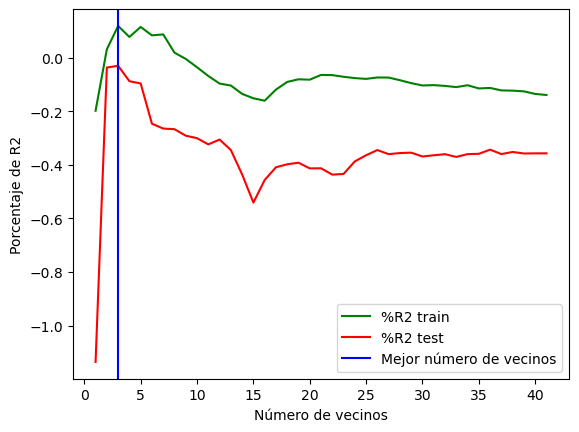

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: cosine
El mejor rendimiento se da para k= 41 , generando un rendimiento sobre los ejemplos de test de  -0.38613361728247564
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.22840885531574306


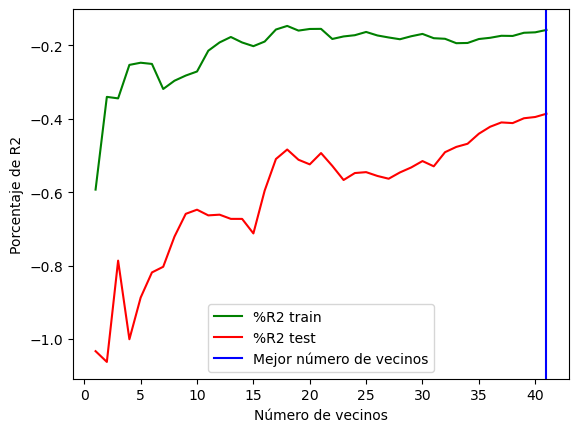

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: euclidean
El mejor rendimiento se da para k= 4 , generando un rendimiento sobre los ejemplos de test de  0.05275285469638091
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.06203348909244122


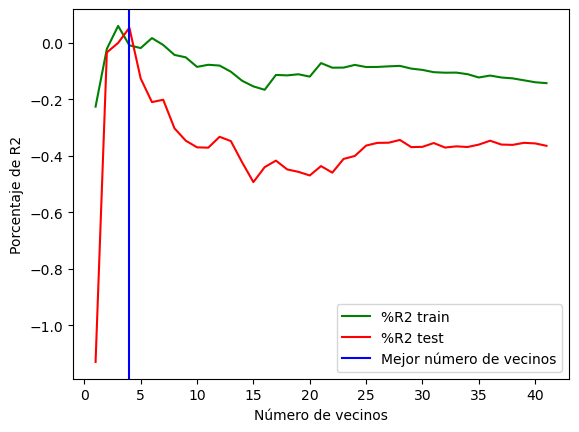

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: l1
El mejor rendimiento se da para k= 3 , generando un rendimiento sobre los ejemplos de test de  -0.030357166563307336
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.14890032523952323


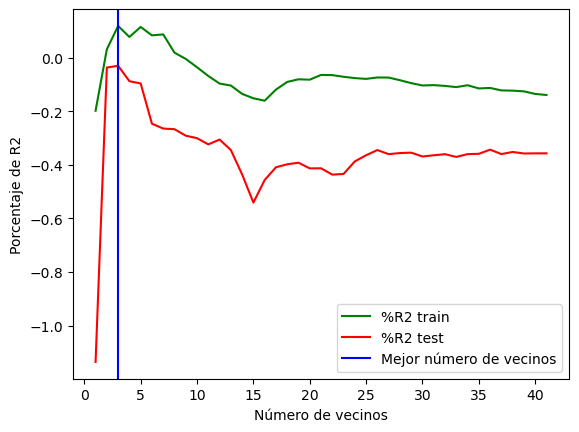

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: l2
El mejor rendimiento se da para k= 4 , generando un rendimiento sobre los ejemplos de test de  0.05275285469638091
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.06203348909244122


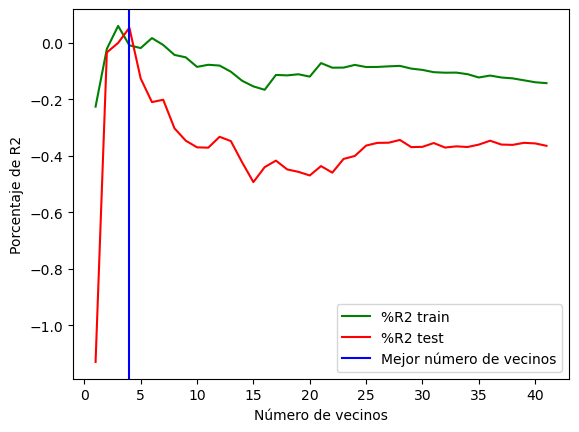

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: manhattan
El mejor rendimiento se da para k= 3 , generando un rendimiento sobre los ejemplos de test de  -0.030357166563307336
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.14890032523952323


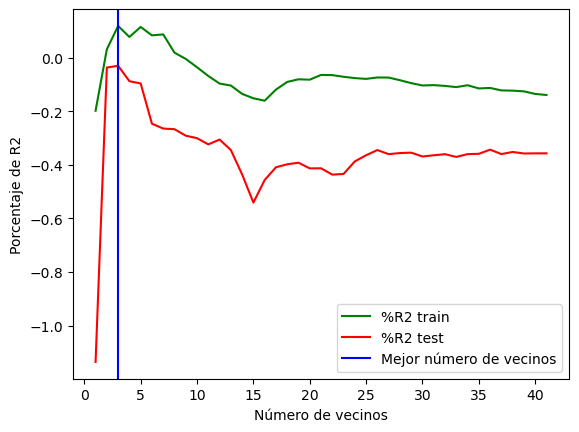

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: nan_euclidean
El mejor rendimiento se da para k= 4 , generando un rendimiento sobre los ejemplos de test de  0.05275285469638091
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.06203348909244122


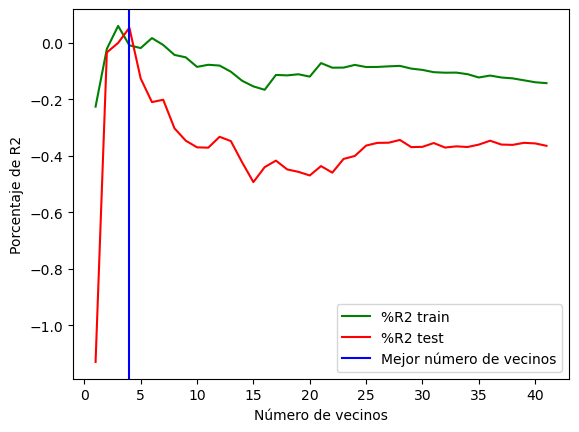

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: hamming
El mejor rendimiento se da para k= 4 , generando un rendimiento sobre los ejemplos de test de  -0.21621160312466214
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.053167459642143644


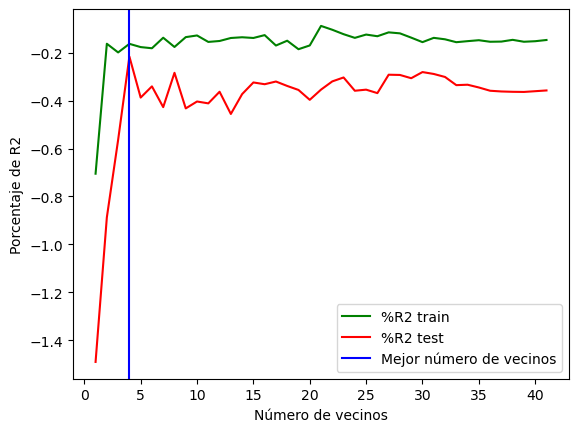

///////////////////////////////////////////////////////////////////////////////////////////////////////////


In [10]:

    
#Como es una tarea de regresión, aqui podemos también utilizar k vecinos pares
#Como la métrica de distancia 'haversine' sólo funciona en dos dimensiones, la he ignorado
metricas=['cityblock','cosine','euclidean','l1','l2','manhattan','nan_euclidean','hamming']
for metrica in metricas:
    print("MÉTRICA DE DISTANCIA UTILIZADA:",metrica)
    #k máximo=número de ejemplos de entrenamiento que tengo
    r2_entrenamiento=[]
    r2_test=[]
    diferencia_r2=[]
    ks=[]
    for i in range(1,42):#Como hay 42 ejemplos de entrenamiento, no podemos tener más de 42 vecinos
        ks.append(i)
        regression_kNN = neighbors.KNeighborsRegressor(
        n_neighbors=i,  # Número de vecinos a considerar
        metric=metrica# Distancia de Man como métrica de cercanía:
        )
        regression_kNN.fit(atributos_entrenamiento,objetivo_entrenamiento)
        train_score=regression_kNN.score(atributos_validacion,objetivo_validacion)
        test_score=regression_kNN.score(atributos_test,objetivo_test)
        r2_entrenamiento.append(train_score)
        r2_test.append(test_score)
        dif=abs(train_score-test_score)
        diferencia_r2.append(dif)
    print("El mejor rendimiento se da para k=",r2_test.index(max(r2_test))+1,", generando un rendimiento sobre los ejemplos de test de ",max(r2_test))
    print("La diferencia entre cada porcentaje obtenido en el mejor k es:",diferencia_r2[r2_test.index(max(r2_test))])
    y_entrenamiento=r2_entrenamiento
    y_test=r2_test
    pyplot.plot(ks,y_entrenamiento,color='green',label='%R2 train')
    pyplot.plot(ks,y_test,color="red",label="%R2 test")
    pyplot.axvline(r2_test.index(max(r2_test))+1, color='blue',label='Mejor número de vecinos')
    pyplot.xlabel("Número de vecinos")
    pyplot.ylabel("Porcentaje de R2")
    pyplot.legend()
    pyplot.show()
    print("///////////////////////////////////////////////////////////////////////////////////////////////////////////")

Tras obtener estos resultados, podemos observar que los modelos que se obtienen presentan un buen ajuste con los ejemplos de entrenamiento y con los ejemplos de test, pero el porcentaje de R2 que se obtienen son cercanos o inferiores a 0. Evaluemos ahora el caso contrario, aplicar la validación cruzada sin separar los ejemplos

Lo primero, vamos a ver el límite de k vecinos que podemos utilizar hasta que aparezcan valores o nan o aproximados a 0, y tras la ejecución simultanea de los modelos, el límite de k es 86 (a partir de 87 devuelve valores nan)

MÉTRICA DE DISTANCIA UTILIZADA: cityblock
El mejor rendimiento se da para k= 10 , generando un rendimiento sobre los ejemplos de test de  -0.1315644355259411
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.42377903403187517


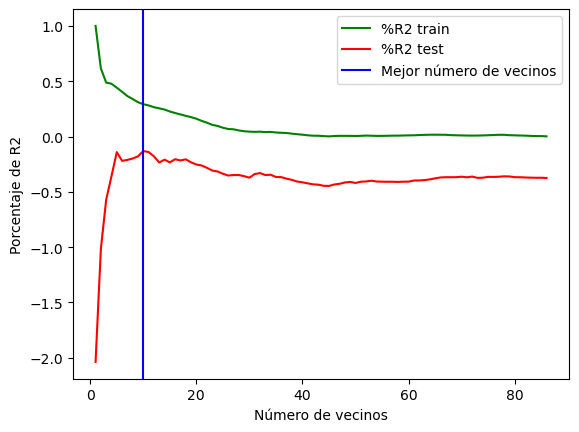

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: cosine
El mejor rendimiento se da para k= 6 , generando un rendimiento sobre los ejemplos de test de  -0.22693598329121834
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.5627424662124219


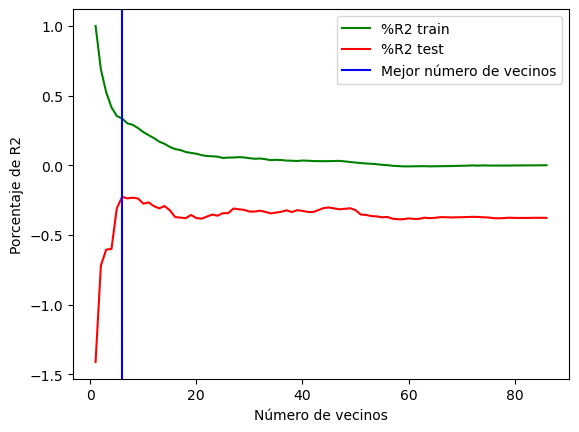

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: euclidean
El mejor rendimiento se da para k= 9 , generando un rendimiento sobre los ejemplos de test de  -0.1612725419855309
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.46896597252075967


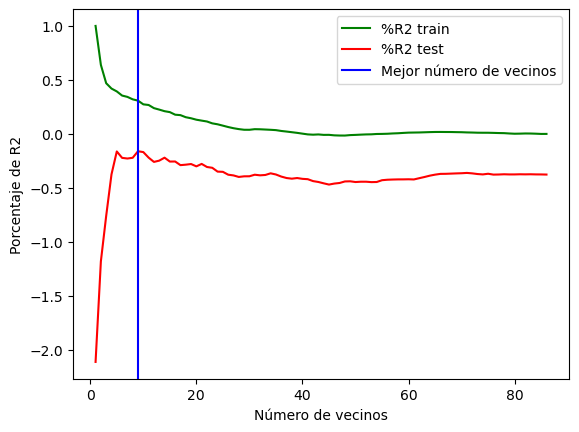

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: l1
El mejor rendimiento se da para k= 10 , generando un rendimiento sobre los ejemplos de test de  -0.1315644355259411
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.42377903403187517


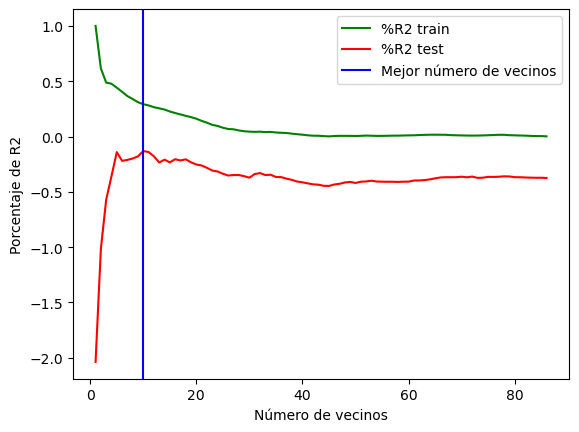

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: l2
El mejor rendimiento se da para k= 9 , generando un rendimiento sobre los ejemplos de test de  -0.1612725419855309
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.46896597252075967


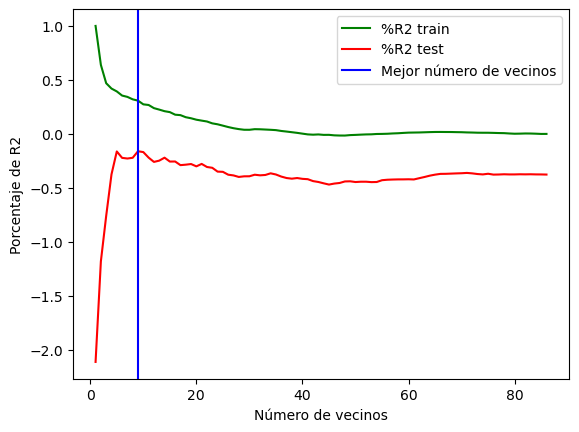

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: manhattan
El mejor rendimiento se da para k= 10 , generando un rendimiento sobre los ejemplos de test de  -0.1315644355259411
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.42377903403187517


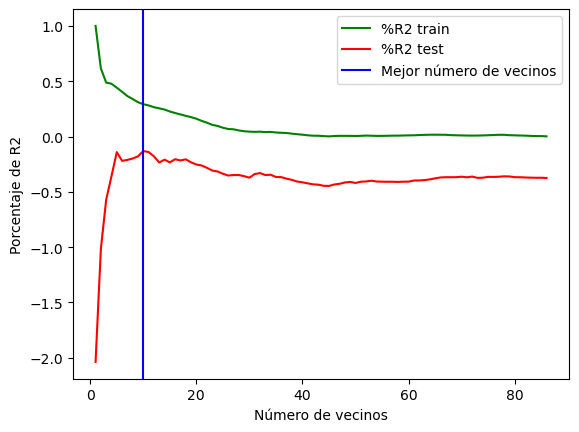

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: nan_euclidean
El mejor rendimiento se da para k= 9 , generando un rendimiento sobre los ejemplos de test de  -0.1612725419855309
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.46896597252075967


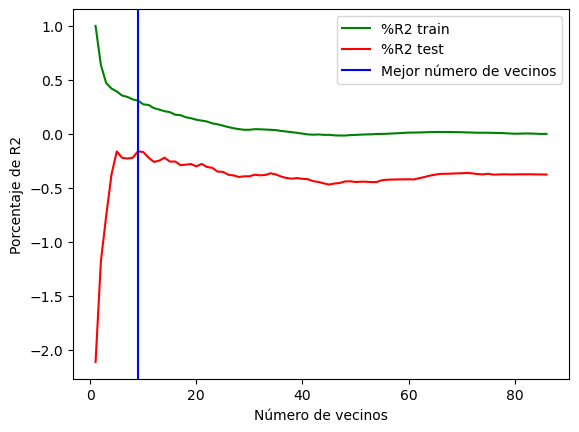

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: hamming
El mejor rendimiento se da para k= 38 , generando un rendimiento sobre los ejemplos de test de  -0.17839901587073698
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.30829351479928874


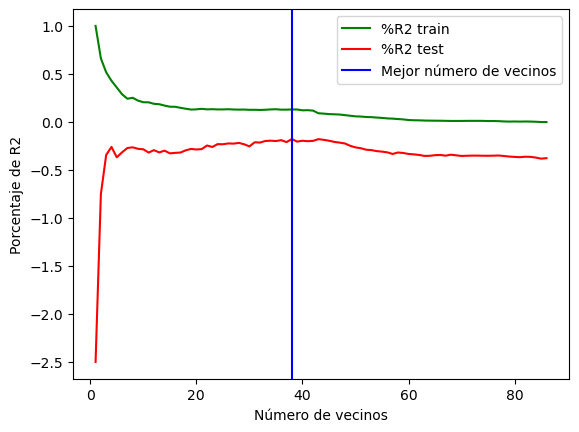

///////////////////////////////////////////////////////////////////////////////////////////////////////////


In [205]:

    
#Como es una tarea de regresión, aqui podemos también utilizar k vecinos pares
#Como la métrica de distancia 'haversine' sólo funciona en dos dimensiones, la he ignorado
metricas=['cityblock','cosine','euclidean','l1','l2','manhattan','nan_euclidean','hamming']
for metrica in metricas:
    print("MÉTRICA DE DISTANCIA UTILIZADA:",metrica)
    #k máximo=número de ejemplos de entrenamiento que tengo
    r2_entrenamiento=[]
    r2_test=[]
    diferencia_r2=[]
    ks=[]
    for i in range(1,87): #No puede ser mayor a 87 , a partir de 87 da valores nan
        ks.append(i)
        regression_kNN = neighbors.KNeighborsRegressor(
        n_neighbors=i,  # Número de vecinos a considerar
        metric=metrica# Distancia de Man como métrica de cercanía:
        )
        scores=cross_validate(regression_kNN,atributos_codificados,objetivo,cv=10,scoring="r2",return_train_score=True)
        #Al poner scoring=r2, la validación cruzada devolverá los coeficientes de determinación resultantes de cada combinación de plieges
        train_scores=scores['train_score']
        train_score=train_scores.mean()
        test_scores=scores['test_score']
        test_score=test_scores.mean()
        r2_entrenamiento.append(train_score)
        r2_test.append(test_score)
        dif=abs(train_score-test_score)
        diferencia_r2.append(dif)
    print("El mejor rendimiento se da para k=",r2_test.index(max(r2_test))+1,", generando un rendimiento sobre los ejemplos de test de ",max(r2_test))
    print("La diferencia entre cada porcentaje obtenido en el mejor k es:",diferencia_r2[r2_test.index(max(r2_test))])
    y_entrenamiento=r2_entrenamiento
    y_test=r2_test
    pyplot.plot(ks,y_entrenamiento,color='green',label='%R2 train')
    pyplot.plot(ks,y_test,color="red",label="%R2 test")
    pyplot.xlabel("Número de vecinos")
    pyplot.ylabel("Porcentaje de R2")
    pyplot.axvline(r2_test.index(max(r2_test))+1, color='blue',label='Mejor número de vecinos')
    pyplot.legend()
    pyplot.show()
    print("///////////////////////////////////////////////////////////////////////////////////////////////////////////")

**Tras observar ambos estudios, podemos darnos cuenta de algo importante, al utilizar todos los ejemplos para entrenar los modelos, el modelo empieza a recoger información parecida, y es por eso que a partir de un número de vecinos en el estudio sobre la validación cruzada podemos observar que el coeficiente de determinación devuelve valores similares.**

Como todavía no estamos seguros de si dividir el conjunto o no, vamos a estudiar la validación final del caso anterior

El mejor modelo Knn de regresión lo hemos obtenido con 4 vecinos y con la métrica de distancia euclidea, el cuál nos permite obtener un modelo ajustado (R2 train es similar al R2 test). Ahora lo que debemos hacer es evaluar nuestro modelo a partir de los ejemplos de validación.

In [207]:
regression_kNN = neighbors.KNeighborsRegressor(
    n_neighbors=4,  # Número de vecinos a considerar
        metric='euclidean'# Distancia de Man como métrica de cercanía:
    )
regression_kNN.fit(atributos_entrenamiento, objetivo_entrenamiento)
value=regression_kNN.score(atributos_validacion,objetivo_validacion)
print(value)

-0.009280634396060305


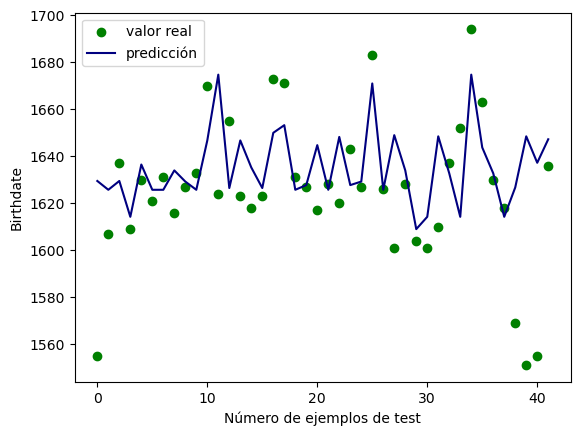

In [208]:
numEjem=[x for x in range(0,atributos_validacion.shape[0])]
objetivo_predicho= regression_kNN.predict(atributos_validacion)
pyplot.scatter(x=numEjem, y=objetivo_validacion, color="green", label="valor real")
pyplot.plot(numEjem, objetivo_predicho, color="navy", label="predicción")
pyplot.xlabel("Número de ejemplos de test")
pyplot.ylabel("Birthdate")
pyplot.legend()
pyplot.show()

Como podemos observar, se esta dando un sobreajuste debido a que hemos utilizado poca información con la que entrenar el modelo. Esto implica a que en nuestro caso no podemos utilizar el train_split debido a que añade tanta complejidad al modelo que lo sobre ajusta. Debido a esto, no podemos realizar la validación final de los modelos.

Como en los modelos generados con la validación cruzada la diferencia entre R2 es mayor, esto puede significar que tenemos información compleja.**¿Qué ocurriría si facilitamos la información?** Para intentar facilitarla, vamos ha facilitar los datos que más afectan a birthdate, que son los atributos relacionales

In [17]:
atributos = quakers.loc[:, ('historical_significance','gender'
                              , 'deathdate','community','clustering','Degree')]  # selección de las columnas de atributos
objetivo = quakers['birthdate']  # selección de la columna objetivo

#OJO, hay que codificar los atributos categóricos, los continuos sólo debemos normalizarlos

#2ºNormalizar columnas
normalizar_columna_y_actualizar(atributos,'Degree')
normalizar_columna_y_actualizar(atributos,'deathdate')
for i in range(0,quakers.shape[0]):
    atributos.loc[i,'Degree']=discretizar_valores_normalizados(atributos.loc[i,'Degree'])
    atributos.loc[i,'clustering']=discretizar_valores_normalizados(atributos.loc[i,'clustering'])
codificador_atributos = preprocessing.OrdinalEncoder()


codificador_atributos.fit(atributos)

atributos_codificados = pandas.DataFrame(codificador_atributos.transform(atributos),columns=['historical_significance','gender'
                              , 'deathdate','community','clustering','Degree'])

normalizar_columna_y_actualizar(atributos_codificados,'community')

#No necesitamos codificar el atributo objetivo

#Como tenemos pocos ejemplos, entonces utilizar train_split no nos sería efectivo, tendríamos que aplicar la validación cruzada
# sobre todos los ejemplos y estudiar los coeficientes de determinación obtenidos por la parte de entrenamiento y por la parte de
# validación


MÉTRICA DE DISTANCIA UTILIZADA: cityblock
El mejor rendimiento se da para k= 6 , generando un rendimiento sobre los ejemplos de test de  0.2094082283867494
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.34408634389702264


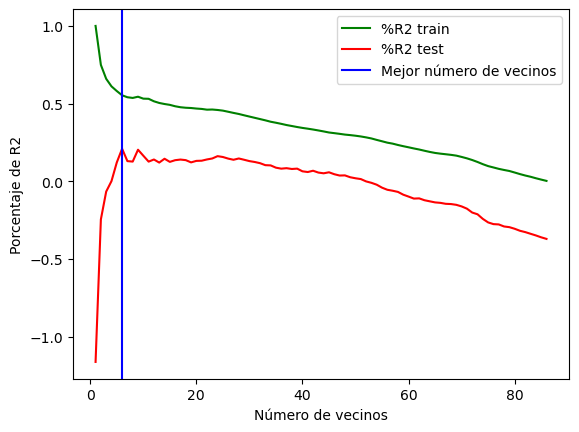

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: cosine
El mejor rendimiento se da para k= 45 , generando un rendimiento sobre los ejemplos de test de  -0.17178395488694012
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.31267036737289094


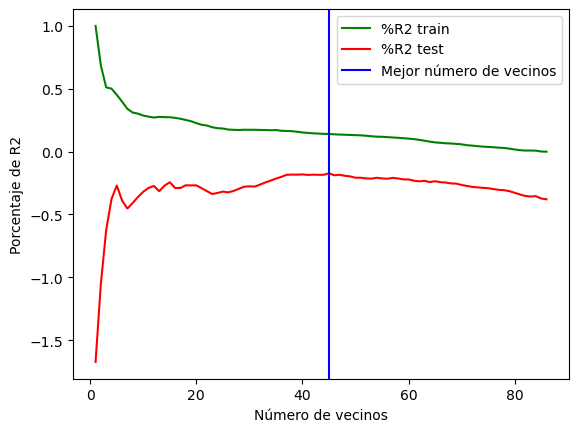

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: euclidean
El mejor rendimiento se da para k= 10 , generando un rendimiento sobre los ejemplos de test de  0.181669211295853
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.33538770393194095


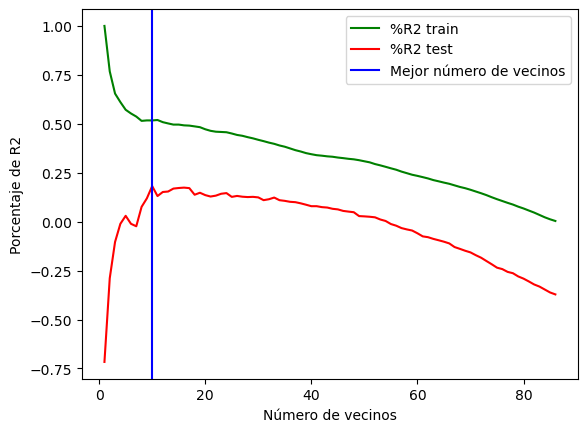

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: l1
El mejor rendimiento se da para k= 6 , generando un rendimiento sobre los ejemplos de test de  0.2094082283867494
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.34408634389702264


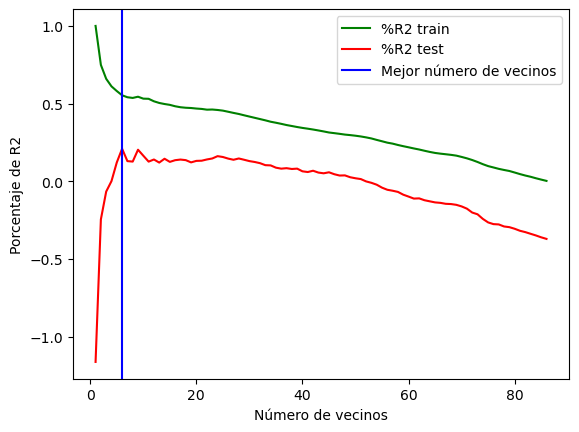

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: l2
El mejor rendimiento se da para k= 10 , generando un rendimiento sobre los ejemplos de test de  0.181669211295853
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.33538770393194095


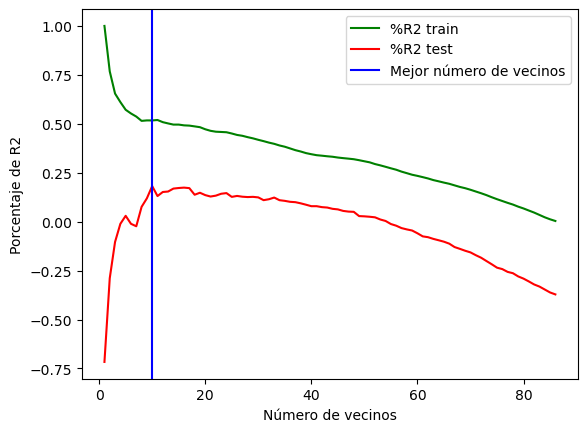

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: manhattan
El mejor rendimiento se da para k= 6 , generando un rendimiento sobre los ejemplos de test de  0.2094082283867494
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.34408634389702264


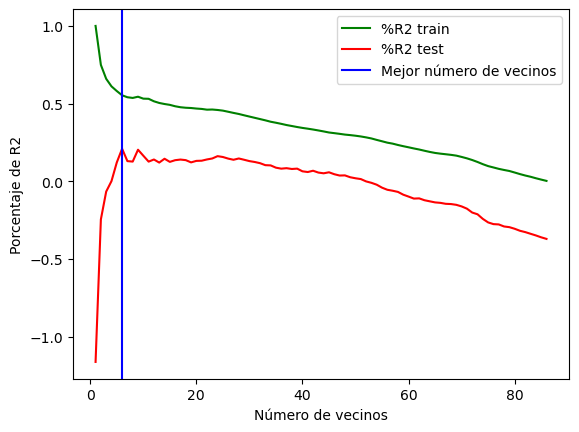

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: nan_euclidean
El mejor rendimiento se da para k= 10 , generando un rendimiento sobre los ejemplos de test de  0.181669211295853
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.3344146172398704


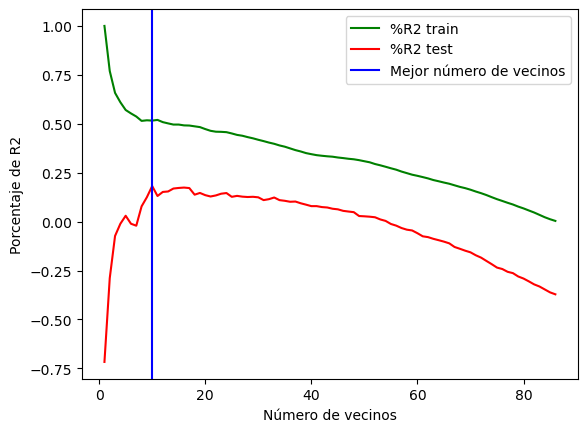

///////////////////////////////////////////////////////////////////////////////////////////////////////////
MÉTRICA DE DISTANCIA UTILIZADA: hamming
El mejor rendimiento se da para k= 43 , generando un rendimiento sobre los ejemplos de test de  -0.2222842093758462
La diferencia entre cada porcentaje obtenido en el mejor k es: 0.29594350483864185


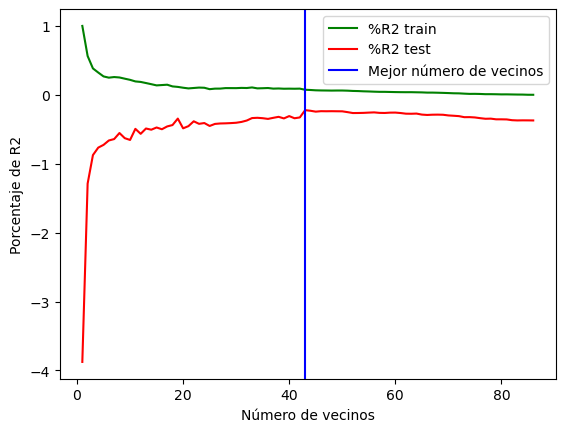

///////////////////////////////////////////////////////////////////////////////////////////////////////////


In [18]:
#Como es una tarea de regresión, aqui podemos también utilizar k vecinos pares
#Como la métrica de distancia 'haversine' sólo funciona en dos dimensiones, la he ignorado
metricas=['cityblock','cosine','euclidean','l1','l2','manhattan','nan_euclidean','hamming']
for metrica in metricas:
    print("MÉTRICA DE DISTANCIA UTILIZADA:",metrica)
    #k máximo=número de ejemplos de entrenamiento que tengo
    r2_entrenamiento=[]
    r2_test=[]
    diferencia_r2=[]
    ks=[]
    for i in range(1,87): #No puede ser mayor a 87 , a partir de 87 da valores nan
        ks.append(i)
        regression_kNN = neighbors.KNeighborsRegressor(
        n_neighbors=i,  # Número de vecinos a considerar
        metric=metrica# Distancia de Man como métrica de cercanía:
        )
        scores=cross_validate(regression_kNN,atributos_codificados,objetivo,cv=10,scoring="r2",return_train_score=True)
        #Al poner scoring=r2, la validación cruzada devolverá los coeficientes de determinación resultantes de cada combinación de plieges
        train_scores=scores['train_score']
        train_score=train_scores.mean()
        test_scores=scores['test_score']
        test_score=test_scores.mean()
        r2_entrenamiento.append(train_score)
        r2_test.append(test_score)
        dif=abs(train_score-test_score)
        diferencia_r2.append(dif)
    print("El mejor rendimiento se da para k=",r2_test.index(max(r2_test))+1,", generando un rendimiento sobre los ejemplos de test de ",max(r2_test))
    print("La diferencia entre cada porcentaje obtenido en el mejor k es:",diferencia_r2[r2_test.index(max(r2_test))])
    y_entrenamiento=r2_entrenamiento
    y_test=r2_test
    pyplot.plot(ks,y_entrenamiento,color='green',label='%R2 train')
    pyplot.plot(ks,y_test,color="red",label="%R2 test")
    pyplot.xlabel("Número de vecinos")
    pyplot.ylabel("Porcentaje de R2")
    pyplot.axvline(r2_test.index(max(r2_test))+1, color='blue',label='Mejor número de vecinos')
    pyplot.legend()
    pyplot.show()
    print("///////////////////////////////////////////////////////////////////////////////////////////////////////////")

**Conclusión de este modelo:**
Aunque hayamos escogido el número de vecinos óptimo y el ajuste parecia el correcto, en este último grafico se predice un modelo sobreajustado, ya que hemos seguido utilizando demasiada información y ha hecho aumentar la complejidad del modelo. Esto se soluciona al facilitar los datos que complican la estimación de birthdate, que en este caso son todos los atributos relacionales. Tras facilitar los atributos (normalizando, discretizando y codificando lo necesario), obtenemos mejores resultados tanto en la cantidad de vecinos óptimo(tras facilitarlo, esta cantidad se minimiza) como en el ajuste que se da.
**Ahora, el modelo Knn de regresión óptimo se da con 6 vecinos y utilizando la métrica manhattan, y como su R2 sobre test es >0, esto indica que el modelo es capaz de predecir la media de valores**

# 2. CART de clasificación del atributo 'gender':

In [210]:
nTotalEjemplos=quakers.shape[0]
atributos = quakers.loc[:, ('historical_significance'
                              ,'birthdate','deathdate','community','clustering','Degree')]  # selección de las columnas de atributos
objetivo = quakers['gender']  # selección de la columna objetivo
#Como birthdate, deathdate, clustering y Degree son atributos continuos, realmente sólo necesitamos codificar historical_significance y community
atributos_a_codificar=atributos.loc[:,('historical_significance','community')]
codificador_atributos = preprocessing.OrdinalEncoder()

codificador_objetivo = preprocessing.LabelEncoder()

codificador_atributos.fit(atributos_a_codificar)
codificador_objetivo.fit(objetivo)

atributos_codificados =  pandas.DataFrame(codificador_atributos.transform(atributos_a_codificar),columns=['historical_significance','community'])
atributos_codificados['birthdate']=atributos['birthdate']
atributos_codificados['deathdate']=atributos['deathdate']
atributos_codificados['clustering']=atributos['clustering']
atributos_codificados['Degree']=atributos['Degree']
objetivo_codificado=codificador_objetivo.transform(objetivo)

Como pudimos comprobar en el modelo anterior, no podemos separar el conjunto de ejemplos, sino obtendremos un modelo sobreajustado

A la vez que buscaremos la profundidad óptima, iremos estudiando el ajuste que se presenta

La mejor precisión se obtiene con una profundidad máxima = 1 , con una precisión de  0.8455555555555556
La diferencia entre cada porcentaje obtenido en el mejor profundidad es: 0.001783836763788793


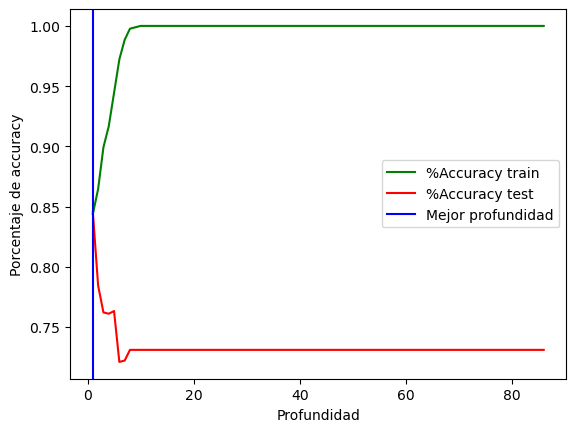

In [212]:
diferencia_accuracy=[]
accuracy_train=[]
accuracy_test=[]
ks=[]
for i in range(1,87):
    ks.append(i)
    clasif_CART = tree.DecisionTreeClassifier(
    max_depth=i,  # máxima profundidad del árbol
    random_state=11122  # semilla aleatoria, para que el código sea reproducible
    )
    scores=cross_validate(clasif_CART,atributos_codificados,objetivo_codificado,cv=10,scoring="accuracy",return_train_score=True)
    train_scores=scores['train_score']
    train_score=train_scores.mean()
    test_scores=scores['test_score']
    test_score=test_scores.mean()
    accuracy_train.append(train_score)
    accuracy_test.append(test_score)
    dif=abs(train_score-test_score)
    diferencia_accuracy.append(dif)
print("La mejor precisión se obtiene con una profundidad máxima =",accuracy_test.index(max(accuracy_test))+1,", con una precisión de ",max(accuracy_test))
print("La diferencia entre cada porcentaje obtenido en el mejor profundidad es:",diferencia_accuracy[accuracy_test.index(max(accuracy_test))])
y_entrenamiento=accuracy_train
y_test=accuracy_test
pyplot.plot(ks,y_entrenamiento,color='green',label='%Accuracy train')
pyplot.plot(ks,y_test,color="red",label="%Accuracy test")
pyplot.xlabel("Profundidad")
pyplot.ylabel("Porcentaje de accuracy")
pyplot.axvline(accuracy_test.index(max(accuracy_test))+1, color='blue',label='Mejor profundidad')
pyplot.legend()
pyplot.show()

Como podemos apreciar en el gráfico, cuanta mayor es la profundidad del árbol mayor es la diferencia entre el accuracy medio obtenido por los ejemplos de entrenamiento y el accuracy medio obtenido por los ejemplos de test. Lo que implica que cuanto mayor sea la profundidad que tengamos en el árbol , menos preciso será el modelo y más sobreajustado estará. 
Es probable que el par atributo-umbral sea deathdate debido a su asociación, asi que **¿qué pasaría si quitamos deathdate?¿y si quitamos todos los atributos que estan asociados positivamente con gender?(historical_significance,deathdate,birthdate)**

In [34]:
nTotalEjemplos=quakers.shape[0]
atributos = quakers.loc[:, ('community','clustering','Degree')]  # selección de las columnas de atributos
objetivo = quakers['gender']  # selección de la columna objetivo
#Como birthdate, deathdate, clustering y Degree son atributos continuos, realmente sólo necesitamos codificar historical_significance y community
codificador_atributos = preprocessing.OrdinalEncoder()

codificador_objetivo = preprocessing.LabelEncoder()

codificador_atributos.fit(atributos)
codificador_objetivo.fit(objetivo)

atributos_codificados = codificador_atributos.transform(atributos)

objetivo_codificado=codificador_objetivo.transform(objetivo)

La mejor precisión se obtiene con una profundidad máxima = 1 , con una precisión de  0.8155555555555557
La diferencia entre cada porcentaje obtenido en el mejor profundidad es: 0.028216163236211123


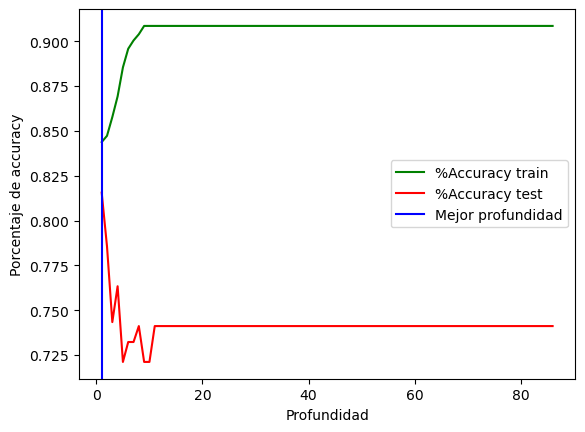

In [35]:
diferencia_accuracy=[]
accuracy_train=[]
accuracy_test=[]
ks=[]
for i in range(1,87):
    ks.append(i)
    clasif_CART = tree.DecisionTreeClassifier(
    max_depth=i,  # máxima profundidad del árbol
    random_state=11122  # semilla aleatoria, para que el código sea reproducible
    )
    scores=cross_validate(clasif_CART,atributos_codificados,objetivo_codificado,cv=10,scoring="accuracy",return_train_score=True)
    train_scores=scores['train_score']
    train_score=train_scores.mean()
    test_scores=scores['test_score']
    test_score=test_scores.mean()
    accuracy_train.append(train_score)
    accuracy_test.append(test_score)
    dif=abs(train_score-test_score)
    diferencia_accuracy.append(dif)
print("La mejor precisión se obtiene con una profundidad máxima =",accuracy_test.index(max(accuracy_test))+1,", con una precisión de ",max(accuracy_test))
print("La diferencia entre cada porcentaje obtenido en el mejor profundidad es:",diferencia_accuracy[accuracy_test.index(max(accuracy_test))])
y_entrenamiento=accuracy_train
y_test=accuracy_test
pyplot.plot(ks,y_entrenamiento,color='green',label='%Accuracy train')
pyplot.plot(ks,y_test,color="red",label="%Accuracy test")
pyplot.xlabel("Profundidad")
pyplot.ylabel("Porcentaje de accuracy")
pyplot.axvline(accuracy_test.index(max(accuracy_test))+1, color='blue',label='Mejor profundidad')
pyplot.legend()
pyplot.show()

Lo que ocurre es que se encuentra el primer par atributo-umbral óptimo y sigue ocurriendo lo mismo, el mejor resultado se obtiene con una profundidad de 1. A partir de 1, baja drásticamente el rendimiento.

**Conclusión del modelo:** El modelo CART de clasificación con profundidad máxima 1 presenta un rendimiento óptimo, ya que tanto la tasa media de accuracy obtenida durante la validación cruzada se aproxima a ser 1, y el accuracy obtenido tras predecir las clases de los ejemplos de prueba es 0.85, por lo que es un buen modelo. Que el mejor modelo se obtenga con una profundidad de 1 significa que se ha encontrado un par atributo-umbral tan bueno que si le añades más profundidad al árbol el rendimiento del modelo empeorará, y como gender esta asociado positivamente sobretodo con deathdate,historical_significance y birthdate, estos atributos probablemente sean los pares atributo-umbral obtenidos, ya que si los ignoramos, obtenemos un peor resultado

# 3. RandomForest de clasificación para 'gender':

Como RandomForest es similar a CART, la preparación de los atributos para entrenar el modelo va a ser igual que la preparación de los atributos en CART

In [10]:
nTotalEjemplos=quakers.shape[0]
atributos = quakers.loc[:, ('historical_significance'
                              ,'birthdate','deathdate','community','clustering','Degree')]  # selección de las columnas de atributos
objetivo = quakers['gender']  # selección de la columna objetivo
#Como birthdate, deathdate, clustering y Degree son atributos continuos, realmente sólo necesitamos codificar historical_significance y community
atributos_a_codificar=atributos.loc[:,('historical_significance','community')]
codificador_atributos = preprocessing.OrdinalEncoder()

codificador_objetivo = preprocessing.LabelEncoder()

codificador_atributos.fit(atributos_a_codificar)
codificador_objetivo.fit(objetivo)


atributos_codificados =  pandas.DataFrame(codificador_atributos.transform(atributos_a_codificar),columns=['historical_significance','community'])
atributos_codificados['birthdate']=atributos['birthdate']
atributos_codificados['deathdate']=atributos['deathdate']
atributos_codificados['clustering']=atributos['clustering']
atributos_codificados['Degree']=atributos['Degree']
objetivo_codificado=codificador_objetivo.transform(objetivo)

La mejor precisión se obtiene con una profundidad máxima = 1 , con una precisión de  0.8455555555555556
La diferencia entre cada porcentaje obtenido en el mejor profundidad es: 0.001783836763788793


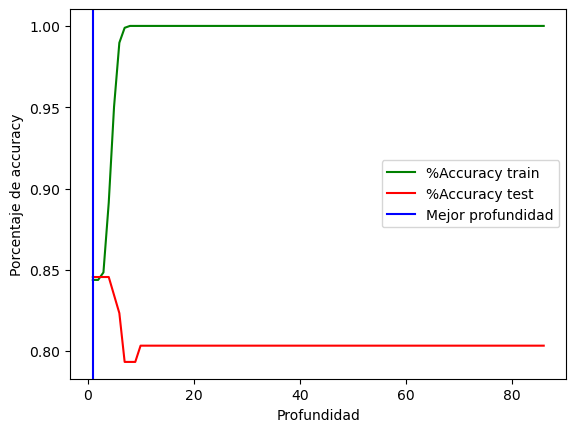

In [11]:
diferencia_accuracy=[]
accuracy_train=[]
accuracy_test=[]
ks=[]
for i in range(1,87):
    ks.append(i)
    randomCl = RandomForestClassifier(max_depth=i,random_state=11123,n_estimators=100)  # con n_estimators determinamos la cantidad de árboles que va a generar
    scores=cross_validate(randomCl,atributos_codificados,objetivo_codificado,cv=10,scoring='accuracy',return_train_score=True)
    train_scores=scores['train_score']
    train_score=train_scores.mean()
    test_scores=scores['test_score']
    test_score=test_scores.mean()
    accuracy_train.append(train_score)
    accuracy_test.append(test_score)
    dif=abs(train_score-test_score)
    diferencia_accuracy.append(dif)
print("La mejor precisión se obtiene con una profundidad máxima =",accuracy_test.index(max(accuracy_test))+1,", con una precisión de ",max(accuracy_test))
print("La diferencia entre cada porcentaje obtenido en el mejor profundidad es:",diferencia_accuracy[accuracy_test.index(max(accuracy_test))])
y_entrenamiento=accuracy_train
y_test=accuracy_test
pyplot.plot(ks,y_entrenamiento,color='green',label='%Accuracy train')
pyplot.plot(ks,y_test,color="red",label="%Accuracy test")
pyplot.xlabel("Profundidad")
pyplot.ylabel("Porcentaje de accuracy")
pyplot.axvline(accuracy_test.index(max(accuracy_test))+1, color='blue',label='Mejor profundidad')
pyplot.legend()
pyplot.show()

Tras estudiar el ajuste del modelo, podemos observar que sucede igual que con CART, el mejor modelo de RandomForest de clasificación se da cuando la profundidad máxima del mejor árbol estimado es 1.

Pero como es tan similar, vamos a aprovechar para preguntarnos lo siguiente,**¿obtendremos un árbol mejor si aumentamos en número de estimadores?**

NÚMERO DE ESTIMADORES: 100
La mejor precisión se obtiene con una profundidad máxima = 1 , con una precisión de  0.8455555555555556
La diferencia entre cada porcentaje obtenido en el mejor profundidad es: 0.001783836763788793


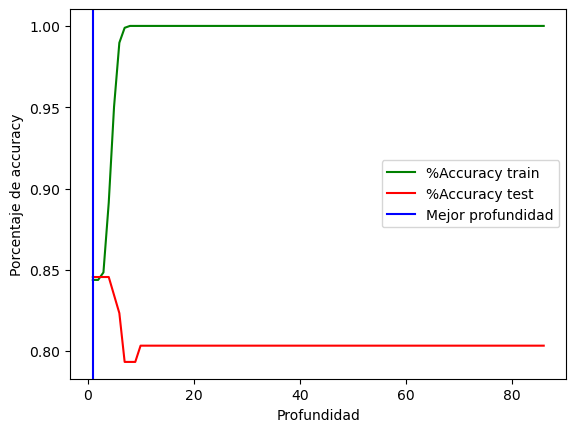

//////////////////////////////////////////////////////////////////////////////
NÚMERO DE ESTIMADORES: 200
La mejor precisión se obtiene con una profundidad máxima = 1 , con una precisión de  0.8455555555555556
La diferencia entre cada porcentaje obtenido en el mejor profundidad es: 0.001783836763788793


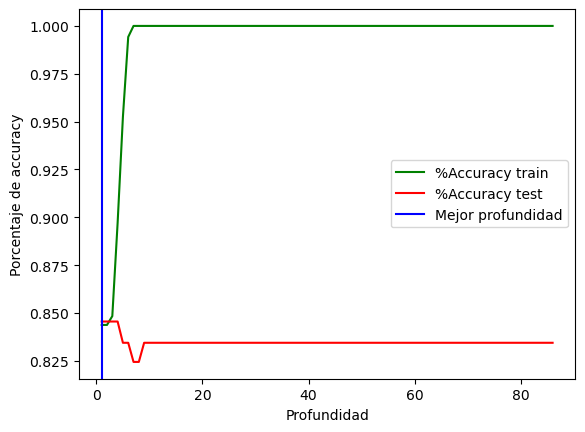

//////////////////////////////////////////////////////////////////////////////
NÚMERO DE ESTIMADORES: 300
La mejor precisión se obtiene con una profundidad máxima = 1 , con una precisión de  0.8455555555555556
La diferencia entre cada porcentaje obtenido en el mejor profundidad es: 0.001783836763788793


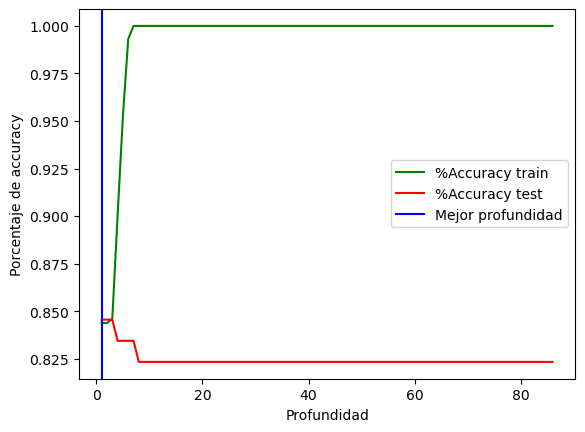

//////////////////////////////////////////////////////////////////////////////
NÚMERO DE ESTIMADORES: 400
La mejor precisión se obtiene con una profundidad máxima = 1 , con una precisión de  0.8455555555555556
La diferencia entre cada porcentaje obtenido en el mejor profundidad es: 0.001783836763788793


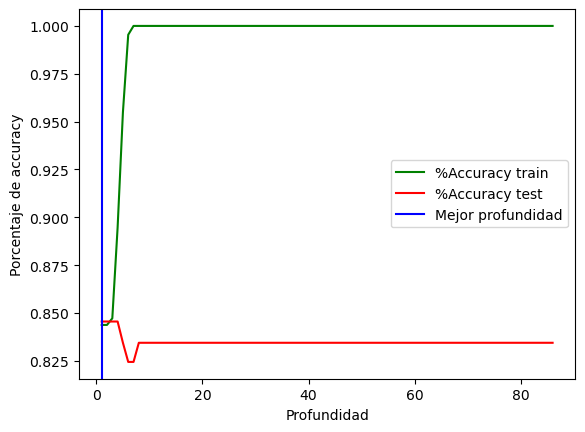

//////////////////////////////////////////////////////////////////////////////
NÚMERO DE ESTIMADORES: 500
La mejor precisión se obtiene con una profundidad máxima = 1 , con una precisión de  0.8455555555555556
La diferencia entre cada porcentaje obtenido en el mejor profundidad es: 0.001783836763788793


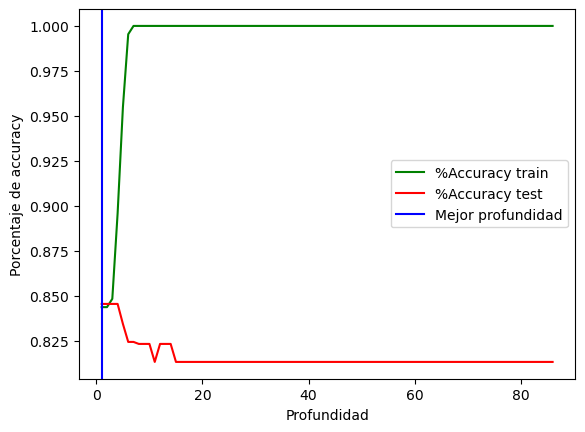

//////////////////////////////////////////////////////////////////////////////


In [12]:
for n in range(100,600,100):
    print("NÚMERO DE ESTIMADORES:",n)
    diferencia_accuracy=[]
    accuracy_train=[]
    accuracy_test=[]
    ks=[]
    for i in range(1,87):
        ks.append(i)
        randomCl = RandomForestClassifier(max_depth=i,random_state=11123,n_estimators=n)  # con n_estimators determinamos la cantidad de árboles que va a generar
        scores=cross_validate(randomCl,atributos_codificados,objetivo_codificado,cv=10,scoring='accuracy',return_train_score=True)
        train_scores=scores['train_score']
        train_score=train_scores.mean()
        test_scores=scores['test_score']
        test_score=test_scores.mean()
        accuracy_train.append(train_score)
        accuracy_test.append(test_score)
        dif=abs(train_score-test_score)
        diferencia_accuracy.append(dif)
    print("La mejor precisión se obtiene con una profundidad máxima =",accuracy_test.index(max(accuracy_test))+1,", con una precisión de ",max(accuracy_test))
    print("La diferencia entre cada porcentaje obtenido en el mejor profundidad es:",diferencia_accuracy[accuracy_test.index(max(accuracy_test))])
    y_entrenamiento=accuracy_train
    y_test=accuracy_test
    pyplot.plot(ks,y_entrenamiento,color='green',label='%Accuracy train')
    pyplot.plot(ks,y_test,color="red",label="%Accuracy test")
    pyplot.xlabel("Profundidad")
    pyplot.ylabel("Porcentaje de accuracy")
    pyplot.axvline(accuracy_test.index(max(accuracy_test))+1, color='blue',label='Mejor profundidad')
    pyplot.legend()
    pyplot.show()
    print("//////////////////////////////////////////////////////////////////////////////")

**Conclusión del modelo:** Al estar basado en CART, devuelve un resultado equivalente, pero se pueden observar 2 cosas:
- La velocidad del modelo es inferior a la del CART y se debe a que este algoritmo depende de la cantidad de árboles de decisión que se construyan
- Cuanto mayor es la profundidad del árbol, peor es la clasificación que realiza, dando a entender que entre todos los árboles de decisión que se han generado, el árbol idónea es igual que el árbol generado en CART.

# Modelo seleccionado:

**El modelo ML óptimo para Quakers es un modelo CART de clasificación sobre el atributo 'gender'** porque como tenemos pocos ejemplos y tenemos tantos atributos continuos con poca correlación entre ellas, clasificar un atributo categórico binario es más efectivo que realizar cualquier otra tarea sobre cualquier otro atributo de los datos que tenemos. 

# CONCLUSIONES FINALES:

- Las métricas relacionales aplicadas generan complejidad para este conjunto de datos, ya que analizando tanto las asociaciones que tienen los atributos relacionales con los atributos del csv , es posible de que el grafo original se realizace sin tener en cuenta las propiedades de cada nodo. Esto explicaría la complejidad que le añade a los modelos ML construidos. Y como tenemos pocos ejemplos, esta complejidad afecta gravemente al modelo.
- Se ha descubierto que other_id es un atributo relacional y es por eso que esta poco correlacionado con la gran mayoría de atributos originales.
- En el modelo Knn de regresión sobre birthdate, los atributos que añaden demasiada complejidad al modelo son todos los atributos relacionales, y esto se debe a que estos no estan asociados positivamente con birthdate, pero deathdate ayuda al modelo debido a que estos dos atributos estan muy asociados positivamente (asociación moderada). Para obtener mejores resultados, se ha demostrado que es necesario facilitar los atributos que complican la estimación de birthdate, los cuales eran todos los atributos relacionales.
- Si intentamos aplicar Train Split en vez de la validación cruzada, esto nos devolverá siempre modelos sobreajustados, ya que estaríamos disminuyendo la cantidad de ejemplos de entrenamiento y esto generaría más complejidad.
- En el modelo CART de clasificación sobre gender, aqui no afecta tanto las métricas relacionales, ya que gracias a la asociación positiva con el resto de atributos se obtienen modelos con rendimiento elevado y con el ajuste idóneo. Al comprobar que ocurriría si quitaramos los atributos de historical_significance, birthdate y deathdate, pudimos observar que se obtienen resultados parecidos.
- Si añadimos más pares atributo-umbral al árbol, obtenemos peores resultados de forma drástica, ya que empieza a capturar información poco relevante y/o compleja.
- En el modelo de RandomForest como obtenemos resultados parecidos al CART, esto demuestra que no importa cuantas combinaciones de árboles hagas, el mejor árbol de decisión que se puede obtener es un árbol de decisión con una profudidad máxima de 1.